# Recurrent Neural Network Battery Degradation Model

Reference:

- `S. Ansari, A. Ayob, M. S. Hossain Lipu, A. Hussain, and M. H. M. Saad, “Data-driven
remaining useful life prediction for lithium-ion batteries using multi-charging profile frame-
work: A recurrent neural network approach”, Sustainability, vol. 13, no. 23, 2021, issn: 2071-1050. doi: 10 . 3390 / su132313333. [Online]. Available: https : / / www . mdpi . com / 2071 -
1050/13/23/13333`

## Import google drive

Importing files from google drive to access saved battery files.  

In [1]:
# import google drive
from google.colab import drive

# mount drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Unzip files

Unzip files and move to working directory

In [2]:
# Import modules
import shutil
import zipfile
from pathlib import Path

# zipfiles complete path
b1 = '/content/drive/MyDrive/5. Battery Data Set/1. BatteryAgingARC-FY08Q4.zip'
#b2 = '/content/drive/MyDrive/5. Battery Data Set/2. BatteryAgingARC_25_26_27_28_P1.zip'
#b3 = '/content/drive/MyDrive/5. Battery Data Set/3. BatteryAgingARC_25-44.zip'
#b4 = '/content/drive/MyDrive/5. Battery Data Set/4. BatteryAgingARC_45_46_47_48.zip'
#b5 = '/content/drive/MyDrive/5. Battery Data Set/5. BatteryAgingARC_49_50_51_52.zip'
#b6 = '/content/drive/MyDrive/5. Battery Data Set/6. BatteryAgingARC_53_54_55_56.zip'

battery_list = [b1,
                #b2,
                #b3,
                #b4,
                #b5,
                #b6,
                ]

# Setup path to data folder
data_path = Path("data/")
nasa_datapath = data_path / "nasa"

# If the image folder doesn't exist download it and prepare it...
if nasa_datapath.is_dir():
    print(f"{nasa_datapath} directory exists.")
else:
    print(f"Did not find {nasa_datapath} directory, creating one...")
    nasa_datapath.mkdir(parents=True, exist_ok=True)

    # move zip file to data_path
    print("Moving zip files to nasa-battery directory...")
    for bat in battery_list:
        filename = bat.split("/")[-1].split(".")[1]
        filepath = bat.split("/")[-1]
        print(f"Moving {filename}.zip ...")
        shutil.copy(bat, data_path)
        with zipfile.ZipFile(data_path / filepath, "r") as zip_ref:
            print(f"Unzipping {filepath} ...")
            zip_ref.extractall(nasa_datapath)

Did not find data/nasa directory, creating one...
Moving zip files to nasa-battery directory...
Moving  BatteryAgingARC-FY08Q4.zip ...
Unzipping 1. BatteryAgingARC-FY08Q4.zip ...


##Move `finaldataprocessing.py`

`finaldataprocessing.py` also saved on google drive and moved to working directory

In [3]:
# Moving Input Processing function
#src = "/content/drive/MyDrive/inputprofileprocessing.py"
#src = "/content/drive/MyDrive/inprofileprocessing.py"
#src = "/content/drive/MyDrive/inprofileprocessing_2.py"
src = "/content/drive/MyDrive/finaldataprocessing.py"
dest = "./"

shutil.copy(src, dest)

'./finaldataprocessing.py'

## Import Modules

In [4]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy 
import scipy.io 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
#import transformers
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from finaldataprocessing import DataProcessing

## Set-up device agnostic code

In [5]:
# Setting up device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Run `data_processing`

In [6]:
data_processing = DataProcessing()

Battery_names = ['B0005', 'B0006', 'B0007', 'B0018']
path = 'data/nasa/'

# Get 31 Dimensional Input from Battery Datasets
input_data, capacity, Batt_Val = data_processing.MultiChannelIP(path=path,
                                                                battery_names=Battery_names)

INFO:root:Loading data...


Loading Dataset B0005.mat...
Loading Dataset B0006.mat...
Loading Dataset B0007.mat...
Loading Dataset B0018.mat...


INFO:root:Cleaning and Normalizing Charge Profile


Length of B0005: 168
Length of B0006: 168
Length of B0007: 168
Length of B0018: 132
Done Cleaning Data!
Max[Voltage_measured]: 4.2995855570950186 | Min[Voltage_measured]: 2.8889259226774757
Max[Current_measured]: 1.536047031556956 | Min[Current_measured]: -4.50882765791034
Max[Temperature_measured]: 36.186651345077465 | Min[Temperature_measured]: 21.810169604006642


INFO:root:Sampling Charging Profiles...


Normalization Done!


INFO:root:Normalizing Capacity Degradation Data...
INFO:root:Producing 31-Dimension Input...


Battery[B0005] | Max Cap: 1.8564874208181574 | Min Cap: 1.2874525221379407
Battery[B0006] | Max Cap: 2.035337591005598 | Min Cap: 1.15381833159625
Battery[B0007] | Max Cap: 1.89105229539079 | Min Cap: 1.4004552399066514
Battery[B0018] | Max Cap: 1.8550045207910817 | Min Cap: 1.341051440640485
Capacity Max: 2.035337591005598 | Min: 1.15381833159625
Capacity Data Normalization Complete!


## Prepare y_train

In [7]:
y_battery = {}
for name in Battery_names:
  df = copy.deepcopy(Batt_Val[name][1])
  df.pop(0)                                 # remove first element
  print(f"New length of {name}: {len(df)}")
  y_battery[name] = df

New length of B0005: 167
New length of B0006: 167
New length of B0007: 167
New length of B0018: 131


## RNN Model

In [8]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

## Metrics

In [9]:
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from collections import Counter
import linecache
import os
import tracemalloc

# Compute for accuracy
def accuracy(y_test, y_pred):
  error = np.abs(y_pred-y_test)/y_test
  acc = np.ones_like(error) - error
  acc = np.sum(acc)/len(y_pred)
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
  """
  Prints difference between start and end time
  """

  total_time = end - start
  print(f"Inference time on {device}: {total_time:.3f} seconds")

  return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  usage_stat = snapshot.statistics(key_type)

  total = sum(stat.size for stat in usage_stat)

  print("Allocated memory: %.1f KiB" % (total / 1024))

## Train function

### Regular Training Loop

This training loop takes the best model during the validation process of the training loop

In [24]:
def train(model, input_data, y_battery, epochs, train_names, test_names, iterations):
    best_model = None
    min_val_loss = sys.maxsize
    for i in range(iterations):
        print(f"Iteration: {i}")
        total_loss = {train_names[0]:[], train_names[1]:[], train_names[2]:[]}
        val_loss = {train_names[0]:[], train_names[1]:[], train_names[2]:[]}
        for epoch in tqdm(range(epochs)):
            for name in train_names:
                model.train()
                x_train = torch.tensor(input_data[name], dtype=torch.float32)
                y_train = torch.tensor(y_battery[name], dtype=torch.float32).unsqueeze(1)
                #epoch_loss = []
                X = x_train.to(device)
                Y = y_train.to(device)
            
                hidden = model.init_zero_hidden()
                hidden = hidden.to(device)
                out = []
                for i in range(X.size()[0]):
                    # 1. Forward Pass
                    output, hidden = model(X[i], hidden)
                    out.append(output)

                y = torch.stack(out).to(device)
                # 2. Calculate Loss
                loss = loss_fn(y.squeeze(-1), Y) 
        
                # 3. Optimizer zero grad
                optimizer.zero_grad()

                # 4. Loss backwards
                loss.backward()

                # 5. Optimizer step
                optimizer.step()

                # Testing
                model.eval()
                #val_epoch_loss = []
                with torch.inference_mode():
                    x_test = torch.tensor(input_data[test_name], dtype=torch.float32)
                    y_test = torch.tensor(y_battery[test_name], dtype=torch.float32).unsqueeze(1)
                    X_test = x_test.to(device)
                    Y_test = y_test.to(device)
                    hidden = model.init_zero_hidden()
                    hidden = hidden.to(device)
                    test_out = []
                    for i in range(X_test.size()[0]):
                        # 1. Forward Pass
                        test_output, hidden = model(X_test[i], hidden)
                        test_out.append(test_output)
                
                    y_pred = torch.stack(test_out).to(device)
                    # 2. Calculate Loss
                    test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
                
                    # get best model
                    if test_loss.item() < min_val_loss:
                        best_model = copy.deepcopy(model).to(device)
                        min_val_loss = test_loss.item()


                if epoch % 100 == 0:
                    print(f"Train Set: {name} | Epoch: {epoch} | Train Loss: {loss:.6f} | Test Set: {test_name} Test Loss: {test_loss:.6f}")
                    total_loss[name].append(loss.item())
                    val_loss[name].append(test_loss.item())
            #total_loss[name] = epoch_loss
            #val_loss[name] = val_epoch_loss

    return total_loss, val_loss, best_model, min_val_loss

### Train function with Leave-One-Out Cross-Evaluation 

In [10]:
def trainv2(model, input_data, y_battery, epochs, train_names, iterations):
    #best_model = None
    #min_val_loss = sys.maxsize
    for i in range(iterations):
        print(f"Iteration: {i}")
        total_loss = {train_names[0]:[], train_names[1]:[], train_names[2]:[]}
        val_loss = {train_names[0]:[], train_names[1]:[], train_names[2]:[]}
        for epoch in tqdm(range(epochs)):
            train_set = random.sample(train_names, k=2)
            val_set = list(set(train_names).difference(train_set))
            for name in train_set:
                model.train()
                x_train = torch.tensor(input_data[name], dtype=torch.float32)
                y_train = torch.tensor(y_battery[name], dtype=torch.float32).unsqueeze(1)
                #epoch_loss = []
                X = x_train.to(device)
                Y = y_train.to(device)
            
                hidden = model.init_zero_hidden()
                hidden = hidden.to(device)
                out = []
                for i in range(X.size()[0]):
                    # 1. Forward Pass
                    output, hidden = model(X[i], hidden)
                    out.append(output)

                y = torch.stack(out).to(device)
                # 2. Calculate Loss
                loss = loss_fn(y.squeeze(-1), Y) 
        
                # 3. Optimizer zero grad
                optimizer.zero_grad()

                # 4. Loss backwards
                loss.backward()

                # 5. Optimizer step
                optimizer.step()

                # Testing
                model.eval()
                #val_epoch_loss = []
                with torch.inference_mode():
                    x_test = torch.tensor(input_data[val_set[0]], dtype=torch.float32)
                    y_test = torch.tensor(y_battery[val_set[0]], dtype=torch.float32).unsqueeze(1)
                    X_test = x_test.to(device)
                    Y_test = y_test.to(device)
                    hidden = model.init_zero_hidden()
                    hidden = hidden.to(device)
                    test_out = []
                    for i in range(X_test.size()[0]):
                        # 1. Forward Pass
                        test_output, hidden = model(X_test[i], hidden)
                        test_out.append(test_output)
                
                    y_pred = torch.stack(test_out).to(device)
                    # 2. Calculate Loss
                    test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
                
                    # get best model
                    #if test_loss.item() < min_val_loss:
                        #best_model = copy.deepcopy(model).to(device)
                        #min_val_loss = test_loss.item()


                if epoch % 100 == 0:
                    print(f"Train Set: {name} | Epoch: {epoch} | Train Loss: {loss:.6f} | Test Set: {val_set[0]} Test Loss: {test_loss:.6f}")
                    total_loss[name].append(loss.item())
                    val_loss[val_set[0]].append(test_loss.item())
            #total_loss[name] = epoch_loss
            #val_loss[name] = val_epoch_loss

    return total_loss, val_loss

## Test Function Loop

In [11]:
def test(best_model, input_data, y_battery, test_name):
    best_model.eval()
    with torch.inference_mode():
        x_test = torch.tensor(input_data[test_name], dtype=torch.float32)
        y_test = torch.tensor(y_battery[test_name], dtype=torch.float32).unsqueeze(1)
        X_test = x_test.to(device)
        Y_test = y_test.to(device)
        hidden = best_model.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = best_model(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

## Training Using Datasets B5, B7, B18 and Test on B6

### Training

Note: The Allocated Memory results for each training is not representative since it is being run continuously, therefore the GPU or CPU is taking more memory as each training iteration. 

### Hidden size = 10

Learning Rate = 0.0005

In [12]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 10
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.0005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

In [13]:
# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0007 | Epoch: 0 | Train Loss: 1.055372 | Test Set: B0005 Test Loss: 0.964193
Train Set: B0018 | Epoch: 0 | Train Loss: 0.954541 | Test Set: B0005 Test Loss: 0.957619
Train Set: B0007 | Epoch: 100 | Train Loss: 0.016752 | Test Set: B0018 Test Loss: 0.014504
Train Set: B0005 | Epoch: 100 | Train Loss: 0.018808 | Test Set: B0018 Test Loss: 0.014496
Train Set: B0018 | Epoch: 200 | Train Loss: 0.012679 | Test Set: B0005 Test Loss: 0.016013
Train Set: B0007 | Epoch: 200 | Train Loss: 0.014010 | Test Set: B0005 Test Loss: 0.016004
Train Set: B0018 | Epoch: 300 | Train Loss: 0.010879 | Test Set: B0005 Test Loss: 0.013087
Train Set: B0007 | Epoch: 300 | Train Loss: 0.011435 | Test Set: B0005 Test Loss: 0.013086
Train Set: B0018 | Epoch: 400 | Train Loss: 0.009092 | Test Set: B0007 Test Loss: 0.008924
Train Set: B0005 | Epoch: 400 | Train Loss: 0.010643 | Test Set: B0007 Test Loss: 0.008913
Train Set: B0005 | Epoch: 500 | Train Loss: 0.008103 | Test Set: B0007 Test Loss: 0.006944
Tra

Test Loss: 0.0034 | MAE: 0.0526 | MSE: 0.0820 | Accuracy: 0.96
Inference time on cuda: 0.025 seconds
Allocated memory: 20.9 KiB


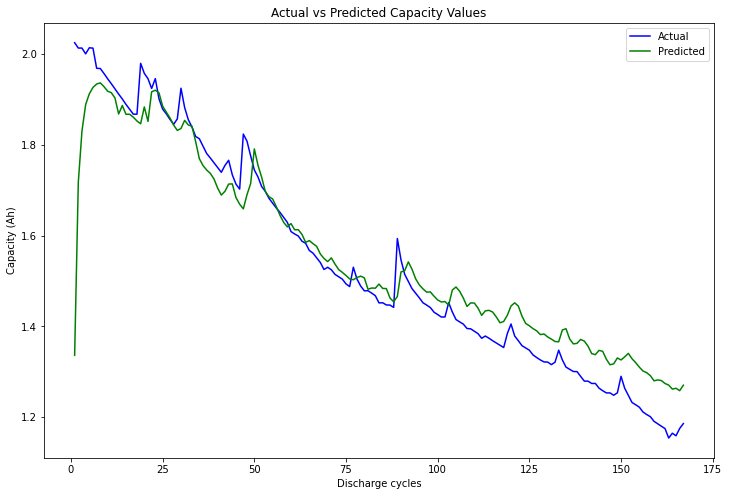

In [14]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Learning Rate = 0.001

In [15]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 10
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.001
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

In [16]:
# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0018 | Epoch: 0 | Train Loss: 0.961283 | Test Set: B0007 Test Loss: 1.039708
Train Set: B0005 | Epoch: 0 | Train Loss: 0.957537 | Test Set: B0007 Test Loss: 1.025484
Train Set: B0007 | Epoch: 100 | Train Loss: 0.013665 | Test Set: B0018 Test Loss: 0.012062
Train Set: B0005 | Epoch: 100 | Train Loss: 0.015769 | Test Set: B0018 Test Loss: 0.012048
Train Set: B0007 | Epoch: 200 | Train Loss: 0.009428 | Test Set: B0005 Test Loss: 0.011119
Train Set: B0018 | Epoch: 200 | Train Loss: 0.009141 | Test Set: B0005 Test Loss: 0.011136
Train Set: B0018 | Epoch: 300 | Train Loss: 0.006710 | Test Set: B0007 Test Loss: 0.006010
Train Set: B0005 | Epoch: 300 | Train Loss: 0.007221 | Test Set: B0007 Test Loss: 0.005996
Train Set: B0007 | Epoch: 400 | Train Loss: 0.003552 | Test Set: B0005 Test Loss: 0.004124
Train Set: B0018 | Epoch: 400 | Train Loss: 0.004943 | Test Set: B0005 Test Loss: 0.004117
Train Set: B0007 | Epoch: 500 | Train Loss: 0.002216 | Test Set: B0005 Test Loss: 0.002417
Tra

Test Loss: 0.0013 | MAE: 0.0337 | MSE: 0.0517 | Accuracy: 0.98
Inference time on cuda: 0.023 seconds
Allocated memory: 1524.9 KiB


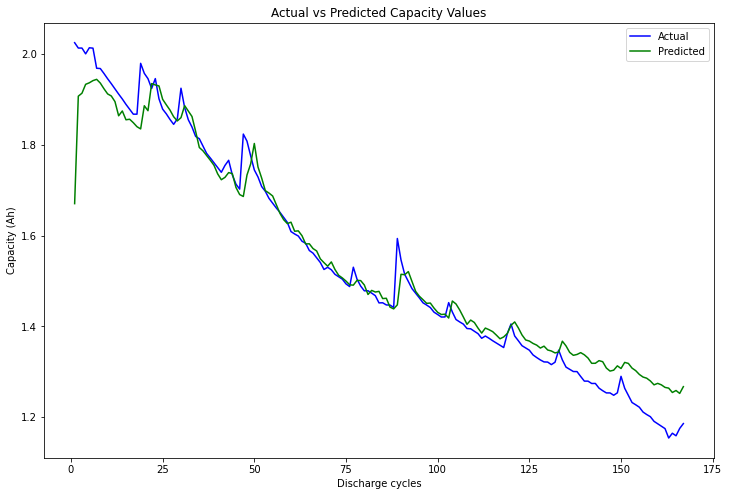

In [17]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Learning Rate = 0.005

In [18]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 10
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

In [19]:
# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0005 | Epoch: 0 | Train Loss: 0.971007 | Test Set: B0007 Test Loss: 0.984674
Train Set: B0018 | Epoch: 0 | Train Loss: 0.898148 | Test Set: B0007 Test Loss: 0.936506
Train Set: B0005 | Epoch: 100 | Train Loss: 0.005768 | Test Set: B0018 Test Loss: 0.004994
Train Set: B0007 | Epoch: 100 | Train Loss: 0.004572 | Test Set: B0018 Test Loss: 0.004925
Train Set: B0007 | Epoch: 200 | Train Loss: 0.001084 | Test Set: B0005 Test Loss: 0.001046
Train Set: B0018 | Epoch: 200 | Train Loss: 0.001666 | Test Set: B0005 Test Loss: 0.001062
Train Set: B0007 | Epoch: 300 | Train Loss: 0.000441 | Test Set: B0005 Test Loss: 0.000401
Train Set: B0018 | Epoch: 300 | Train Loss: 0.000955 | Test Set: B0005 Test Loss: 0.000412
Train Set: B0007 | Epoch: 400 | Train Loss: 0.000261 | Test Set: B0005 Test Loss: 0.000223
Train Set: B0018 | Epoch: 400 | Train Loss: 0.000598 | Test Set: B0005 Test Loss: 0.000218
Train Set: B0007 | Epoch: 500 | Train Loss: 0.000168 | Test Set: B0005 Test Loss: 0.000144
Tra

Test Loss: 0.0005 | MAE: 0.0206 | MSE: 0.0323 | Accuracy: 0.99
Inference time on cuda: 0.024 seconds
Allocated memory: 2521.1 KiB


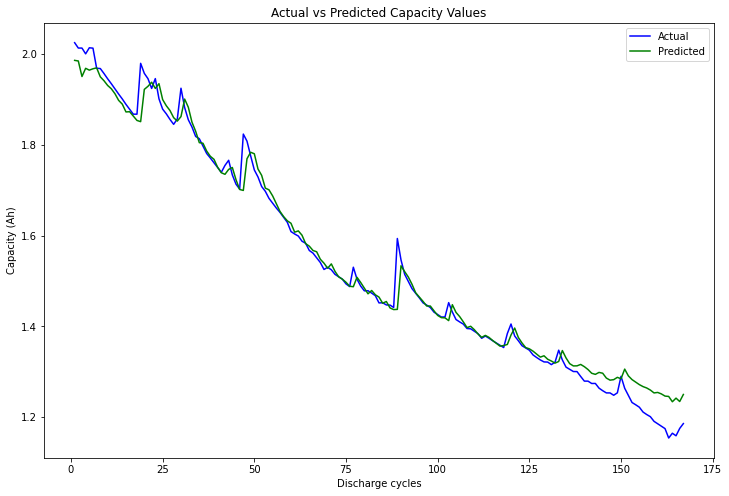

In [20]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Learning Rate = 0.01

In [21]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 10
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.01
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0007 | Epoch: 0 | Train Loss: 1.055372 | Test Set: B0018 Test Loss: 0.850632
Train Set: B0005 | Epoch: 0 | Train Loss: 0.862883 | Test Set: B0018 Test Loss: 0.767867
Train Set: B0018 | Epoch: 100 | Train Loss: 0.002441 | Test Set: B0005 Test Loss: 0.002321
Train Set: B0007 | Epoch: 100 | Train Loss: 0.001592 | Test Set: B0005 Test Loss: 0.002353
Train Set: B0005 | Epoch: 200 | Train Loss: 0.000319 | Test Set: B0007 Test Loss: 0.000301
Train Set: B0018 | Epoch: 200 | Train Loss: 0.000815 | Test Set: B0007 Test Loss: 0.000379
Train Set: B0005 | Epoch: 300 | Train Loss: 0.000147 | Test Set: B0018 Test Loss: 0.000428
Train Set: B0007 | Epoch: 300 | Train Loss: 0.000175 | Test Set: B0018 Test Loss: 0.000428
Train Set: B0018 | Epoch: 400 | Train Loss: 0.000340 | Test Set: B0005 Test Loss: 0.000123
Train Set: B0007 | Epoch: 400 | Train Loss: 0.000135 | Test Set: B0005 Test Loss: 0.000123
Train Set: B0005 | Epoch: 500 | Train Loss: 0.000110 | Test Set: B0007 Test Loss: 0.000116
Tra

Test Loss: 0.0005 | MAE: 0.0184 | MSE: 0.0301 | Accuracy: 0.99
Inference time on cuda: 0.022 seconds
Allocated memory: 3229.2 KiB


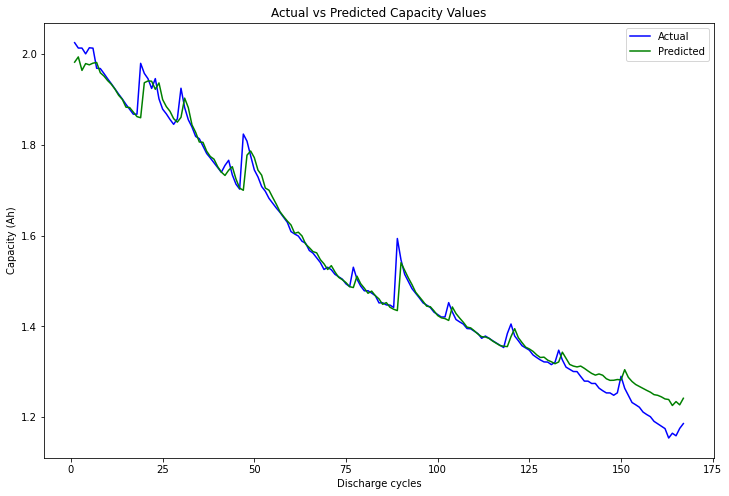

In [22]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

### Hidden size = 32 

Learning rate = 0.0005

In [65]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 32
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.0005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0007 | Epoch: 0 | Train Loss: 1.233187 | Test Set: B0005 Test Loss: 1.156826
Train Set: B0018 | Epoch: 0 | Train Loss: 1.129841 | Test Set: B0005 Test Loss: 1.140548
Train Set: B0018 | Epoch: 100 | Train Loss: 0.013848 | Test Set: B0005 Test Loss: 0.013639
Train Set: B0007 | Epoch: 100 | Train Loss: 0.010868 | Test Set: B0005 Test Loss: 0.013611
Train Set: B0005 | Epoch: 200 | Train Loss: 0.008384 | Test Set: B0007 Test Loss: 0.006530
Train Set: B0018 | Epoch: 200 | Train Loss: 0.009067 | Test Set: B0007 Test Loss: 0.006509
Train Set: B0005 | Epoch: 300 | Train Loss: 0.003007 | Test Set: B0007 Test Loss: 0.002506
Train Set: B0018 | Epoch: 300 | Train Loss: 0.004233 | Test Set: B0007 Test Loss: 0.002502
Train Set: B0018 | Epoch: 400 | Train Loss: 0.002524 | Test Set: B0007 Test Loss: 0.001320
Train Set: B0005 | Epoch: 400 | Train Loss: 0.001410 | Test Set: B0007 Test Loss: 0.001320
Train Set: B0018 | Epoch: 500 | Train Loss: 0.001618 | Test Set: B0007 Test Loss: 0.000772
Tra

Test Loss: 0.0007 | MAE: 0.0251 | MSE: 0.0382 | Accuracy: 0.98
Inference time on cuda: 0.022 seconds
Allocated memory: 12964.5 KiB


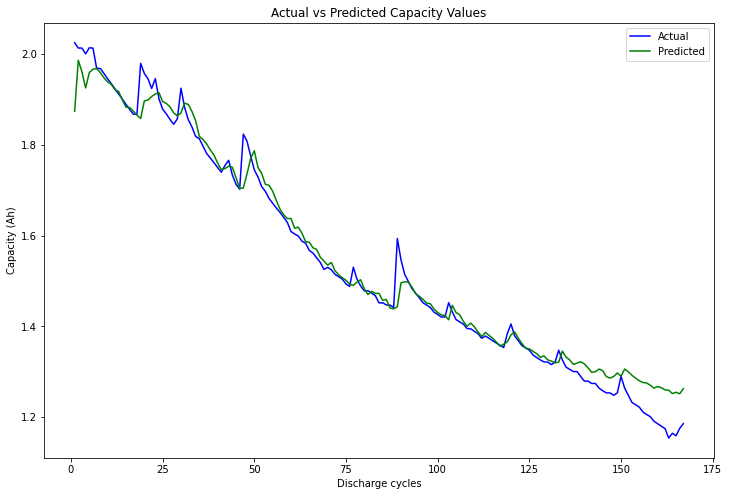

In [66]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Learning rate = 0.001

In [67]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 32
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.001
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0005 | Epoch: 0 | Train Loss: 1.173685 | Test Set: B0018 Test Loss: 1.117451
Train Set: B0007 | Epoch: 0 | Train Loss: 1.200900 | Test Set: B0018 Test Loss: 1.084543
Train Set: B0007 | Epoch: 100 | Train Loss: 0.007555 | Test Set: B0005 Test Loss: 0.009997
Train Set: B0018 | Epoch: 100 | Train Loss: 0.009807 | Test Set: B0005 Test Loss: 0.009960
Train Set: B0007 | Epoch: 200 | Train Loss: 0.002568 | Test Set: B0005 Test Loss: 0.003248
Train Set: B0018 | Epoch: 200 | Train Loss: 0.003834 | Test Set: B0005 Test Loss: 0.003077
Train Set: B0007 | Epoch: 300 | Train Loss: 0.000785 | Test Set: B0005 Test Loss: 0.000872
Train Set: B0018 | Epoch: 300 | Train Loss: 0.001595 | Test Set: B0005 Test Loss: 0.000870
Train Set: B0018 | Epoch: 400 | Train Loss: 0.000865 | Test Set: B0005 Test Loss: 0.000370
Train Set: B0007 | Epoch: 400 | Train Loss: 0.000344 | Test Set: B0005 Test Loss: 0.000369
Train Set: B0007 | Epoch: 500 | Train Loss: 0.000164 | Test Set: B0005 Test Loss: 0.000184
Tra

Test Loss: 0.0006 | MAE: 0.0232 | MSE: 0.0343 | Accuracy: 0.98
Inference time on cuda: 0.024 seconds
Allocated memory: 13657.1 KiB


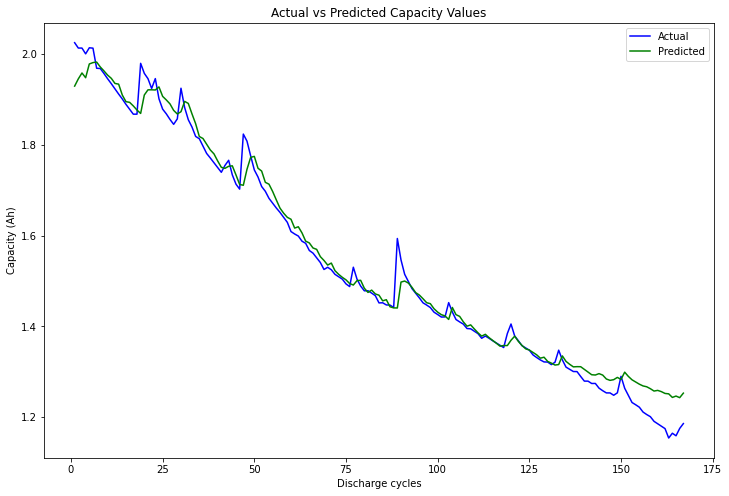

In [68]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Learning Rate = 0.005

In [69]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 32
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0018 | Epoch: 0 | Train Loss: 1.146200 | Test Set: B0007 Test Loss: 1.069425
Train Set: B0005 | Epoch: 0 | Train Loss: 1.014310 | Test Set: B0007 Test Loss: 0.910484
Train Set: B0005 | Epoch: 100 | Train Loss: 0.000731 | Test Set: B0018 Test Loss: 0.001067
Train Set: B0007 | Epoch: 100 | Train Loss: 0.000452 | Test Set: B0018 Test Loss: 0.001027
Train Set: B0018 | Epoch: 200 | Train Loss: 0.000431 | Test Set: B0005 Test Loss: 0.000113
Train Set: B0007 | Epoch: 200 | Train Loss: 0.000103 | Test Set: B0005 Test Loss: 0.000112
Train Set: B0005 | Epoch: 300 | Train Loss: 0.000093 | Test Set: B0007 Test Loss: 0.000089
Train Set: B0018 | Epoch: 300 | Train Loss: 0.000324 | Test Set: B0007 Test Loss: 0.000088
Train Set: B0005 | Epoch: 400 | Train Loss: 0.000098 | Test Set: B0018 Test Loss: 0.000275
Train Set: B0007 | Epoch: 400 | Train Loss: 0.000085 | Test Set: B0018 Test Loss: 0.000274
Train Set: B0018 | Epoch: 500 | Train Loss: 0.000244 | Test Set: B0007 Test Loss: 0.000082
Tra

Test Loss: 0.0006 | MAE: 0.0202 | MSE: 0.0332 | Accuracy: 0.99
Inference time on cuda: 0.021 seconds
Allocated memory: 14346.3 KiB


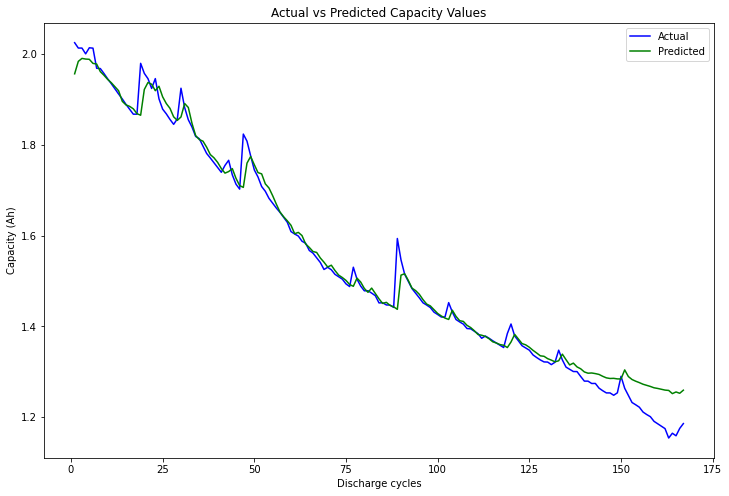

In [70]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Learning Rate = 0.01

In [71]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 32
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.01
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0007 | Epoch: 0 | Train Loss: 1.233187 | Test Set: B0005 Test Loss: 0.820584
Train Set: B0018 | Epoch: 0 | Train Loss: 0.800341 | Test Set: B0005 Test Loss: 0.487632
Train Set: B0005 | Epoch: 100 | Train Loss: 0.001056 | Test Set: B0007 Test Loss: 0.000769
Train Set: B0018 | Epoch: 100 | Train Loss: 0.002129 | Test Set: B0007 Test Loss: 0.000648
Train Set: B0018 | Epoch: 200 | Train Loss: 0.000407 | Test Set: B0005 Test Loss: 0.000226
Train Set: B0007 | Epoch: 200 | Train Loss: 0.000200 | Test Set: B0005 Test Loss: 0.000281
Train Set: B0005 | Epoch: 300 | Train Loss: 0.000124 | Test Set: B0007 Test Loss: 0.000137
Train Set: B0018 | Epoch: 300 | Train Loss: 0.000313 | Test Set: B0007 Test Loss: 0.000135
Train Set: B0005 | Epoch: 400 | Train Loss: 0.000108 | Test Set: B0007 Test Loss: 0.000111
Train Set: B0018 | Epoch: 400 | Train Loss: 0.000262 | Test Set: B0007 Test Loss: 0.000117
Train Set: B0007 | Epoch: 500 | Train Loss: 0.000094 | Test Set: B0005 Test Loss: 0.000098
Tra

Test Loss: 0.0003 | MAE: 0.0151 | MSE: 0.0246 | Accuracy: 0.99
Inference time on cuda: 0.023 seconds
Allocated memory: 15048.4 KiB


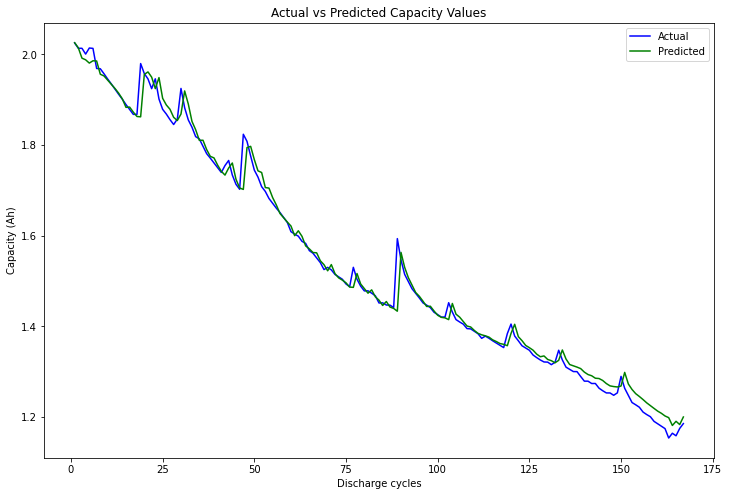

In [72]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

### Hidden size = 64 

Learning rate = 0.0005

In [46]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 64
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.0005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0005 | Epoch: 0 | Train Loss: 0.991804 | Test Set: B0018 Test Loss: 0.922390
Train Set: B0007 | Epoch: 0 | Train Loss: 1.026996 | Test Set: B0018 Test Loss: 0.878325
Train Set: B0018 | Epoch: 100 | Train Loss: 0.012260 | Test Set: B0007 Test Loss: 0.011104
Train Set: B0005 | Epoch: 100 | Train Loss: 0.012487 | Test Set: B0007 Test Loss: 0.011078
Train Set: B0005 | Epoch: 200 | Train Loss: 0.004561 | Test Set: B0018 Test Loss: 0.006265
Train Set: B0007 | Epoch: 200 | Train Loss: 0.004697 | Test Set: B0018 Test Loss: 0.006254
Train Set: B0005 | Epoch: 300 | Train Loss: 0.002504 | Test Set: B0007 Test Loss: 0.002420
Train Set: B0018 | Epoch: 300 | Train Loss: 0.003590 | Test Set: B0007 Test Loss: 0.002415
Train Set: B0007 | Epoch: 400 | Train Loss: 0.001294 | Test Set: B0005 Test Loss: 0.001281
Train Set: B0018 | Epoch: 400 | Train Loss: 0.002018 | Test Set: B0005 Test Loss: 0.001284
Train Set: B0007 | Epoch: 500 | Train Loss: 0.000608 | Test Set: B0005 Test Loss: 0.000615
Tra

Test Loss: 0.0006 | MAE: 0.0239 | MSE: 0.0349 | Accuracy: 0.98
Inference time on cuda: 0.025 seconds
Allocated memory: 6629.6 KiB


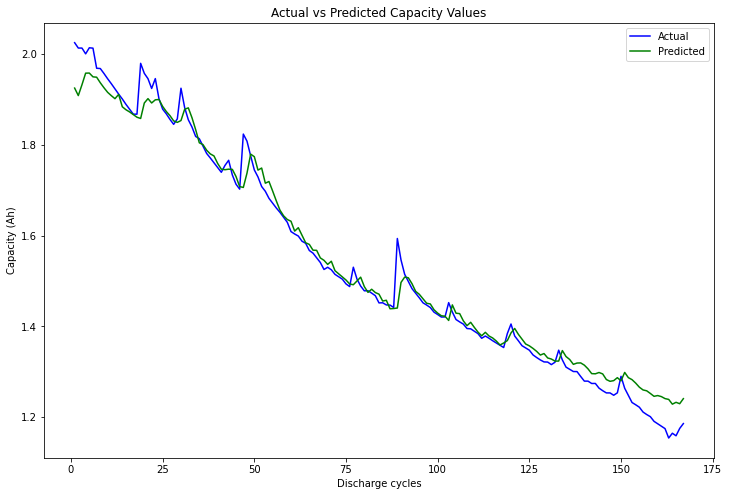

In [47]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Learning rate = 0.001

In [48]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 64
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.001
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0005 | Epoch: 0 | Train Loss: 0.991804 | Test Set: B0018 Test Loss: 0.878337
Train Set: B0007 | Epoch: 0 | Train Loss: 0.983047 | Test Set: B0018 Test Loss: 0.788056
Train Set: B0005 | Epoch: 100 | Train Loss: 0.007937 | Test Set: B0018 Test Loss: 0.008183
Train Set: B0007 | Epoch: 100 | Train Loss: 0.006816 | Test Set: B0018 Test Loss: 0.008164
Train Set: B0007 | Epoch: 200 | Train Loss: 0.002087 | Test Set: B0018 Test Loss: 0.003226
Train Set: B0005 | Epoch: 200 | Train Loss: 0.002308 | Test Set: B0018 Test Loss: 0.003241
Train Set: B0007 | Epoch: 300 | Train Loss: 0.000795 | Test Set: B0018 Test Loss: 0.001299
Train Set: B0005 | Epoch: 300 | Train Loss: 0.000881 | Test Set: B0018 Test Loss: 0.001291
Train Set: B0005 | Epoch: 400 | Train Loss: 0.000303 | Test Set: B0007 Test Loss: 0.000309
Train Set: B0018 | Epoch: 400 | Train Loss: 0.000577 | Test Set: B0007 Test Loss: 0.000303
Train Set: B0007 | Epoch: 500 | Train Loss: 0.000136 | Test Set: B0005 Test Loss: 0.000134
Tra

Test Loss: 0.0006 | MAE: 0.0234 | MSE: 0.0352 | Accuracy: 0.98
Inference time on cuda: 0.027 seconds
Allocated memory: 7364.4 KiB


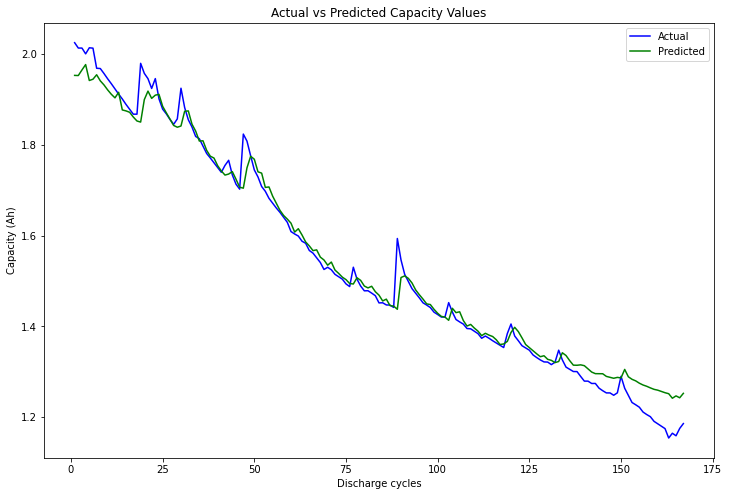

In [49]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Learning Rate = 0.005

In [50]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 64
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0007 | Epoch: 0 | Train Loss: 1.070469 | Test Set: B0018 Test Loss: 0.503277
Train Set: B0005 | Epoch: 0 | Train Loss: 0.534193 | Test Set: B0018 Test Loss: 0.094981
Train Set: B0007 | Epoch: 100 | Train Loss: 0.000590 | Test Set: B0005 Test Loss: 0.000705
Train Set: B0018 | Epoch: 100 | Train Loss: 0.001411 | Test Set: B0005 Test Loss: 0.000573
Train Set: B0007 | Epoch: 200 | Train Loss: 0.000140 | Test Set: B0018 Test Loss: 0.000276
Train Set: B0005 | Epoch: 200 | Train Loss: 0.000143 | Test Set: B0018 Test Loss: 0.000278
Train Set: B0007 | Epoch: 300 | Train Loss: 0.000116 | Test Set: B0005 Test Loss: 0.000114
Train Set: B0018 | Epoch: 300 | Train Loss: 0.000247 | Test Set: B0005 Test Loss: 0.000114
Train Set: B0005 | Epoch: 400 | Train Loss: 0.000109 | Test Set: B0007 Test Loss: 0.000103
Train Set: B0018 | Epoch: 400 | Train Loss: 0.000226 | Test Set: B0007 Test Loss: 0.000103
Train Set: B0007 | Epoch: 500 | Train Loss: 0.000096 | Test Set: B0005 Test Loss: 0.000102
Tra

Test Loss: 0.0011 | MAE: 0.0370 | MSE: 0.0459 | Accuracy: 0.98
Inference time on cuda: 0.021 seconds
Allocated memory: 8032.3 KiB


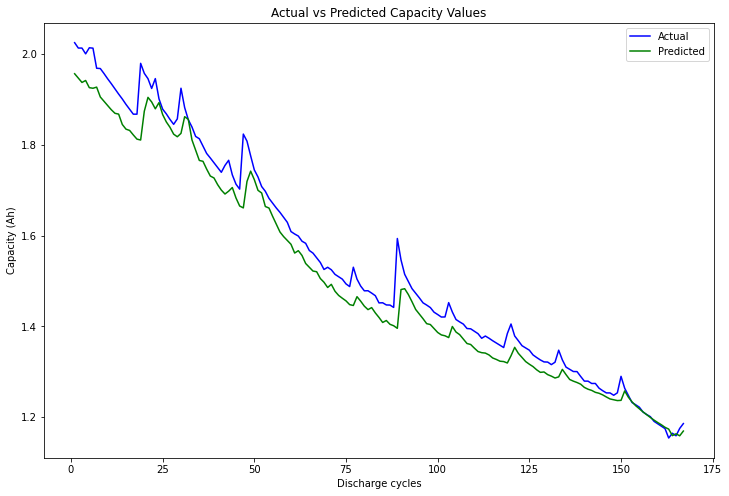

In [51]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Learning Rate = 0.01

In [52]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 64
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.01
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0018 | Epoch: 0 | Train Loss: 0.965776 | Test Set: B0007 Test Loss: 0.123140
Train Set: B0005 | Epoch: 0 | Train Loss: 0.103234 | Test Set: B0007 Test Loss: 1.533589
Train Set: B0007 | Epoch: 100 | Train Loss: 0.000638 | Test Set: B0005 Test Loss: 0.000938
Train Set: B0018 | Epoch: 100 | Train Loss: 0.001066 | Test Set: B0005 Test Loss: 0.000932
Train Set: B0007 | Epoch: 200 | Train Loss: 0.000187 | Test Set: B0018 Test Loss: 0.000336
Train Set: B0005 | Epoch: 200 | Train Loss: 0.000185 | Test Set: B0018 Test Loss: 0.000334
Train Set: B0005 | Epoch: 300 | Train Loss: 0.000132 | Test Set: B0007 Test Loss: 0.000140
Train Set: B0018 | Epoch: 300 | Train Loss: 0.000269 | Test Set: B0007 Test Loss: 0.000142
Train Set: B0007 | Epoch: 400 | Train Loss: 0.000121 | Test Set: B0005 Test Loss: 0.000120
Train Set: B0018 | Epoch: 400 | Train Loss: 0.000236 | Test Set: B0005 Test Loss: 0.000120
Train Set: B0007 | Epoch: 500 | Train Loss: 0.000106 | Test Set: B0018 Test Loss: 0.000221
Tra

Test Loss: 0.0003 | MAE: 0.0157 | MSE: 0.0253 | Accuracy: 0.99
Inference time on cuda: 0.021 seconds
Allocated memory: 8764.0 KiB


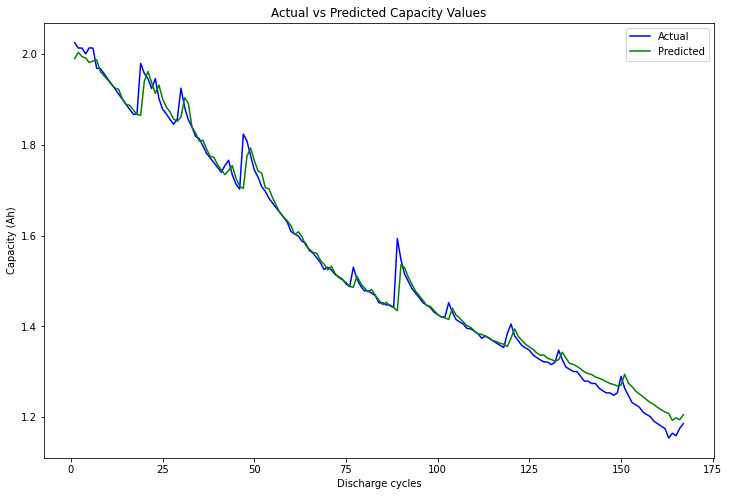

In [53]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

### Hidden size = 128

Learning rate = 0.0005

In [54]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 128
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.0005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0018 | Epoch: 0 | Train Loss: 1.294950 | Test Set: B0005 Test Loss: 1.270770
Train Set: B0007 | Epoch: 0 | Train Loss: 1.341045 | Test Set: B0005 Test Loss: 1.201650
Train Set: B0005 | Epoch: 100 | Train Loss: 0.006644 | Test Set: B0007 Test Loss: 0.005627
Train Set: B0018 | Epoch: 100 | Train Loss: 0.006568 | Test Set: B0007 Test Loss: 0.005570
Train Set: B0007 | Epoch: 200 | Train Loss: 0.000492 | Test Set: B0005 Test Loss: 0.000515
Train Set: B0018 | Epoch: 200 | Train Loss: 0.001068 | Test Set: B0005 Test Loss: 0.000510
Train Set: B0005 | Epoch: 300 | Train Loss: 0.000263 | Test Set: B0018 Test Loss: 0.000522
Train Set: B0007 | Epoch: 300 | Train Loss: 0.000194 | Test Set: B0018 Test Loss: 0.000521
Train Set: B0005 | Epoch: 400 | Train Loss: 0.000181 | Test Set: B0018 Test Loss: 0.000449
Train Set: B0007 | Epoch: 400 | Train Loss: 0.000172 | Test Set: B0018 Test Loss: 0.000448
Train Set: B0005 | Epoch: 500 | Train Loss: 0.000160 | Test Set: B0018 Test Loss: 0.000400
Tra

Test Loss: 0.0011 | MAE: 0.0320 | MSE: 0.0469 | Accuracy: 0.98
Inference time on cuda: 0.024 seconds
Allocated memory: 9494.4 KiB


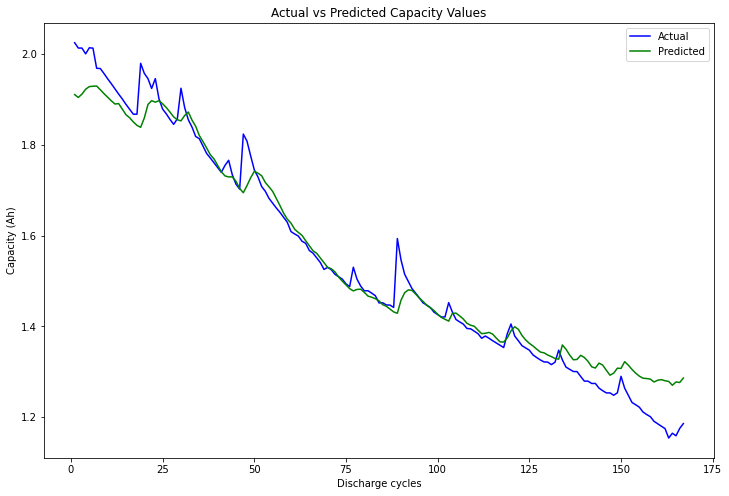

In [55]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Learning rate = 0.001

In [56]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 128
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.001
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0005 | Epoch: 0 | Train Loss: 1.338829 | Test Set: B0007 Test Loss: 1.268514
Train Set: B0018 | Epoch: 0 | Train Loss: 1.157750 | Test Set: B0007 Test Loss: 1.123449
Train Set: B0007 | Epoch: 100 | Train Loss: 0.001262 | Test Set: B0018 Test Loss: 0.002182
Train Set: B0005 | Epoch: 100 | Train Loss: 0.001604 | Test Set: B0018 Test Loss: 0.002039
Train Set: B0005 | Epoch: 200 | Train Loss: 0.000193 | Test Set: B0007 Test Loss: 0.000293
Train Set: B0018 | Epoch: 200 | Train Loss: 0.000495 | Test Set: B0007 Test Loss: 0.000277
Train Set: B0018 | Epoch: 300 | Train Loss: 0.000352 | Test Set: B0005 Test Loss: 0.000154
Train Set: B0007 | Epoch: 300 | Train Loss: 0.000183 | Test Set: B0005 Test Loss: 0.000162
Train Set: B0005 | Epoch: 400 | Train Loss: 0.000152 | Test Set: B0018 Test Loss: 0.000309
Train Set: B0007 | Epoch: 400 | Train Loss: 0.000140 | Test Set: B0018 Test Loss: 0.000315
Train Set: B0018 | Epoch: 500 | Train Loss: 0.000289 | Test Set: B0007 Test Loss: 0.000129
Tra

Test Loss: 0.0009 | MAE: 0.0290 | MSE: 0.0421 | Accuracy: 0.98
Inference time on cuda: 0.022 seconds
Allocated memory: 10207.1 KiB


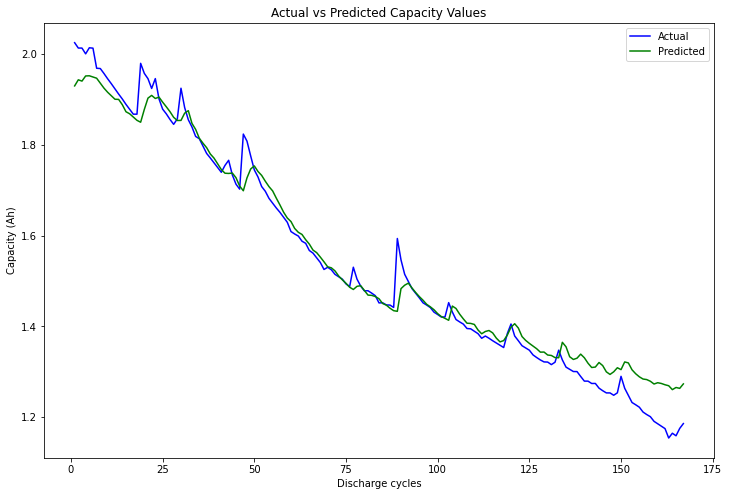

In [57]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Learning Rate = 0.005

In [58]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 128
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0018 | Epoch: 0 | Train Loss: 1.294950 | Test Set: B0005 Test Loss: 0.611268
Train Set: B0007 | Epoch: 0 | Train Loss: 0.661786 | Test Set: B0005 Test Loss: 0.022196
Train Set: B0018 | Epoch: 100 | Train Loss: 0.001068 | Test Set: B0005 Test Loss: 0.000828
Train Set: B0007 | Epoch: 100 | Train Loss: 0.000965 | Test Set: B0005 Test Loss: 0.000733
Train Set: B0018 | Epoch: 200 | Train Loss: 0.000365 | Test Set: B0007 Test Loss: 0.000187
Train Set: B0005 | Epoch: 200 | Train Loss: 0.000178 | Test Set: B0007 Test Loss: 0.000188
Train Set: B0018 | Epoch: 300 | Train Loss: 0.000265 | Test Set: B0007 Test Loss: 0.000146
Train Set: B0005 | Epoch: 300 | Train Loss: 0.000133 | Test Set: B0007 Test Loss: 0.000146
Train Set: B0018 | Epoch: 400 | Train Loss: 0.000237 | Test Set: B0007 Test Loss: 0.000117
Train Set: B0005 | Epoch: 400 | Train Loss: 0.000121 | Test Set: B0007 Test Loss: 0.000117
Train Set: B0005 | Epoch: 500 | Train Loss: 0.000111 | Test Set: B0007 Test Loss: 0.000102
Tra

Test Loss: 0.0007 | MAE: 0.0236 | MSE: 0.0361 | Accuracy: 0.98
Inference time on cuda: 0.023 seconds
Allocated memory: 10930.6 KiB


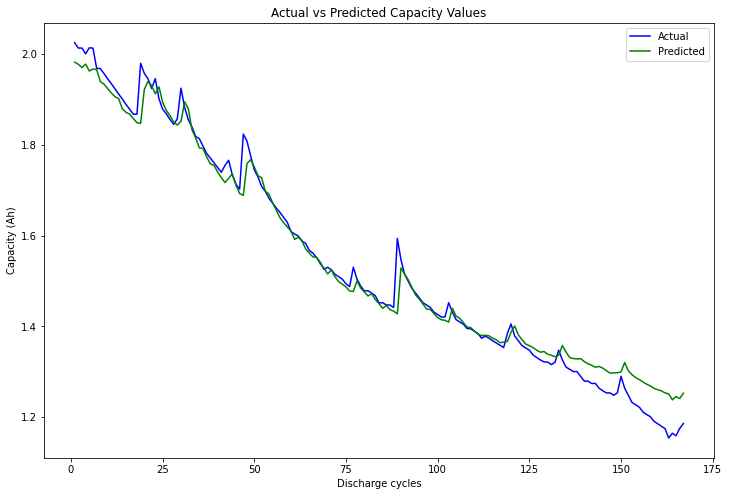

In [59]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Learning Rate = 0.01

In [60]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 128
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.01
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0007', 'B0018']
#test_name = 'B0006'
iterations = 1
total_loss, val_loss = trainv2(model_0, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0007 | Epoch: 0 | Train Loss: 1.411281 | Test Set: B0018 Test Loss: 0.028156
Train Set: B0005 | Epoch: 0 | Train Loss: 0.038095 | Test Set: B0018 Test Loss: 5.626756
Train Set: B0007 | Epoch: 100 | Train Loss: 0.000207 | Test Set: B0005 Test Loss: 0.000218
Train Set: B0018 | Epoch: 100 | Train Loss: 0.000756 | Test Set: B0005 Test Loss: 0.000215
Train Set: B0005 | Epoch: 200 | Train Loss: 0.000121 | Test Set: B0018 Test Loss: 0.000392
Train Set: B0007 | Epoch: 200 | Train Loss: 0.000100 | Test Set: B0018 Test Loss: 0.000393
Train Set: B0005 | Epoch: 300 | Train Loss: 0.000104 | Test Set: B0018 Test Loss: 0.000325
Train Set: B0007 | Epoch: 300 | Train Loss: 0.000087 | Test Set: B0018 Test Loss: 0.000325
Train Set: B0018 | Epoch: 400 | Train Loss: 0.000289 | Test Set: B0005 Test Loss: 0.000094
Train Set: B0007 | Epoch: 400 | Train Loss: 0.000081 | Test Set: B0005 Test Loss: 0.000095
Train Set: B0018 | Epoch: 500 | Train Loss: 0.000449 | Test Set: B0007 Test Loss: 0.000109
Tra

Test Loss: 0.0006 | MAE: 0.0235 | MSE: 0.0351 | Accuracy: 0.99
Inference time on cuda: 0.022 seconds
Allocated memory: 11580.6 KiB


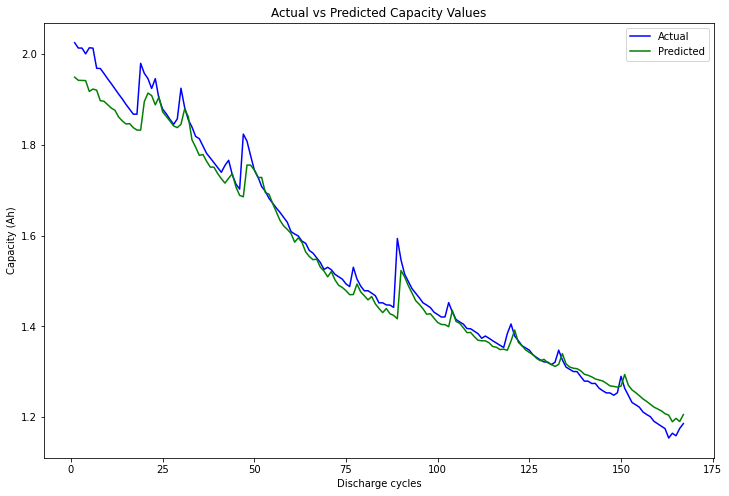

In [61]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

### Other training

In [25]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 10
output_size = 1
model_0 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_0 = model_0.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

In [26]:
train_names = ['B0005', 'B0007', 'B0018']
test_name = 'B0006'
iterations = 1
total_loss, val_loss, best_model_B6, min_val_loss_B6 = train(model_0, input_data, y_battery, epochs, train_names, test_name, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0005 | Epoch: 0 | Train Loss: 0.971007 | Test Set: B0006 Test Loss: 0.883520
Train Set: B0007 | Epoch: 0 | Train Loss: 0.984674 | Test Set: B0006 Test Loss: 0.839139
Train Set: B0018 | Epoch: 0 | Train Loss: 0.852527 | Test Set: B0006 Test Loss: 0.797431
Train Set: B0005 | Epoch: 100 | Train Loss: 0.002295 | Test Set: B0006 Test Loss: 0.004591
Train Set: B0007 | Epoch: 100 | Train Loss: 0.001798 | Test Set: B0006 Test Loss: 0.004517
Train Set: B0018 | Epoch: 100 | Train Loss: 0.002879 | Test Set: B0006 Test Loss: 0.004513
Train Set: B0005 | Epoch: 200 | Train Loss: 0.000400 | Test Set: B0006 Test Loss: 0.001289
Train Set: B0007 | Epoch: 200 | Train Loss: 0.000419 | Test Set: B0006 Test Loss: 0.001283
Train Set: B0018 | Epoch: 200 | Train Loss: 0.000980 | Test Set: B0006 Test Loss: 0.001285
Train Set: B0005 | Epoch: 300 | Train Loss: 0.000173 | Test Set: B0006 Test Loss: 0.000825
Train Set: B0007 | Epoch: 300 | Train Loss: 0.000200 | Test Set: B0006 Test Loss: 0.000824
Train

### Loss plot

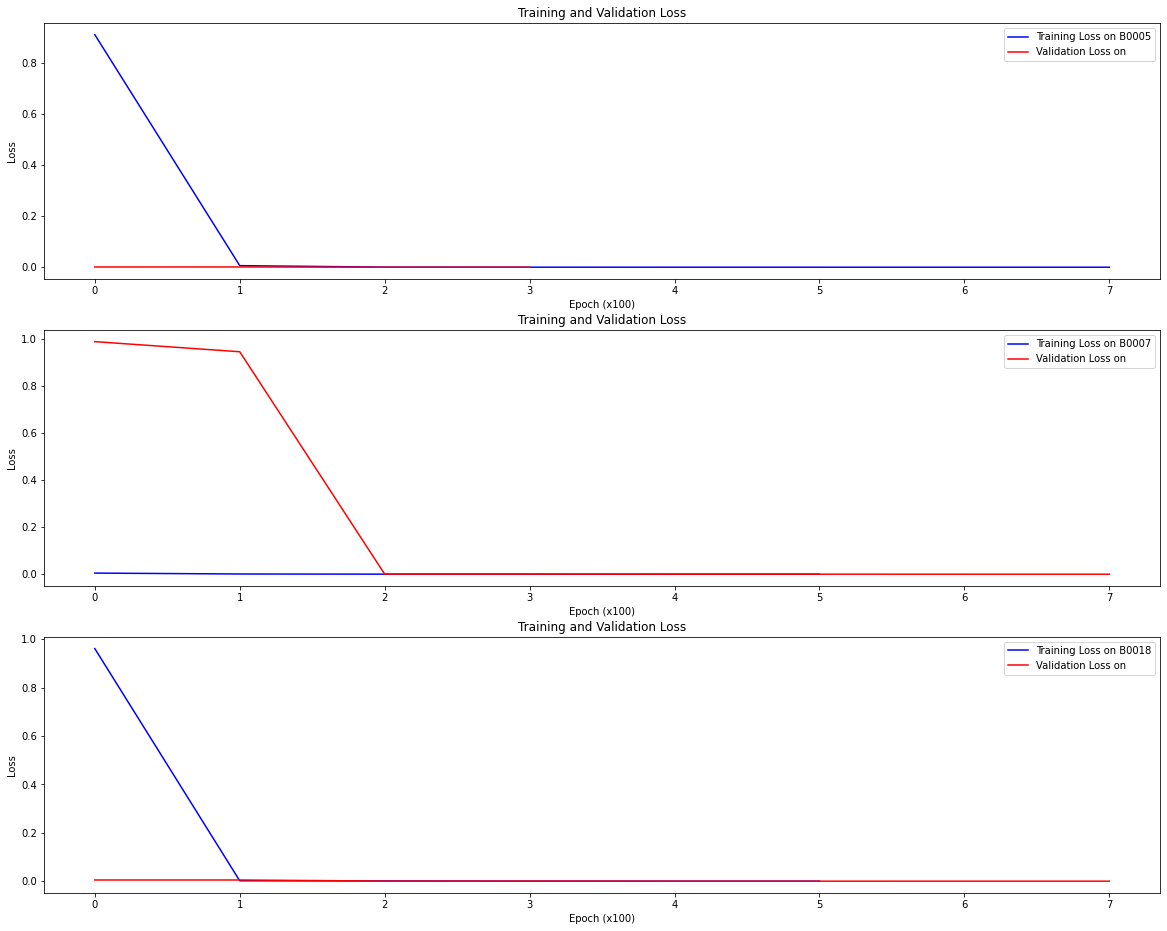

In [ ]:
fig, axs = plt.subplots(3, figsize = (20, 16))
for i, ax in enumerate(axs):
    x1 = list(range(0,len(total_loss[train_names[i]])))
    x2 = list(range(0,len(val_loss[train_names[i]])))
    axs[i].plot(x1, total_loss[train_names[i]], 'b', label="Training Loss on "+train_names[i])
    axs[i].plot(x2, val_loss[train_names[i]], 'r', label="Validation Loss on ")
    axs[i].legend(loc="upper right")
    axs[i].set(xlabel = 'Epoch (x100)', ylabel='Loss', title='Training and Validation Loss')
plt.legend()


### Prediction

Test Loss: 0.0004 | MAE: 0.0184 | MSE: 0.0299 | Accuracy: 0.99
Inference time on cpu: 0.021 seconds
Allocated memory: 20.2 KiB


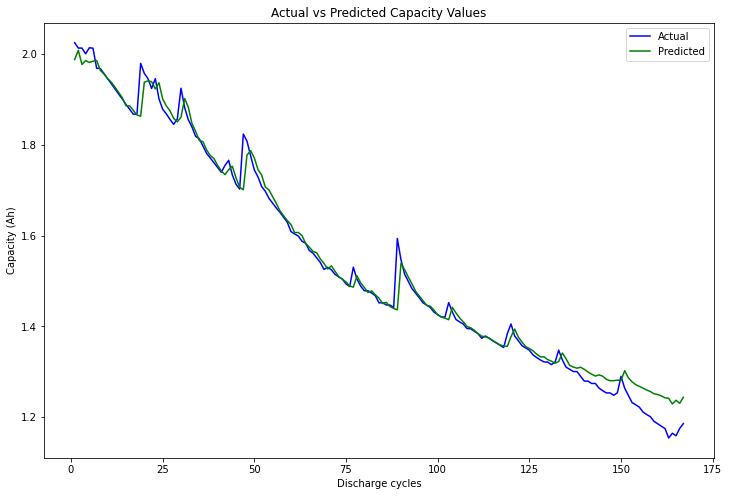

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=best_model_B6,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0005 | MAE: 0.0196 | MSE: 0.0308 | Accuracy: 0.99
Inference time on cuda: 0.037 seconds
Allocated memory: 18.5 KiB


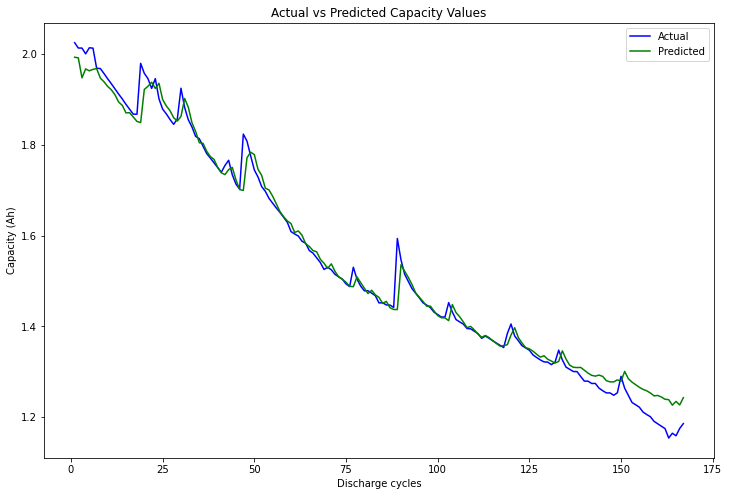

In [ ]:
# PREDICTION USING LEAVE-ONE OUT EVALUATION
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_0,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

### Showing behavior of model on trained sets

Test Loss: 0.0001 | MAE: 0.0076 | MSE: 0.0128 | Accuracy: 1.00
Inference time on cpu: 0.029 seconds
Allocated memory: 5811.1 KiB


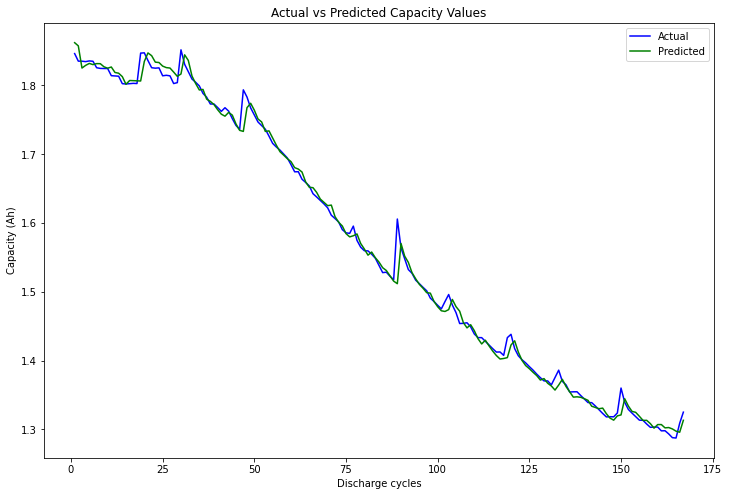

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0005'
test_loss, Y_test, y_pred = test(best_model=best_model_B6,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0001 | MAE: 0.0069 | MSE: 0.0119 | Accuracy: 1.00
Inference time on cpu: 0.024 seconds
Allocated memory: 6445.6 KiB


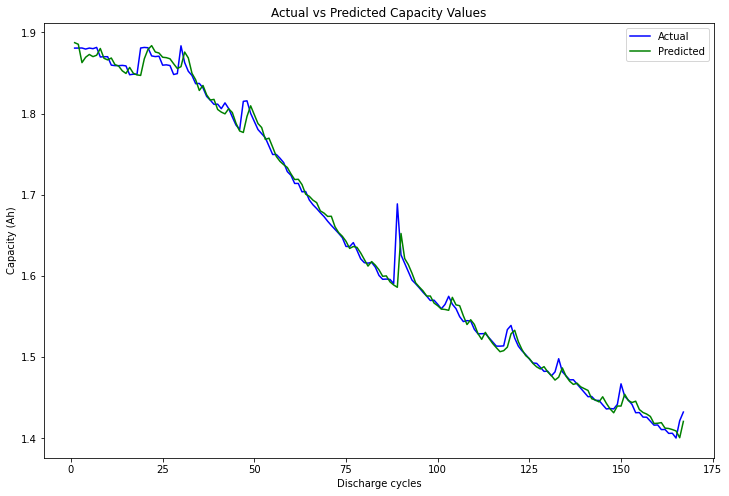

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0007'
test_loss, Y_test, y_pred = test(best_model=best_model_B6,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0002 | MAE: 0.0127 | MSE: 0.0202 | Accuracy: 0.99
Inference time on cpu: 0.013 seconds
Allocated memory: 6904.6 KiB


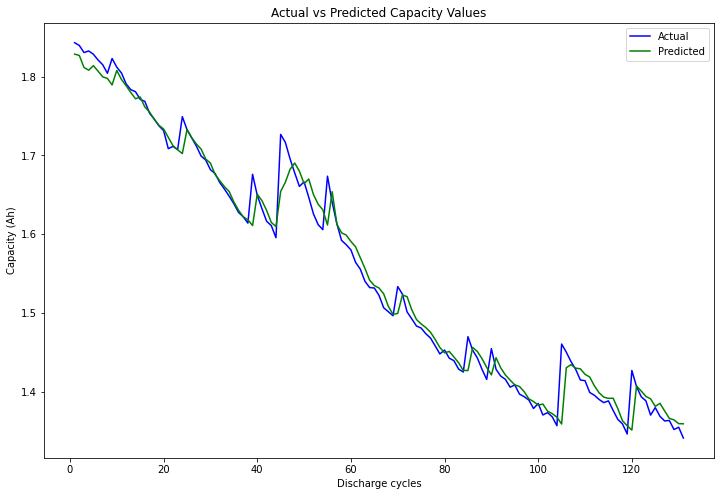

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0018'
test_loss, Y_test, y_pred = test(best_model=best_model_B6,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

## Training Using Datasets B5, B6, B7 and Test on B18

### Training

In [ ]:
torch.manual_seed(42)

input_size = 31
hidden_size = 10
output_size = 1
model_1 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_1 = model_1.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

In [ ]:
train_names = ['B0005', 'B0006', 'B0007']
test_name = 'B0018'
iterations = 1
total_loss, val_loss, best_model_B18, min_val_loss_B18 = train(model_1, input_data, y_battery, epochs, train_names, test_name, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0005 | Epoch: 0 | Train Loss: 0.971007 | Test Set: B0018 Test Loss: 0.898148
Train Set: B0006 | Epoch: 0 | Train Loss: 0.883520 | Test Set: B0018 Test Loss: 0.851303
Train Set: B0007 | Epoch: 0 | Train Loss: 0.935527 | Test Set: B0018 Test Loss: 0.807892
Train Set: B0005 | Epoch: 100 | Train Loss: 0.001252 | Test Set: B0018 Test Loss: 0.002901
Train Set: B0006 | Epoch: 100 | Train Loss: 0.002052 | Test Set: B0018 Test Loss: 0.002877
Train Set: B0007 | Epoch: 100 | Train Loss: 0.001226 | Test Set: B0018 Test Loss: 0.002897
Train Set: B0005 | Epoch: 200 | Train Loss: 0.000428 | Test Set: B0018 Test Loss: 0.001600
Train Set: B0006 | Epoch: 200 | Train Loss: 0.000897 | Test Set: B0018 Test Loss: 0.001578
Train Set: B0007 | Epoch: 200 | Train Loss: 0.000460 | Test Set: B0018 Test Loss: 0.001595
Train Set: B0005 | Epoch: 300 | Train Loss: 0.000185 | Test Set: B0018 Test Loss: 0.001056
Train Set: B0006 | Epoch: 300 | Train Loss: 0.000496 | Test Set: B0018 Test Loss: 0.001054
Train

In [ ]:
# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0006', 'B0007']
iterations = 1
total_loss, val_loss = trainv2(model_1, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0007 | Epoch: 0 | Train Loss: 1.055372 | Test Set: B0005 Test Loss: 0.909181
Train Set: B0006 | Epoch: 0 | Train Loss: 0.883521 | Test Set: B0005 Test Loss: 0.863788
Train Set: B0005 | Epoch: 100 | Train Loss: 0.003894 | Test Set: B0006 Test Loss: 0.006685
Train Set: B0007 | Epoch: 100 | Train Loss: 0.003217 | Test Set: B0006 Test Loss: 0.006614
Train Set: B0007 | Epoch: 200 | Train Loss: 0.000847 | Test Set: B0006 Test Loss: 0.001489
Train Set: B0005 | Epoch: 200 | Train Loss: 0.000908 | Test Set: B0006 Test Loss: 0.001481
Train Set: B0005 | Epoch: 300 | Train Loss: 0.000455 | Test Set: B0007 Test Loss: 0.000459
Train Set: B0006 | Epoch: 300 | Train Loss: 0.000938 | Test Set: B0007 Test Loss: 0.000469
Train Set: B0005 | Epoch: 400 | Train Loss: 0.000248 | Test Set: B0006 Test Loss: 0.000620
Train Set: B0007 | Epoch: 400 | Train Loss: 0.000273 | Test Set: B0006 Test Loss: 0.000619
Train Set: B0005 | Epoch: 500 | Train Loss: 0.000161 | Test Set: B0007 Test Loss: 0.000165
Tra

### Loss plot

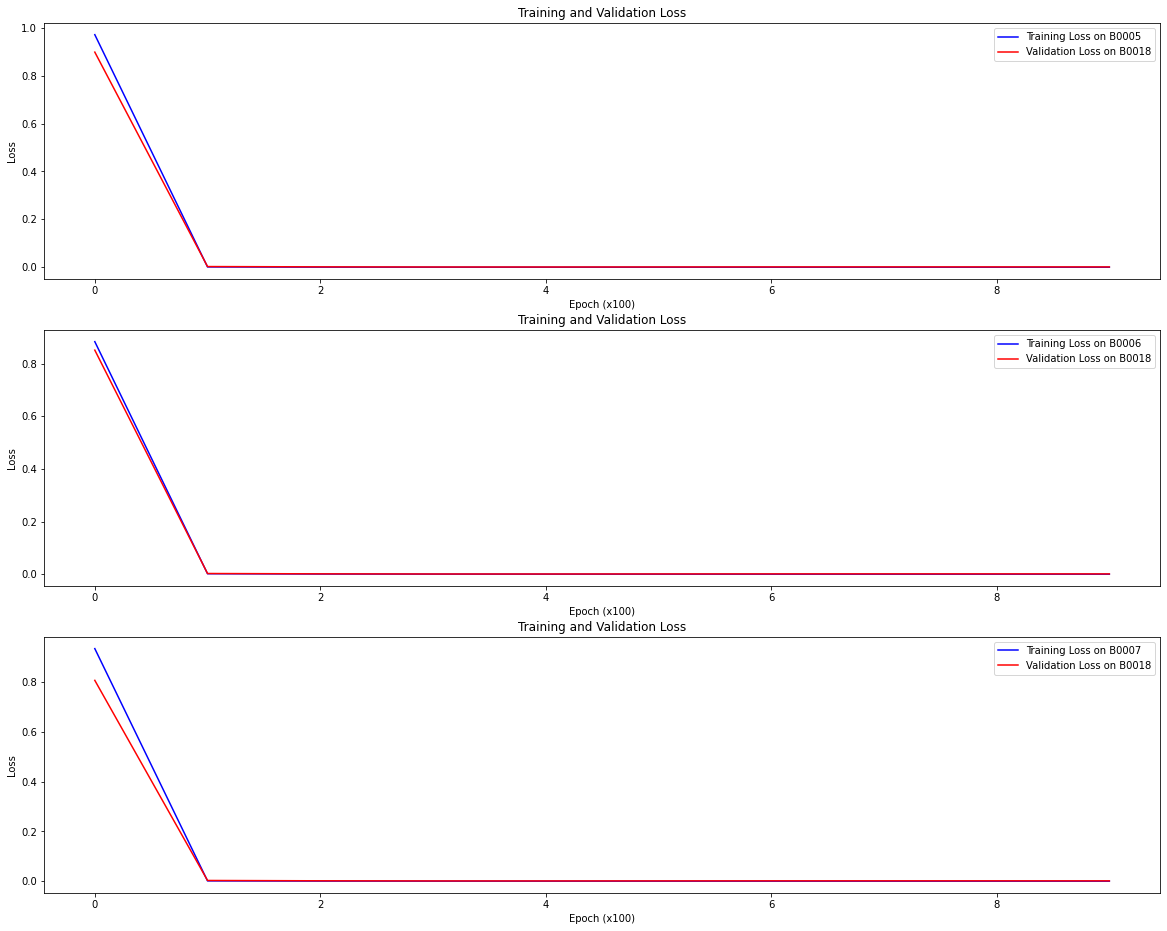

In [ ]:
fig, axs = plt.subplots(3, figsize = (20, 16))
for i, ax in enumerate(axs):
    x1 = list(range(0,len(total_loss[train_names[i]])))
    x2 = list(range(0,len(val_loss[train_names[i]])))
    axs[i].plot(x1, total_loss[train_names[i]], 'b', label="Training Loss on "+train_names[i])
    axs[i].plot(x2, val_loss[train_names[i]], 'r', label="Validation Loss on "+test_name)
    axs[i].legend(loc="upper right")
    axs[i].set(xlabel = 'Epoch (x100)', ylabel='Loss', title='Training and Validation Loss')
plt.legend()


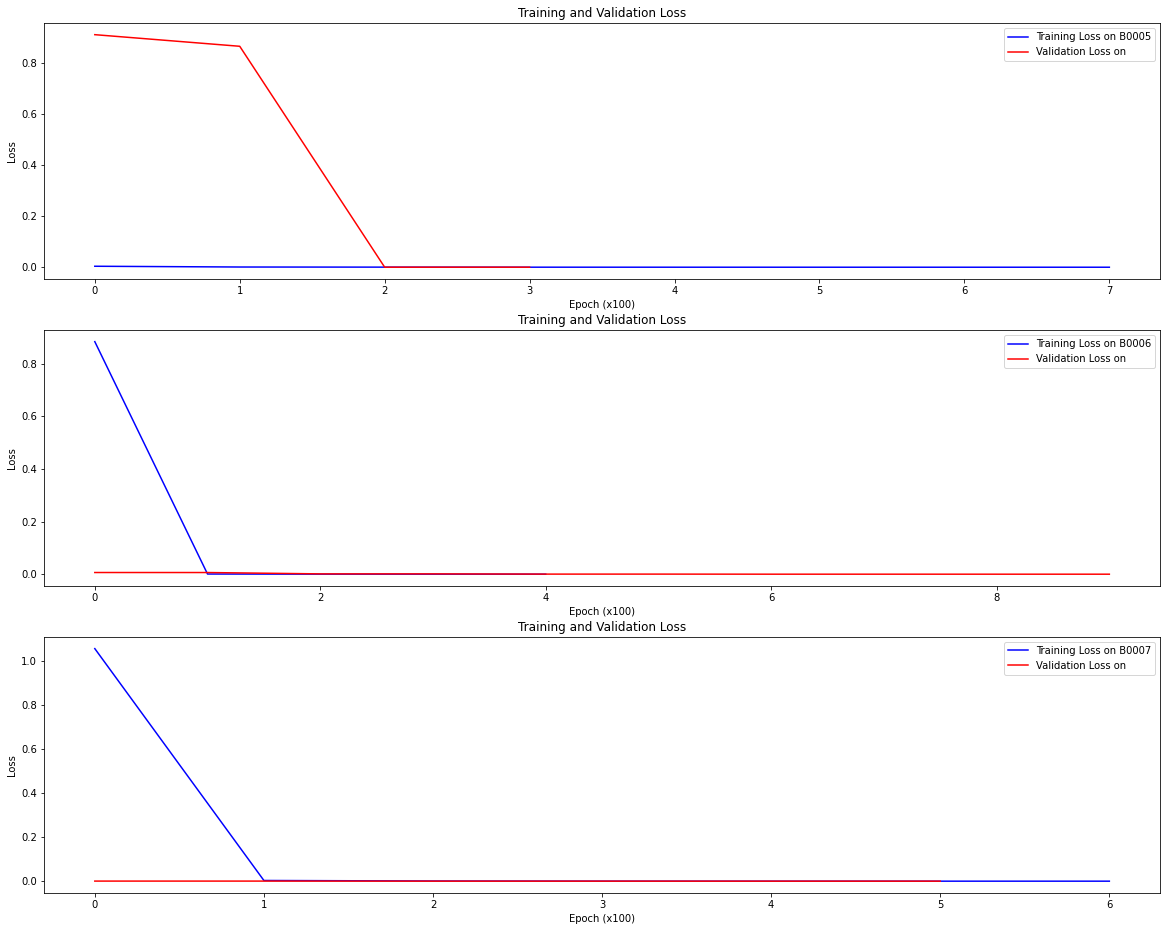

In [ ]:
fig, axs = plt.subplots(3, figsize = (20, 16))
for i, ax in enumerate(axs):
    x1 = list(range(0,len(total_loss[train_names[i]])))
    x2 = list(range(0,len(val_loss[train_names[i]])))
    axs[i].plot(x1, total_loss[train_names[i]], 'b', label="Training Loss on "+train_names[i])
    axs[i].plot(x2, val_loss[train_names[i]], 'r', label="Validation Loss on ")
    axs[i].legend(loc="upper right")
    axs[i].set(xlabel = 'Epoch (x100)', ylabel='Loss', title='Training and Validation Loss')
plt.legend()


### Prediction

Test Loss: 0.0010 | MAE: 0.0360 | MSE: 0.0447 | Accuracy: 0.98
Inference time on cpu: 0.014 seconds
Allocated memory: 2705.8 KiB


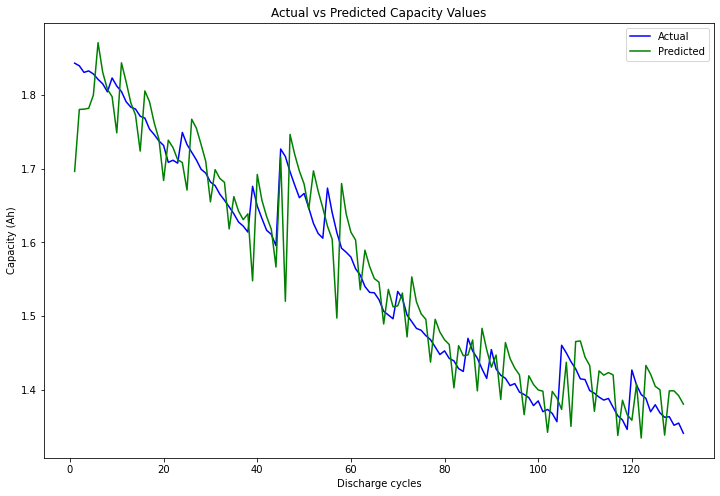

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0018'
test_loss, Y_test, y_pred = test(best_model=best_model_B18,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0014 | MAE: 0.0480 | MSE: 0.0536 | Accuracy: 0.97
Inference time on cuda: 0.069 seconds
Allocated memory: 2890.2 KiB


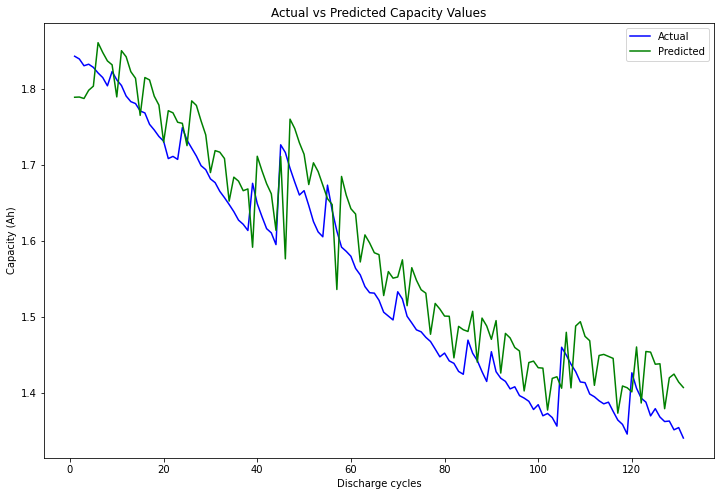

In [ ]:
#prediction leave-one out evaluation
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0018'
test_loss, Y_test, y_pred = test(best_model=model_1,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0007 | MAE: 0.0216 | MSE: 0.0373 | Accuracy: 0.99
Inference time on cuda: 0.030 seconds
Allocated memory: 3961.9 KiB


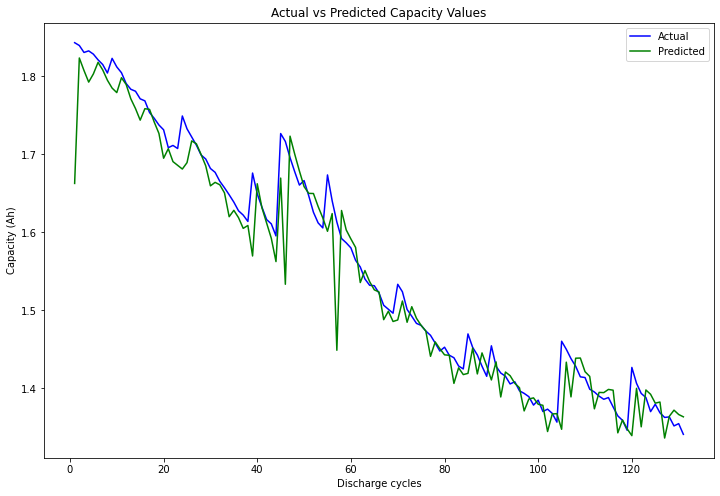

In [ ]:
#prediction leave-one out evaluation
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0018'
test_loss, Y_test, y_pred = test(best_model=model_1,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0013 | MAE: 0.0463 | MSE: 0.0518 | Accuracy: 0.97
Inference time on cuda: 0.052 seconds
Allocated memory: 8058.5 KiB


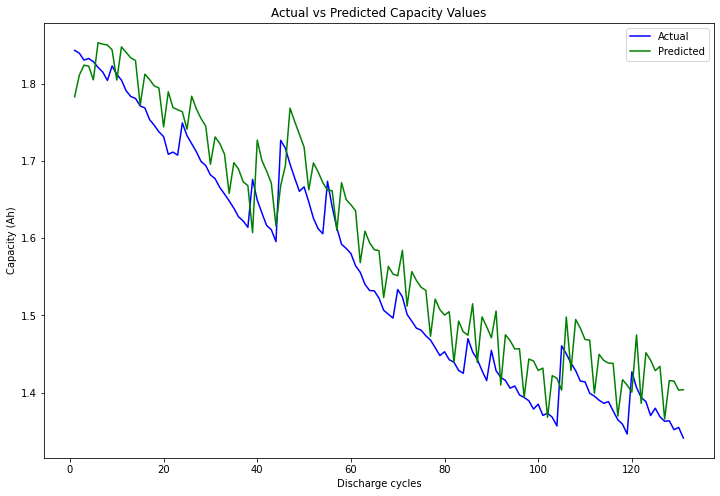

In [ ]:
#prediction leave-one out evaluation
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0018'
test_loss, Y_test, y_pred = test(best_model=model_1,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

### Showing behavior of model on trained sets

Test Loss: 0.0003 | MAE: 0.0182 | MSE: 0.0236 | Accuracy: 0.99
Inference time on cuda: 0.037 seconds
Allocated memory: 4482.4 KiB


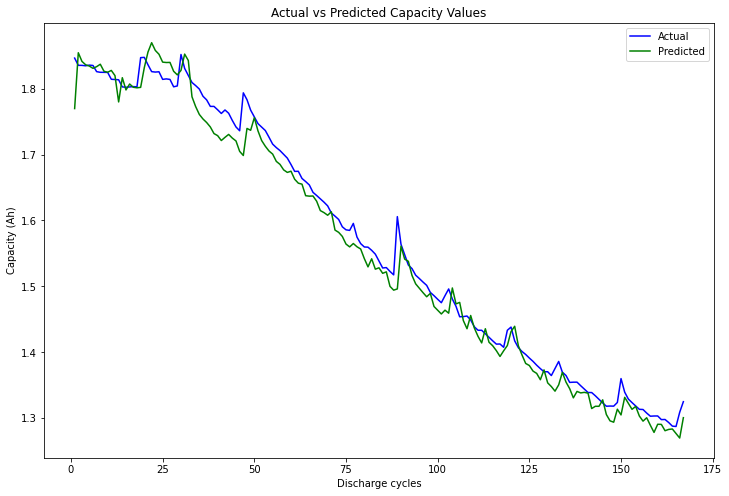

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0005'
test_loss, Y_test, y_pred = test(best_model=model_1,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0004 | MAE: 0.0180 | MSE: 0.0296 | Accuracy: 0.99
Inference time on cuda: 0.057 seconds
Allocated memory: 5111.2 KiB


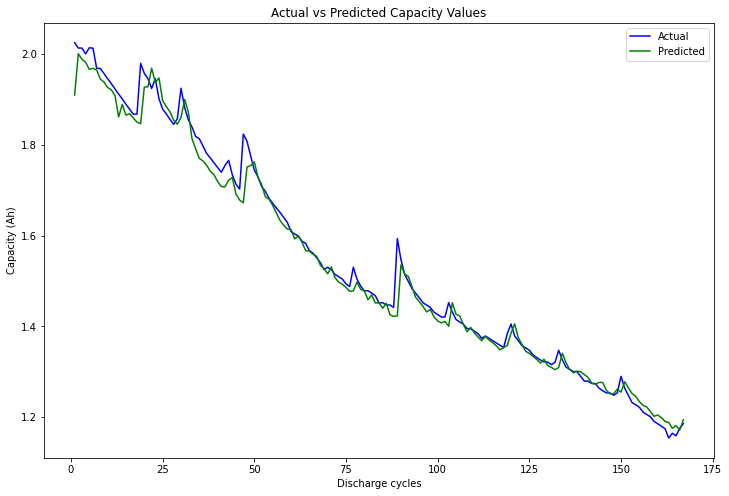

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=model_1,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0001 | MAE: 0.0114 | MSE: 0.0171 | Accuracy: 0.99
Inference time on cpu: 0.037 seconds
Allocated memory: 9584.2 KiB


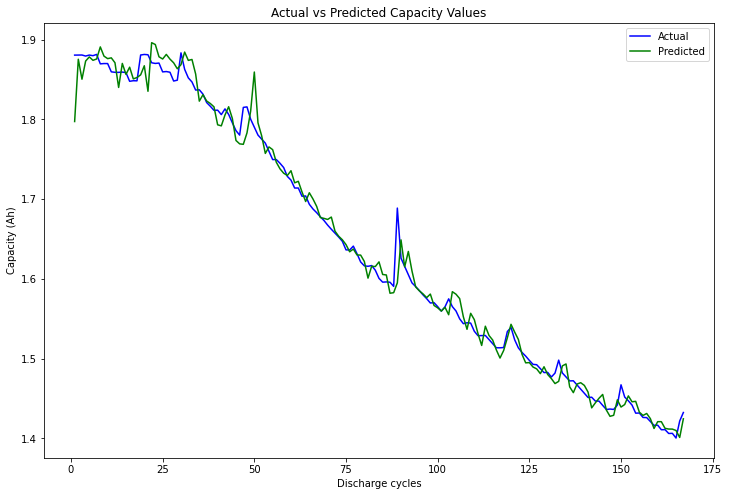

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0007'
test_loss, Y_test, y_pred = test(best_model=best_model_B18,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

In [ ]:
def testv2(best_model, input_data, y_battery, test_name, cap_max, cap_min):
  best_model.eval()
  with torch.inference_mode():
    x_test = torch.tensor(input_data[test_name], dtype=torch.float32)
    y_test = torch.tensor(y_battery[test_name], dtype=torch.float32).unsqueeze(1)
    X_test = x_test.to(device)
    Y_test = y_test.to(device)
    hidden = best_model.init_zero_hidden()
    hidden = hidden.to(device)
    test_out = []
    for i in range(X_test.size()[0]):
      # 1. Forward Pass
      test_output, hidden = best_model(X_test[i], hidden)
      test_out.append(test_output)
      if (i+1) < X_test.size()[0]:
        #print(f"X_test[i+1][-1] before: {X_test[i+1][-1]}")
        X_test[i+1][-1] = (test_output - cap_min) / (cap_max - cap_min)
        #print(f"X_test[i+1][-1] after: {X_test[i+1][-1]}")        
    y_pred = torch.stack(test_out).to(device)
    # 2. Calculate Loss
    test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

Test Loss: 0.0024 | MAE: 0.0561 | MSE: 0.0696 | Accuracy: 0.96
Inference time on cuda: 0.036 seconds
Allocated memory: 14127.0 KiB


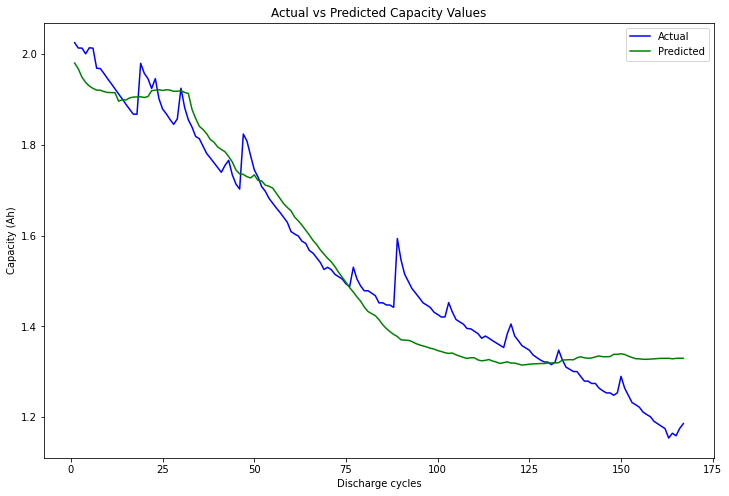

In [ ]:
# timer
start_time = timer()
tracemalloc.start()
cap_max = 2.035337591005598
cap_min = 1.15381833159625
test_name = 'B0006'
test_loss, Y_test, y_pred = testv2(best_model=best_model_B6,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name,
                                 cap_max=cap_max,
                                 cap_min=cap_min)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

## Training Using Datasets B6, B7, B18 and Test on B5

### Training

In [ ]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 10
output_size = 1
model_2 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_2 = model_2.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

In [ ]:
train_names = ['B0006', 'B0007', 'B0018']
test_name = 'B0005'
iterations = 1
total_loss, val_loss, best_model_B5, min_val_loss_B5 = train(model_2, input_data, y_battery, epochs, train_names, test_name, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0006 | Epoch: 0 | Train Loss: 0.944410 | Test Set: B0005 Test Loss: 0.909181
Train Set: B0007 | Epoch: 0 | Train Loss: 0.984674 | Test Set: B0005 Test Loss: 0.864891
Train Set: B0018 | Epoch: 0 | Train Loss: 0.852577 | Test Set: B0005 Test Loss: 0.823274
Train Set: B0006 | Epoch: 100 | Train Loss: 0.002651 | Test Set: B0005 Test Loss: 0.001360
Train Set: B0007 | Epoch: 100 | Train Loss: 0.001256 | Test Set: B0005 Test Loss: 0.001338
Train Set: B0018 | Epoch: 100 | Train Loss: 0.002517 | Test Set: B0005 Test Loss: 0.001332
Train Set: B0006 | Epoch: 200 | Train Loss: 0.000768 | Test Set: B0005 Test Loss: 0.000339
Train Set: B0007 | Epoch: 200 | Train Loss: 0.000391 | Test Set: B0005 Test Loss: 0.000340
Train Set: B0018 | Epoch: 200 | Train Loss: 0.000912 | Test Set: B0005 Test Loss: 0.000338
Train Set: B0006 | Epoch: 300 | Train Loss: 0.000439 | Test Set: B0005 Test Loss: 0.000156
Train Set: B0007 | Epoch: 300 | Train Loss: 0.000165 | Test Set: B0005 Test Loss: 0.000156
Train

In [ ]:
# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0006', 'B0007', 'B0018']
iterations = 1
total_loss, val_loss = trainv2(model_2, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0007 | Epoch: 0 | Train Loss: 1.055372 | Test Set: B0018 Test Loss: 0.898148
Train Set: B0006 | Epoch: 0 | Train Loss: 0.883521 | Test Set: B0018 Test Loss: 0.851624
Train Set: B0018 | Epoch: 100 | Train Loss: 0.004282 | Test Set: B0007 Test Loss: 0.003665
Train Set: B0006 | Epoch: 100 | Train Loss: 0.008526 | Test Set: B0007 Test Loss: 0.003572
Train Set: B0007 | Epoch: 200 | Train Loss: 0.000942 | Test Set: B0006 Test Loss: 0.001438
Train Set: B0018 | Epoch: 200 | Train Loss: 0.001574 | Test Set: B0006 Test Loss: 0.001487
Train Set: B0006 | Epoch: 300 | Train Loss: 0.000754 | Test Set: B0018 Test Loss: 0.000891
Train Set: B0007 | Epoch: 300 | Train Loss: 0.000406 | Test Set: B0018 Test Loss: 0.000897
Train Set: B0007 | Epoch: 400 | Train Loss: 0.000241 | Test Set: B0018 Test Loss: 0.000504
Train Set: B0006 | Epoch: 400 | Train Loss: 0.000497 | Test Set: B0018 Test Loss: 0.000503
Train Set: B0018 | Epoch: 500 | Train Loss: 0.000371 | Test Set: B0006 Test Loss: 0.000402
Tra

### Loss plot

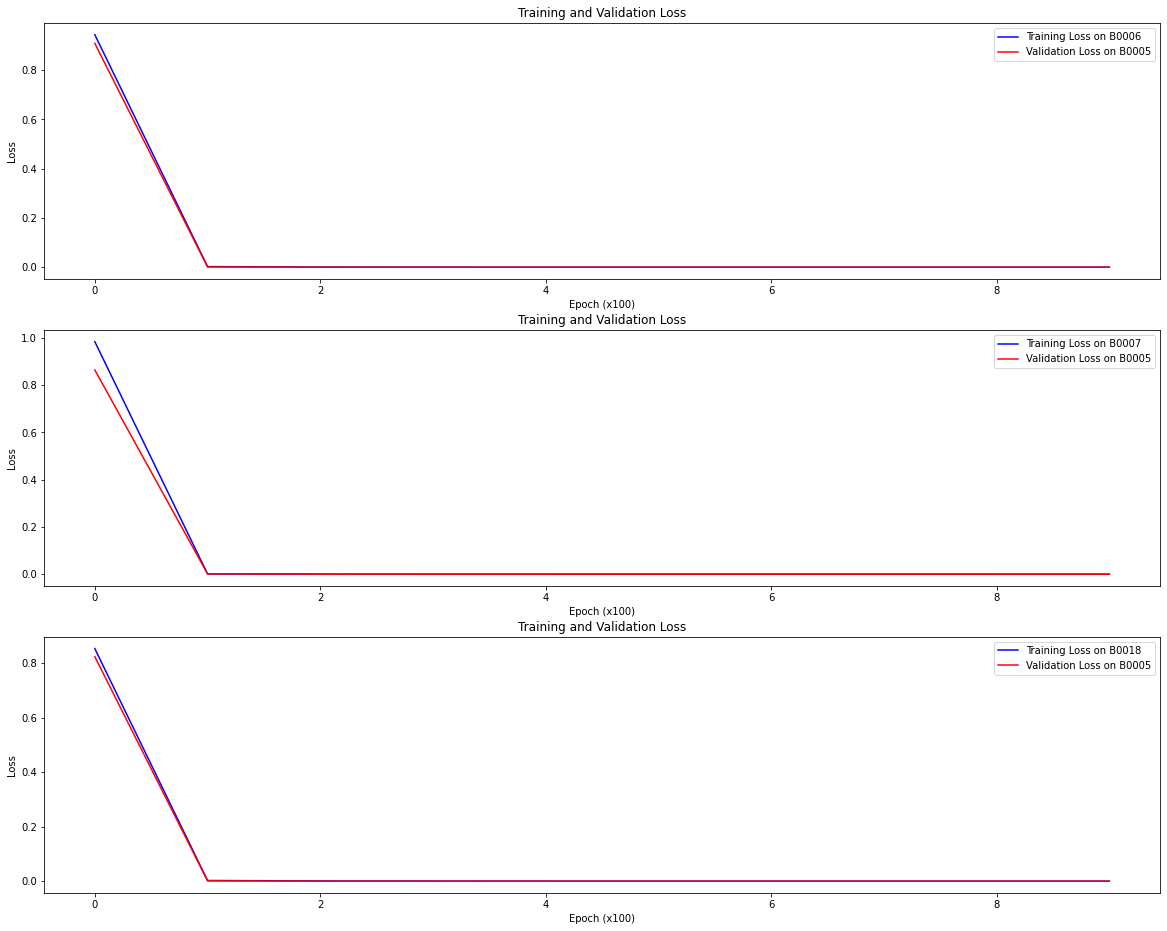

In [ ]:
fig, axs = plt.subplots(3, figsize = (20, 16))
for i, ax in enumerate(axs):
    x1 = list(range(0,len(total_loss[train_names[i]])))
    x2 = list(range(0,len(val_loss[train_names[i]])))
    axs[i].plot(x1, total_loss[train_names[i]], 'b', label="Training Loss on "+train_names[i])
    axs[i].plot(x2, val_loss[train_names[i]], 'r', label="Validation Loss on "+test_name)
    axs[i].legend(loc="upper right")
    axs[i].set(xlabel = 'Epoch (x100)', ylabel='Loss', title='Training and Validation Loss')
plt.legend()


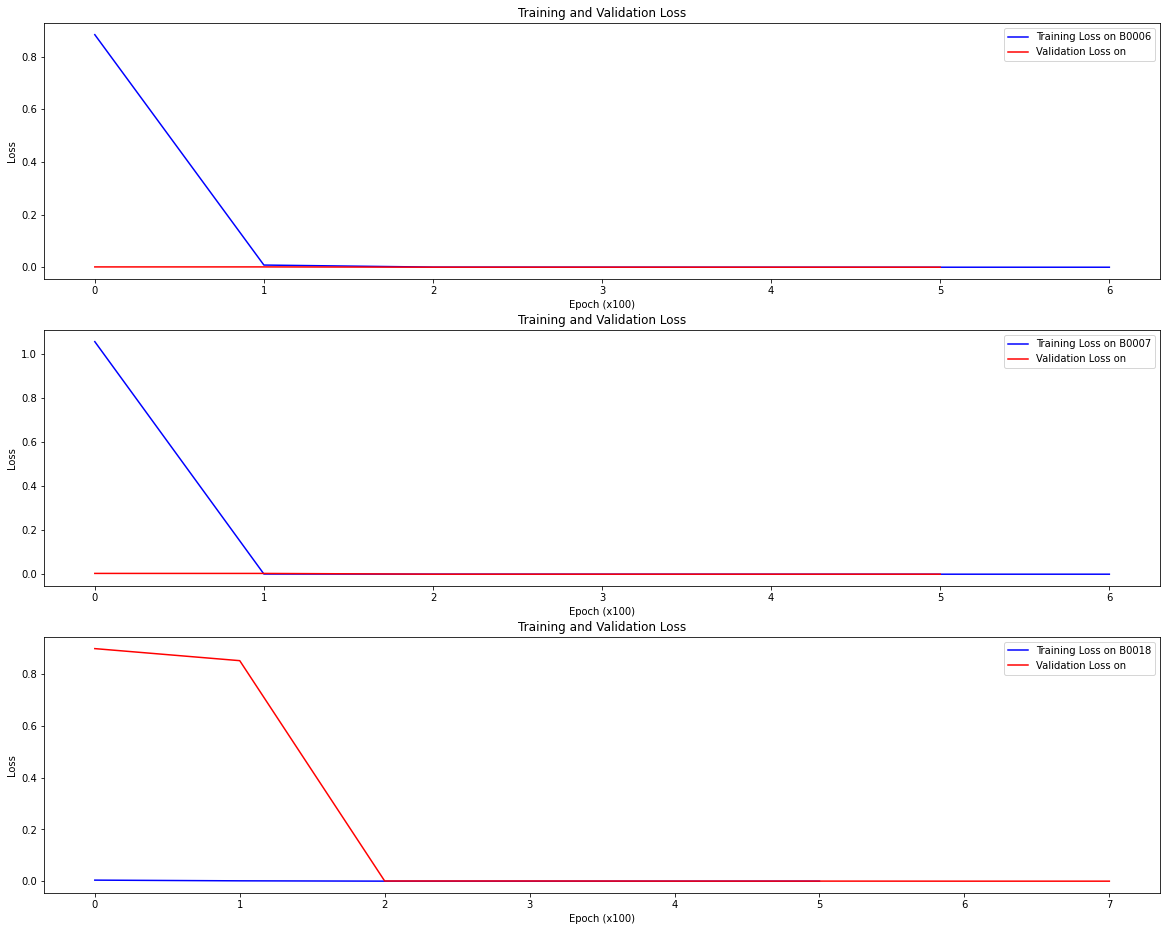

In [ ]:
fig, axs = plt.subplots(3, figsize = (20, 16))
for i, ax in enumerate(axs):
    x1 = list(range(0,len(total_loss[train_names[i]])))
    x2 = list(range(0,len(val_loss[train_names[i]])))
    axs[i].plot(x1, total_loss[train_names[i]], 'b', label="Training Loss on "+train_names[i])
    axs[i].plot(x2, val_loss[train_names[i]], 'r', label="Validation Loss on ")
    axs[i].legend(loc="upper right")
    axs[i].set(xlabel = 'Epoch (x100)', ylabel='Loss', title='Training and Validation Loss')
plt.legend()

### Prediction

Test Loss: 0.0001 | MAE: 0.0076 | MSE: 0.0131 | Accuracy: 1.00
Inference time on cpu: 0.015 seconds
Allocated memory: 5242.3 KiB


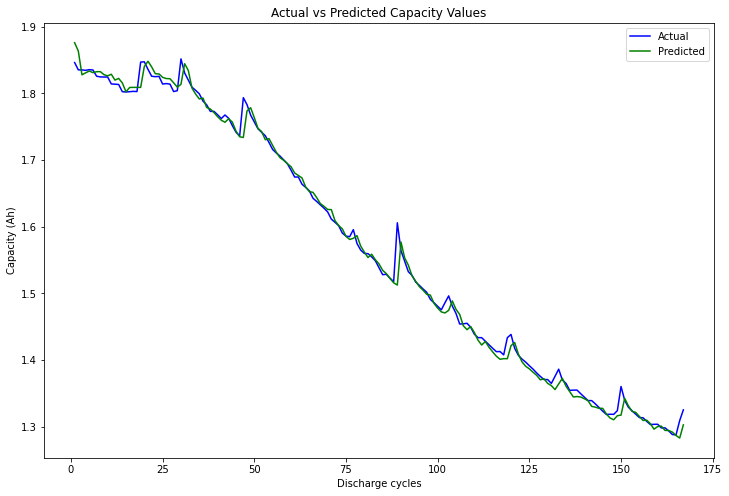

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0005'
test_loss, Y_test, y_pred = test(best_model=best_model_B5,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0001 | MAE: 0.0096 | MSE: 0.0146 | Accuracy: 0.99
Inference time on cuda: 0.039 seconds
Allocated memory: 5441.8 KiB


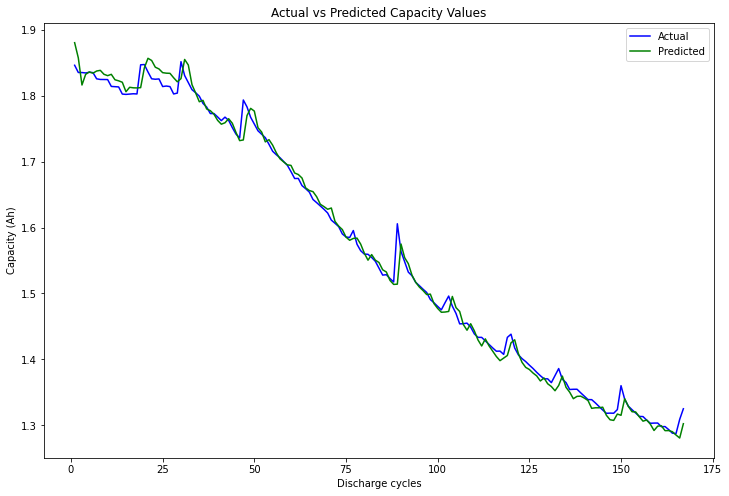

In [ ]:
#prediction leave-one out evaluation
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0005'
test_loss, Y_test, y_pred = test(best_model=model_2,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

### Showing behavior of model on trained sets

Test Loss: 0.0003 | MAE: 0.0120 | MSE: 0.0224 | Accuracy: 0.99
Inference time on cpu: 0.016 seconds
Allocated memory: 5893.6 KiB


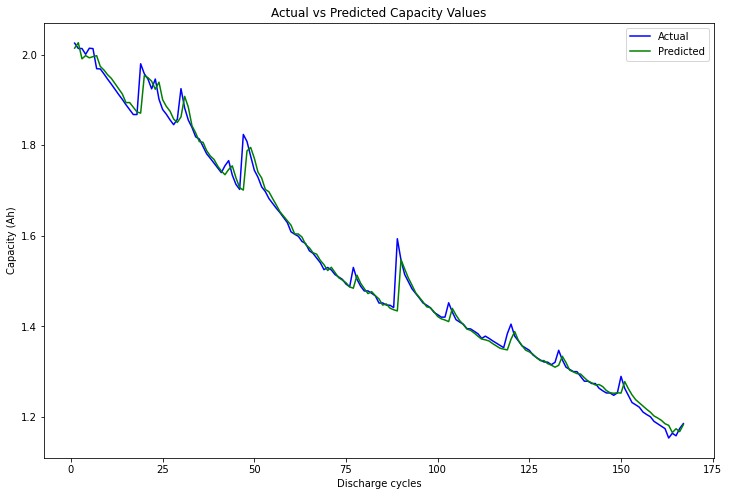

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=best_model_B5,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0001 | MAE: 0.0067 | MSE: 0.0118 | Accuracy: 1.00
Inference time on cpu: 0.473 seconds
Allocated memory: 6245.5 KiB


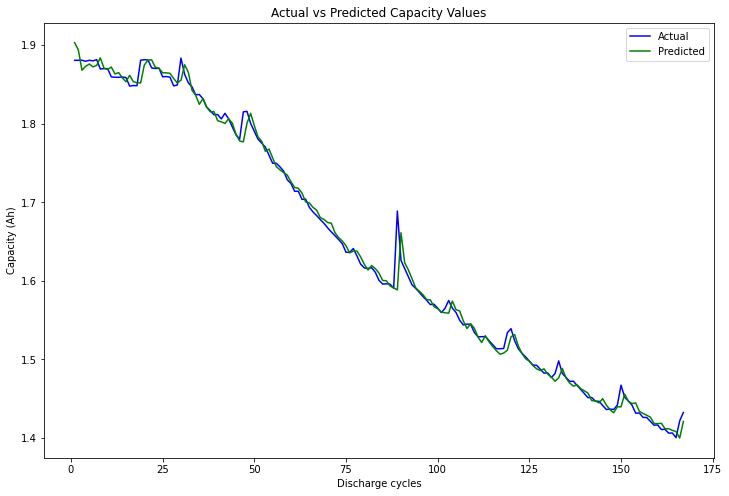

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0007'
test_loss, Y_test, y_pred = test(best_model=best_model_B5,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0002 | MAE: 0.0127 | MSE: 0.0202 | Accuracy: 0.99
Inference time on cpu: 0.017 seconds
Allocated memory: 6899.2 KiB


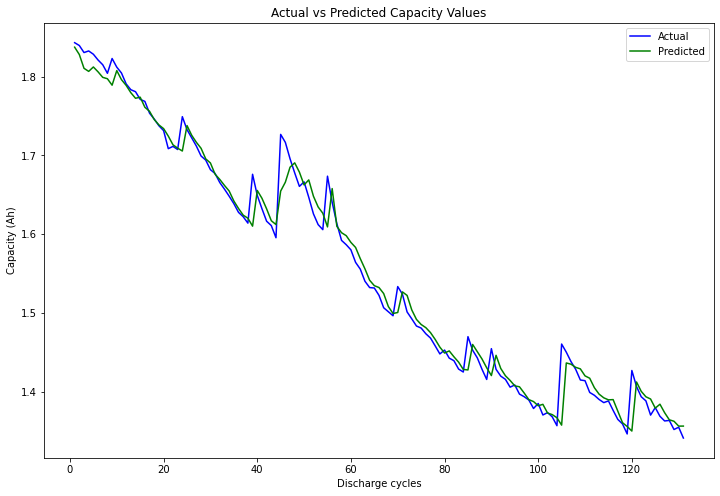

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0018'
test_loss, Y_test, y_pred = test(best_model=best_model_B5,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

## Training Using Datasets B5, B6, B18 and Test on B7

### Training

In [ ]:
from tqdm.auto import tqdm
import sys
torch.manual_seed(42)

input_size = 31
hidden_size = 10
output_size = 1
model_3 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)
model_3 = model_3.to(device)

loss_fn = nn.HuberLoss()
#loss_fn = nn.MSELoss()
learning_rate = 0.005
epochs = 1000
#weight_decay = 1e-4
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate) #, weight_decay=weight_decay)

In [ ]:
train_names = ['B0005', 'B0006', 'B0018']
test_name = 'B0007'
iterations = 1
total_loss, val_loss, best_model_B7, min_val_loss_B7 = train(model_3, input_data, y_battery, epochs, train_names, test_name, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0005 | Epoch: 0 | Train Loss: 0.971007 | Test Set: B0007 Test Loss: 0.984674
Train Set: B0006 | Epoch: 0 | Train Loss: 0.883520 | Test Set: B0007 Test Loss: 0.935527
Train Set: B0018 | Epoch: 0 | Train Loss: 0.851303 | Test Set: B0007 Test Loss: 0.889500
Train Set: B0005 | Epoch: 100 | Train Loss: 0.001167 | Test Set: B0007 Test Loss: 0.001399
Train Set: B0006 | Epoch: 100 | Train Loss: 0.002166 | Test Set: B0007 Test Loss: 0.001353
Train Set: B0018 | Epoch: 100 | Train Loss: 0.002324 | Test Set: B0007 Test Loss: 0.001384
Train Set: B0005 | Epoch: 200 | Train Loss: 0.000345 | Test Set: B0007 Test Loss: 0.000923
Train Set: B0006 | Epoch: 200 | Train Loss: 0.000764 | Test Set: B0007 Test Loss: 0.000901
Train Set: B0018 | Epoch: 200 | Train Loss: 0.000874 | Test Set: B0007 Test Loss: 0.000924
Train Set: B0005 | Epoch: 300 | Train Loss: 0.000155 | Test Set: B0007 Test Loss: 0.000648
Train Set: B0006 | Epoch: 300 | Train Loss: 0.000433 | Test Set: B0007 Test Loss: 0.000646
Train

In [ ]:
# TRAINING USING LEAVE-ONE OUT EVALUATION
train_names = ['B0005', 'B0006', 'B0018']
iterations = 1
total_loss, val_loss = trainv2(model_3, input_data, y_battery, epochs, train_names, iterations)

Iteration: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Train Set: B0006 | Epoch: 0 | Train Loss: 0.944410 | Test Set: B0005 Test Loss: 0.909181
Train Set: B0018 | Epoch: 0 | Train Loss: 0.898148 | Test Set: B0005 Test Loss: 0.864624
Train Set: B0006 | Epoch: 100 | Train Loss: 0.007412 | Test Set: B0018 Test Loss: 0.004109
Train Set: B0005 | Epoch: 100 | Train Loss: 0.004102 | Test Set: B0018 Test Loss: 0.004109
Train Set: B0005 | Epoch: 200 | Train Loss: 0.000639 | Test Set: B0018 Test Loss: 0.001580
Train Set: B0006 | Epoch: 200 | Train Loss: 0.001233 | Test Set: B0018 Test Loss: 0.001606
Train Set: B0018 | Epoch: 300 | Train Loss: 0.000886 | Test Set: B0006 Test Loss: 0.000723
Train Set: B0005 | Epoch: 300 | Train Loss: 0.000328 | Test Set: B0006 Test Loss: 0.000721
Train Set: B0018 | Epoch: 400 | Train Loss: 0.000501 | Test Set: B0006 Test Loss: 0.000500
Train Set: B0005 | Epoch: 400 | Train Loss: 0.000186 | Test Set: B0006 Test Loss: 0.000498
Train Set: B0006 | Epoch: 500 | Train Loss: 0.000385 | Test Set: B0018 Test Loss: 0.000367
Tra

### Loss plot

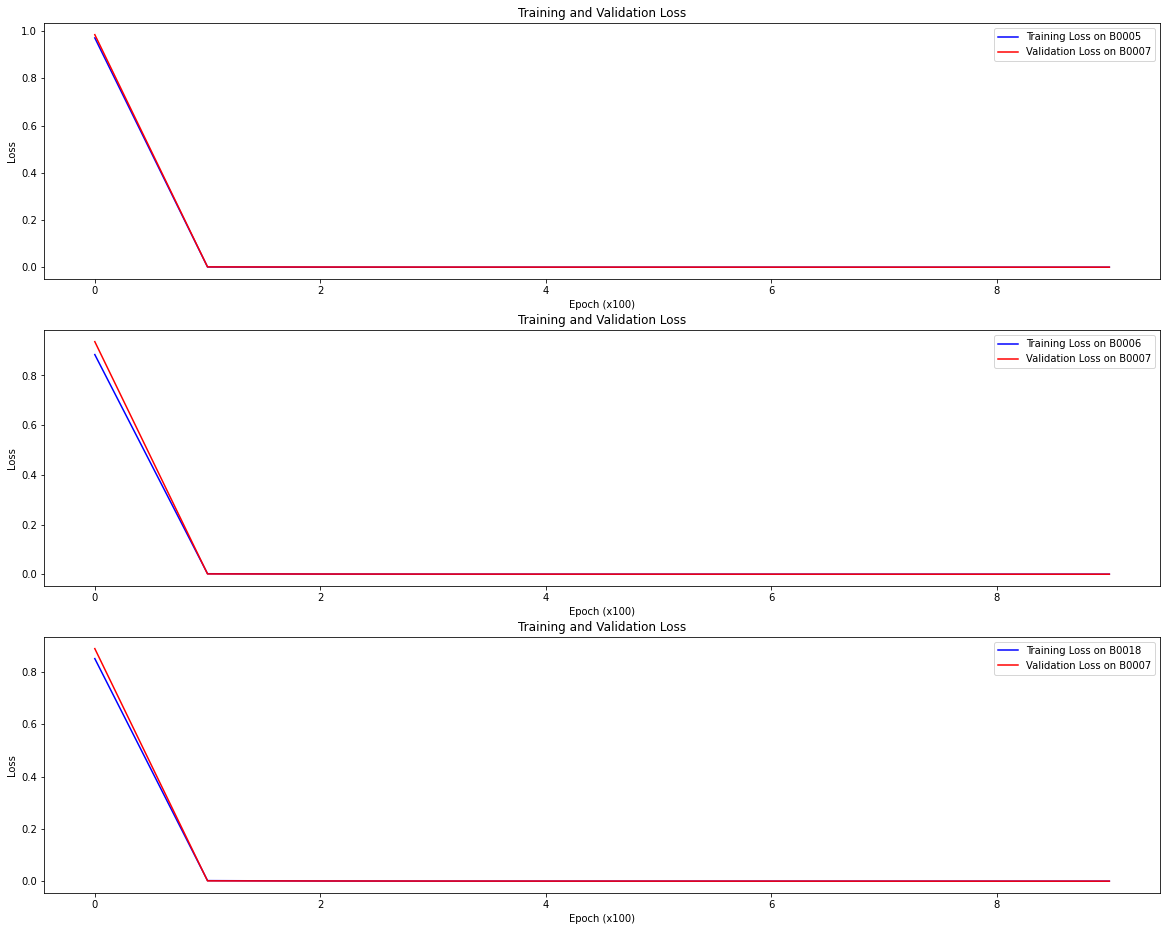

In [ ]:
fig, axs = plt.subplots(3, figsize = (20, 16))
for i, ax in enumerate(axs):
    x1 = list(range(0,len(total_loss[train_names[i]])))
    x2 = list(range(0,len(val_loss[train_names[i]])))
    axs[i].plot(x1, total_loss[train_names[i]], 'b', label="Training Loss on "+train_names[i])
    axs[i].plot(x2, val_loss[train_names[i]], 'r', label="Validation Loss on "+test_name)
    axs[i].legend(loc="upper right")
    axs[i].set(xlabel = 'Epoch (x100)', ylabel='Loss', title='Training and Validation Loss')
plt.legend()


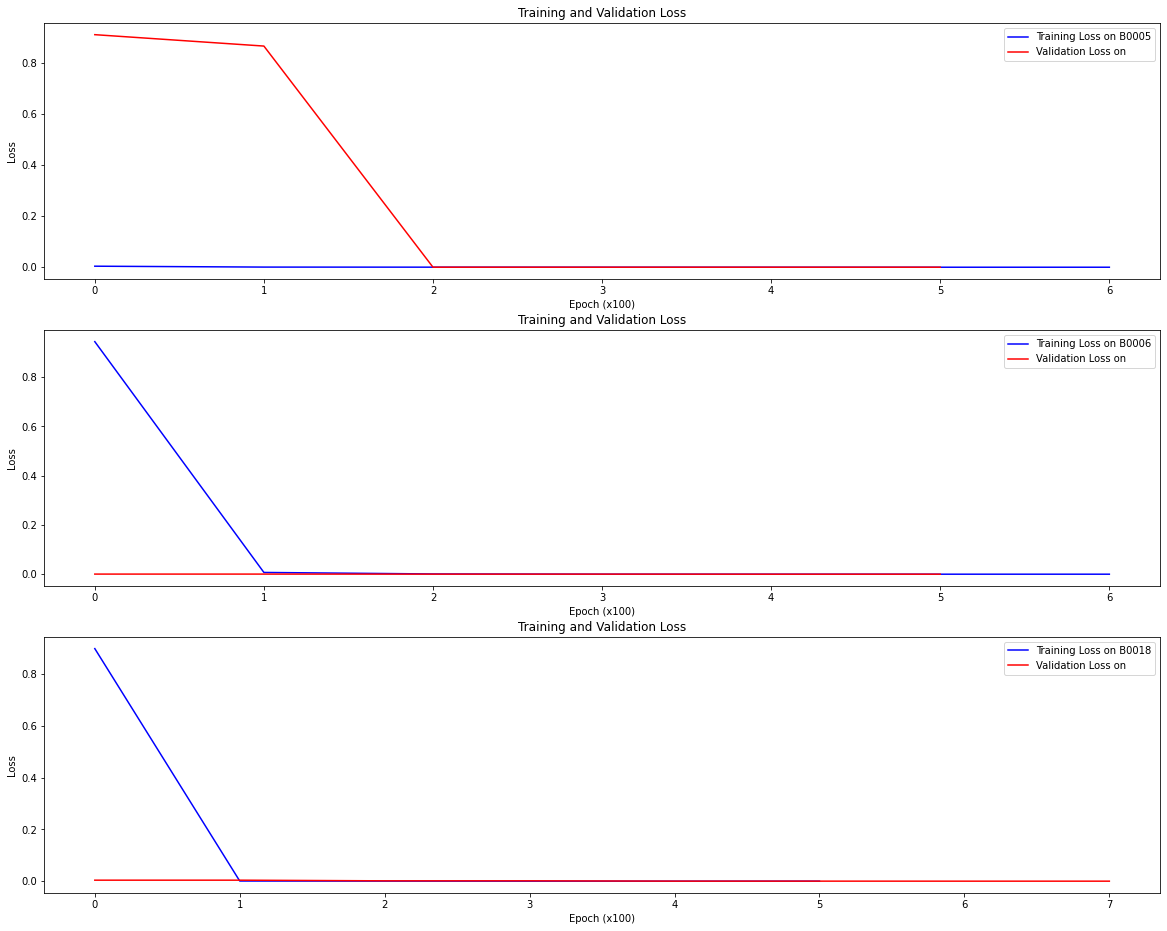

In [ ]:
fig, axs = plt.subplots(3, figsize = (20, 16))
for i, ax in enumerate(axs):
    x1 = list(range(0,len(total_loss[train_names[i]])))
    x2 = list(range(0,len(val_loss[train_names[i]])))
    axs[i].plot(x1, total_loss[train_names[i]], 'b', label="Training Loss on "+train_names[i])
    axs[i].plot(x2, val_loss[train_names[i]], 'r', label="Validation Loss on ")
    axs[i].legend(loc="upper right")
    axs[i].set(xlabel = 'Epoch (x100)', ylabel='Loss', title='Training and Validation Loss')
plt.legend()

### Prediction

Test Loss: 0.0003 | MAE: 0.0213 | MSE: 0.0231 | Accuracy: 0.99
Inference time on cpu: 0.016 seconds
Allocated memory: 9478.8 KiB


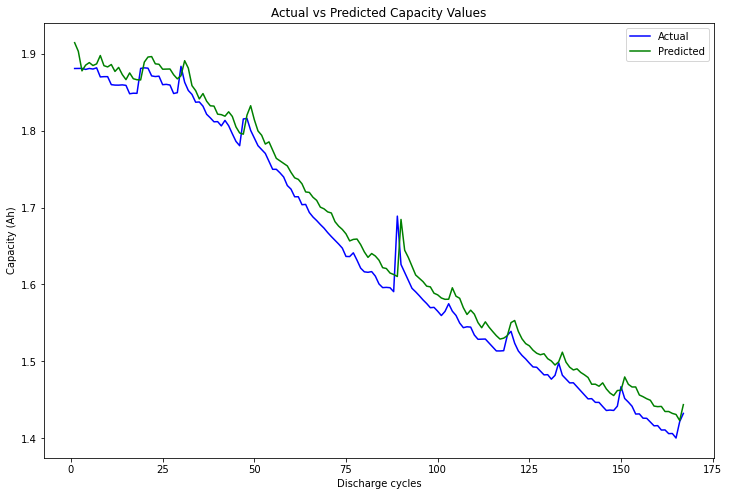

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0007'
test_loss, Y_test, y_pred = test(best_model=best_model_B7,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0004 | MAE: 0.0249 | MSE: 0.0267 | Accuracy: 0.98
Inference time on cuda: 0.026 seconds
Allocated memory: 7966.0 KiB


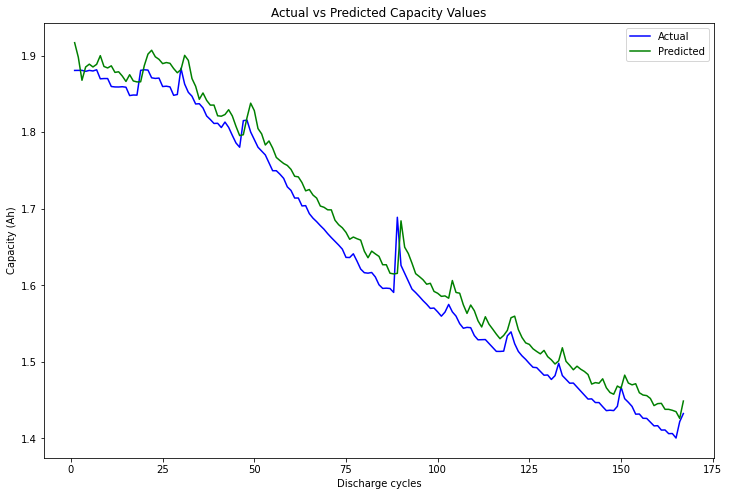

In [ ]:
#prediction leave-one out evaluation
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0007'
test_loss, Y_test, y_pred = test(best_model=model_3,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

### Showing behavior of model on trained sets

Test Loss: 0.0001 | MAE: 0.0070 | MSE: 0.0126 | Accuracy: 1.00
Inference time on cpu: 0.016 seconds
Allocated memory: 10108.5 KiB


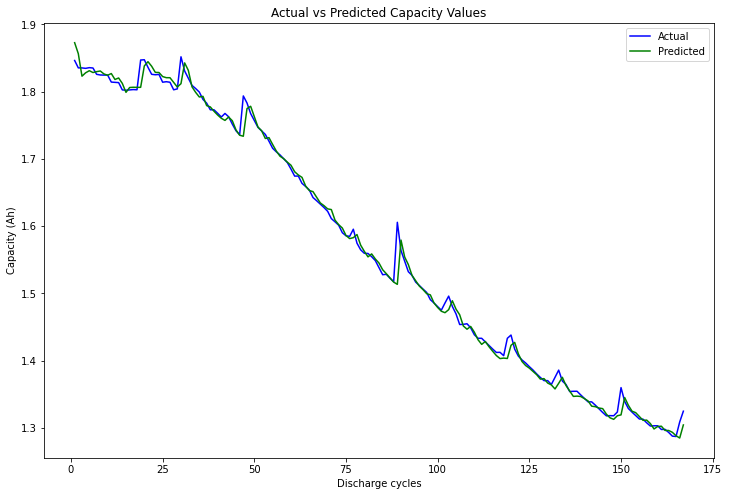

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0005'
test_loss, Y_test, y_pred = test(best_model=best_model_B7,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0002 | MAE: 0.0117 | MSE: 0.0223 | Accuracy: 0.99
Inference time on cpu: 0.023 seconds
Allocated memory: 10748.6 KiB


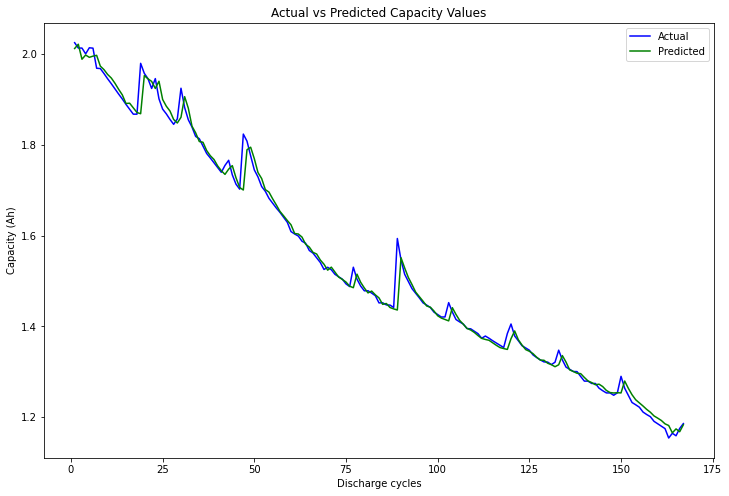

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=best_model_B7,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

Test Loss: 0.0002 | MAE: 0.0125 | MSE: 0.0202 | Accuracy: 0.99
Inference time on cpu: 0.014 seconds
Allocated memory: 11385.6 KiB


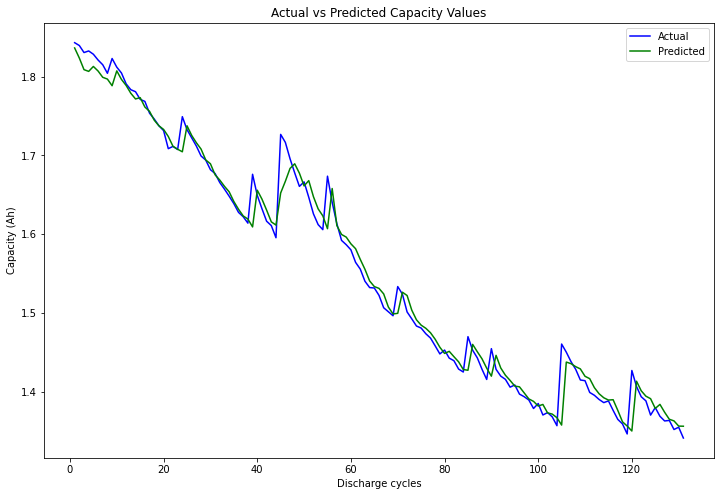

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0018'
test_loss, Y_test, y_pred = test(best_model=best_model_B7,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

## Save `model.state_dict()`

Saving models `state_dict` to be uploaded to the edge device

### Best model state_dicts

In [ ]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAMES = ['RNN_NASAvB5.pth', 'RNN_NASAvB6.pth', 'RNN_NASAvB7.pth', 'RNN_NASAvB18.pth'] 
state_dicts = [best_model_B5.state_dict(), best_model_B6.state_dict(), best_model_B7.state_dict(), best_model_B18.state_dict()]


# 3. Save the model state dict 
for model_name, state_model in zip(MODEL_NAMES, state_dicts):
    MODEL_SAVE_PATH = MODEL_PATH / model_name
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=state_model, # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/RNN_NASAvB5.pth
Saving model to: models/RNN_NASAvB6.pth
Saving model to: models/RNN_NASAvB7.pth
Saving model to: models/RNN_NASAvB18.pth


### Leave-One-Out Cross Evaluation Models

In [ ]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAMES = ['RNN_NASAvB5.pth', 'RNN_NASAvB6.pth', 'RNN_NASAvB7.pth', 'RNN_NASAvB18.pth'] 
state_dicts = [model_2.state_dict(), model_0.state_dict(), model_3.state_dict(), model_1.state_dict()]


# 3. Save the model state dict 
for model_name, state_model in zip(MODEL_NAMES, state_dicts):
    MODEL_SAVE_PATH = MODEL_PATH / model_name
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=state_model, # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/RNN_NASAvB5.pth
Saving model to: models/RNN_NASAvB6.pth
Saving model to: models/RNN_NASAvB7.pth
Saving model to: models/RNN_NASAvB18.pth


## Load saved `model.state_dict()`

### Load ModelB6

In [ ]:
MODEL_SAVE_PATHS_B6 = 'models/RNN_NASAvB6.pth'
MODEL_SAVE_PATHS_B18 = 'models/RNN_NASAvB18.pth'

# Instantiate a new instance of our model (this will be instantiated with random weights)
torch.manual_seed(42)
input_size = 31
hidden_size = 10
output_size = 1
loadedmodelvB6 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loadedmodelvB6.load_state_dict(torch.load(f=MODEL_SAVE_PATHS_B6))
loadedmodelvB6.to(device)

RNNModel(
  (i2h): Linear(in_features=31, out_features=10, bias=False)
  (h2h): Linear(in_features=10, out_features=10, bias=True)
  (h2o): Linear(in_features=10, out_features=1, bias=True)
)

Test Loss: 0.0004 | MAE: 0.0184 | MSE: 0.0299 | Accuracy: 0.99
Inference time on cpu: 0.020 seconds
Allocated memory: 13837.9 KiB


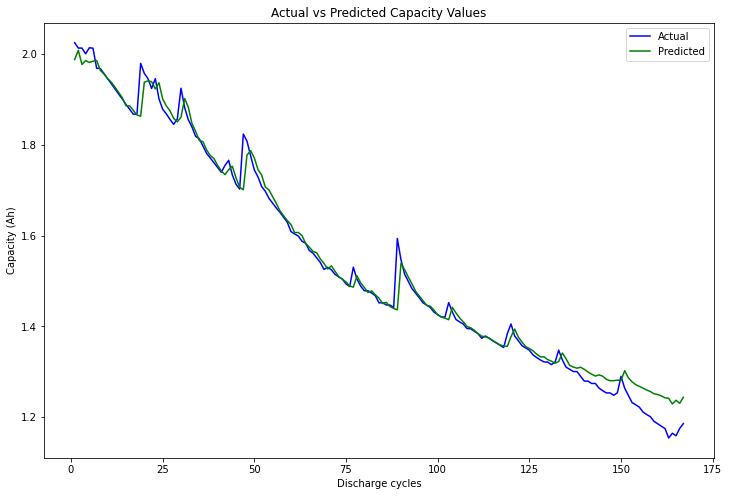

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0006'
test_loss, Y_test, y_pred = test(best_model=loadedmodelvB6,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

### Load ModelB18

In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
torch.manual_seed(42)
input_size = 31
hidden_size = 10
output_size = 1
loadedmodelvB18 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loadedmodelvB18.load_state_dict(torch.load(f=MODEL_SAVE_PATHS_B18))
loadedmodelvB18.to(device)

RNNModel(
  (i2h): Linear(in_features=31, out_features=10, bias=False)
  (h2h): Linear(in_features=10, out_features=10, bias=True)
  (h2o): Linear(in_features=10, out_features=1, bias=True)
)

Test Loss: 0.0010 | MAE: 0.0360 | MSE: 0.0447 | Accuracy: 0.98
Inference time on cpu: 0.013 seconds
Allocated memory: 14493.5 KiB


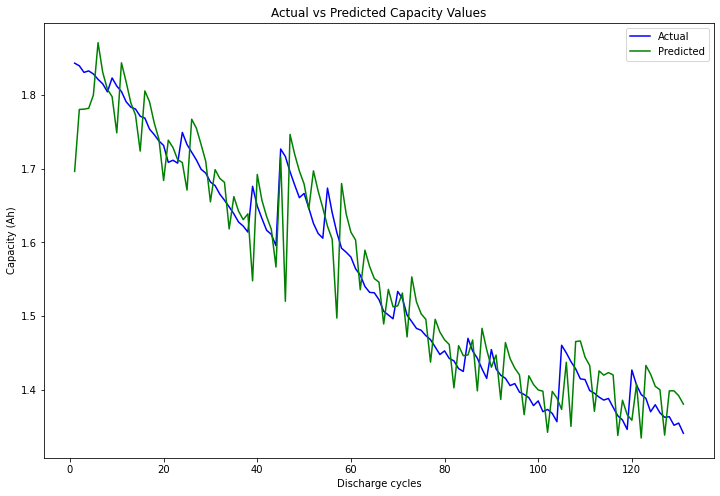

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0018'
test_loss, Y_test, y_pred = test(best_model=loadedmodelvB18,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

### Loaded ModelB5

In [ ]:
MODEL_SAVE_PATHS_B5 = 'models/RNN_NASAvB5.pth'

# Instantiate a new instance of our model (this will be instantiated with random weights)
torch.manual_seed(42)
input_size = 31
hidden_size = 10
output_size = 1
loadedmodelvB5 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loadedmodelvB5.load_state_dict(torch.load(f=MODEL_SAVE_PATHS_B5))
loadedmodelvB5.to(device)

RNNModel(
  (i2h): Linear(in_features=31, out_features=10, bias=False)
  (h2h): Linear(in_features=10, out_features=10, bias=True)
  (h2o): Linear(in_features=10, out_features=1, bias=True)
)

Test Loss: 0.0001 | MAE: 0.0076 | MSE: 0.0131 | Accuracy: 1.00
Inference time on cpu: 0.023 seconds
Allocated memory: 14489.1 KiB


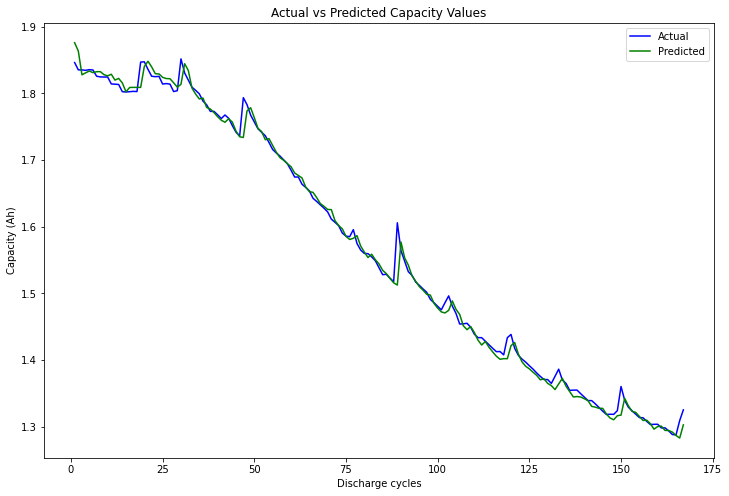

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0005'
test_loss, Y_test, y_pred = test(best_model=loadedmodelvB5,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

### Loaded ModelB7

In [ ]:
MODEL_SAVE_PATHS_B7 = 'models/RNN_NASAvB7.pth'

# Instantiate a new instance of our model (this will be instantiated with random weights)
torch.manual_seed(42)
input_size = 31
hidden_size = 10
output_size = 1
loadedmodelvB7 = RNNModel(input_size=input_size, 
                     hidden_size=hidden_size, 
                     output_size=output_size)

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loadedmodelvB7.load_state_dict(torch.load(f=MODEL_SAVE_PATHS_B7))
loadedmodelvB7.to(device)

RNNModel(
  (i2h): Linear(in_features=31, out_features=10, bias=False)
  (h2h): Linear(in_features=10, out_features=10, bias=True)
  (h2o): Linear(in_features=10, out_features=1, bias=True)
)

Test Loss: 0.0003 | MAE: 0.0213 | MSE: 0.0231 | Accuracy: 0.99
Inference time on cpu: 0.022 seconds
Allocated memory: 15131.9 KiB


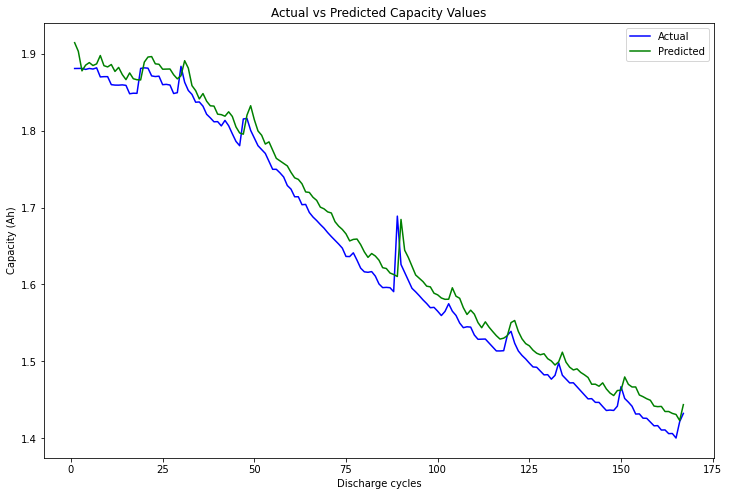

In [ ]:
# timer
start_time = timer()
tracemalloc.start()

test_name = 'B0007'
test_loss, Y_test, y_pred = test(best_model=loadedmodelvB7,
                                 input_data=input_data,
                                 y_battery=y_battery,
                                 test_name=test_name)

acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

end_time = timer()
snapshot = tracemalloc.take_snapshot()

print_inference_time(start_time, end_time, device)
memory_stats(snapshot)
y_pred = y_pred.cpu().detach().numpy().squeeze()
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
y = list(range(1, len(y_pred)+1))
ax.plot(y, y_battery[test_name], 'b', label='Actual')
ax.plot(y, y_pred, 'g', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

## Inference scripts

### Inference on B5 Dataset

Test Loss: 0.0001 | MAE: 0.0076 | MSE: 0.0131 | Accuracy: 1.00
Inference time on cpu: 85.318 seconds
Allocated memory: 46870.5 KiB


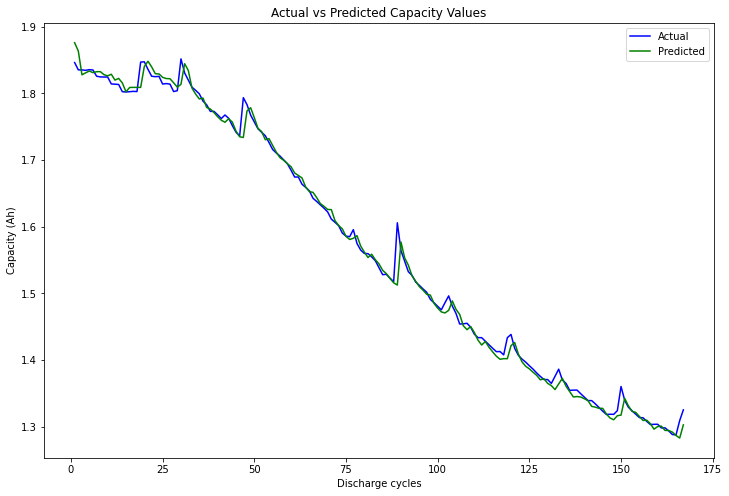

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy 
import scipy.io 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from collections import Counter


class InferenceProcessing():
    def __init__(self, 
                 path, 
                 test_name, 
                 max_voltage,
                 min_voltage,
                 max_current,
                 min_current,
                 max_temp,
                 min_temp,
                 max_cap,
                 min_cap):
        self.path = path
        self.name = test_name
        self.vmax, self.vmin = max_voltage, min_voltage
        self.cmax, self.cmin = max_current, min_current
        self.tmax, self.tmin = max_temp, min_temp
        self.capmax, self.capmin = max_cap, min_cap

    def MultiChannelIP(self):
        test_name = self.name
        path = self.path

        battery_val = {}
        charge_data = {}
        file_path = path + test_name + '.mat'
        data = self.loadMat_to_Dict(file_path)
        battery_val[test_name] = self.getDischargeCapacity(data)
        charge_data[test_name] = self.getChargeData(data)

        # Normalizing Charge Profiles
        Charge_Profile = self.NormalizeData(Charge_Data=charge_data,
                                            battery_name=test_name)
        
        # Sampling Charge Profiles
        Voltage_Measured = self.ChargeDataSampling(Charge_Data=Charge_Profile,
                                                   battery_name=test_name,
                                                   param_type='Voltage_measured',
                                                   sample_size=10)
        Current_Measured = self.ChargeDataSampling(Charge_Data=Charge_Profile,
                                                   battery_name=test_name,
                                                   param_type='Current_measured',
                                                   sample_size=10)
        Temperature_Measured = self.ChargeDataSampling(Charge_Data=Charge_Profile,
                                                   battery_name=test_name,
                                                   param_type='Temperature_measured',
                                                   sample_size=10)

        # Normalizing Capacity Deg Data
        Capacity = self.NormalizeCapacityData(battery_val=battery_val, 
                                              battery_name=test_name)
        
        # Producing 31-Dimension Input...
        Input_Data = self.concatCPandCap(Voltage_Measured=Voltage_Measured,
                                         Current_Measured=Current_Measured,
                                         Temperature_Measured=Temperature_Measured,
                                         Capacity=Capacity,
                                         battery_name=test_name)
        return Input_Data, Capacity, battery_val

    # function to load the .mat data and transform to dict
    def loadMat_to_Dict(self, matfile):
        raw_data = scipy.io.loadmat(matfile)

        # get filename 
        filename = matfile.split("/")[-1].split(".")[0]
         
        col = raw_data[filename]
        # getting 'data'
        col = col[0][0][0][0]
        col_size = col.shape[0]

        data = []
        for i in range(col_size):
            labels = list(col[i][3][0].dtype.fields.keys())
            dict1, dict2 = {}, {}
            if str(col[i][0][0]) != 'impedance':
                for j in range(len(labels)):
                    arr_val = col[i][3][0][0][j][0]
                    val = [arr_val[m] for m in range(len(arr_val))]
                    dict2[labels[j]] = val

            dict1['type'], dict1['temp'], dict1['time'], dict1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(self.datestring_to_time(col[i][2][0])), dict2
            data.append(dict1)

        return data

    # convert time_string to datatime
    def datestring_to_time(self, dates):
        year, month, day, hour, minute, second = int(dates[0]), int(dates[1]), int(dates[2]), int(dates[3]), int(dates[4]), int(dates[5])
        return datetime(year=year,
                        month=month,
                        day=day,
                        hour=hour,
                        minute=minute,
                        second=second)
    
    # function to get capacity data
    def getDischargeCapacity(self, battery):
        cycle, capacity = [], []
        i = 1
        for bat in battery:
            if bat['type'] == 'discharge':
                capacity.append(bat['data']['Capacity'][0])
                cycle.append(i)
                i += 1
        return [cycle, capacity]
    
    # function to get the charge data of the battery
    def getChargeData(self, battery, type='charge'):
        data = []
        for bat in battery:
            if bat['type'] == type:
                data.append(bat['data'])
        return data

    # Normalization function of charging profile parameters
    def NormalizeData(self, Charge_Data, battery_name):
        charge_profile = {}
        parameters = ['Voltage_measured', 'Current_measured', 'Temperature_measured']
        # call function to clean charge profile 
        df = self.CleanCharge_Profile(Charge_Data, battery_name, parameters)

        # normalize voltage values
        for i in range(len(df[battery_name])):
            for j in range(len(df[battery_name][i][parameters[0]])):
                df[battery_name][i][parameters[0]][j] = (df[battery_name][i][parameters[0]][j] - self.vmin) / (self.vmax - self.vmin)
            
            for k in range(len(df[battery_name][i][parameters[1]])):
                df[battery_name][i][parameters[1]][k] = (df[battery_name][i][parameters[1]][k] - self.cmin) / (self.cmax - self.cmin)

            for l in range(len(df[battery_name][i][parameters[2]])):
                df[battery_name][i][parameters[2]][l] = (df[battery_name][i][parameters[2]][l] - self.tmin) / (self.tmax - self.tmin)
        
        return df

    # function to clean charge_profile
    def CleanCharge_Profile(self, Charge_Data, battery_name, parameters):
        df = copy.deepcopy(Charge_Data)
        df[battery_name].pop(32) # drop index 32 measurement exhibit unusual behavior
        df[battery_name].pop(-1) # drop last index; few datapoints

        for params in parameters:
            for i in range(len(df[battery_name])):
                # drop nan values
                df[battery_name][i][params] = [val for val in df[battery_name][i][params] if not(math.isnan(val)) == True]
        
        return df
    
    def ChargeDataSampling(self, Charge_Data, battery_name, param_type, sample_size):
        sampled_dict = {}
        df = copy.deepcopy(Charge_Data[battery_name])
            # remove first and last charging cycle due to few data points
            #df.pop(0) # first list element
            #df.pop(-1) # second list element

        samples = []
        for i in range(len(df)):
            raw_list = list(df[i][param_type])
            sampled_list = self.SystematicSampling(raw_list, sample_size)
            samples.append(sampled_list)
        
            sampled_dict[battery_name] = samples
        return sampled_dict
    
    # function to get charging profile samples using systemating sampling
    def SystematicSampling(self, a_list, sample_size):
        population = len(a_list)
        step = math.ceil(population/sample_size)
        selected_index = np.arange(1, population, step)
        samples = []
        for i in range(len(selected_index)):
            selected_sample = a_list[selected_index[i]]
            samples.append(selected_sample)
        return samples

    def NormalizeCapacityData(self, battery_val, battery_name):
        capacity = {}
        cap_max = self.capmax
        cap_min = self.capmin

        df = copy.deepcopy(battery_val[battery_name][1])
        for i in range(len(df)):
            df[i] = (df[i] - cap_min) / (cap_max - cap_min)
        
        capacity[battery_name] = df
        return capacity
    
    # Function to produce Inputs for testing
    def concatCPandCap(self, Voltage_Measured, Current_Measured, Temperature_Measured, Capacity, battery_name):
        Input31Dim = {}
        V = Voltage_Measured[battery_name]
        V.pop(-1)
        C = Current_Measured[battery_name]
        C.pop(-1)
        T = Temperature_Measured[battery_name]
        T.pop(-1)
        Cap = Capacity[battery_name]
        Cap.pop(-1)
        
        inputs = []
        for i in range(len(V)):
            onediminput = [*V[i], *C[i], *T[i], Cap[i]]
            inputs.append(onediminput)

        Input31Dim[battery_name] = inputs
        return Input31Dim
    
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Metrics
# Compute for accuracy
def accuracy(y_test, y_pred):
  error = np.abs(y_pred-y_test)/y_test
  acc = np.ones_like(error) - error
  acc = np.sum(acc)/len(y_pred)
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
  """
  Prints difference between start and end time
  """

  total_time = end - start
  print(f"Inference time on {device}: {total_time:.3f} seconds")

  return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  usage_stat = snapshot.statistics(key_type)

  total = sum(stat.size for stat in usage_stat)

  print("Allocated memory: %.1f KiB" % (total / 1024))

# function for making predictions
def test(loadedmodel, input_data, y_battery, test_name):
    loss_fn = nn.HuberLoss()
    loadedmodel.eval()
    with torch.inference_mode():
        x_test = torch.tensor(input_data[test_name], dtype=torch.float32)
        y_test = torch.tensor(y_battery[test_name], dtype=torch.float32).unsqueeze(1)
        X_test = x_test.to(device)
        Y_test = y_test.to(device)
        hidden = loadedmodel.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loadedmodel(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # device agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # fixed data processing parameters
    max_voltage, min_voltage = 4.2995855570950186, 2.8889259226774757
    max_current, min_current = 1.536047031556956, -4.50882765791034
    max_temp, min_temp = 36.186651345077465, 21.810169604006642
    max_cap, min_cap = 2.035337591005598, 1.15381833159625 

    #model state_dicts()
    
    test_name = 'B0005'
    #test_name = 'B0006'
    #test_name = 'B0007'
    #test_name = 'B0018']
    path = 'data/nasa/'
    model_save_path = 'models/RNN_NASAvB5.pth'
    #model_save_path = 'models/RNN_NASAvB6.pth'
    #model_save_path = 'models/RNN_NASAvB7.pth'
    #model_save_path = 'models/RNN_NASAvB18.pth'

    #model_save_path

    dataprocessing = InferenceProcessing(path=path,
                                         test_name=test_name,
                                         max_voltage=max_voltage,
                                         min_voltage=min_voltage,
                                         max_current=max_current,
                                         min_current=min_current,
                                         max_temp=max_temp,
                                         min_temp=min_temp,
                                         max_cap=max_cap,
                                         min_cap=min_cap)
    # get input_data for testing
    input_data, capacity, battery_val = dataprocessing.MultiChannelIP()

    # prepare y_test
    y_battery = {}
    df = copy.deepcopy(battery_val[test_name][1])
    df.pop(0)                                 # remove first element
    y_battery[test_name] = df

    # model hyperparameters
    input_size = 31
    hidden_size = 10
    output_size = 1
    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path))
    loadedmodel.to(device)

    test_loss, Y_test, y_pred = test(loadedmodel=loadedmodel,
                                     input_data=input_data,
                                     y_battery=y_battery,
                                     test_name=test_name)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, y_battery[test_name], 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
    plt.legend()

### Inference on B6 Dataset

Test Loss: 0.0004 | MAE: 0.0184 | MSE: 0.0299 | Accuracy: 0.99
Inference time on cpu: 100.291 seconds
Allocated memory: 47614.9 KiB


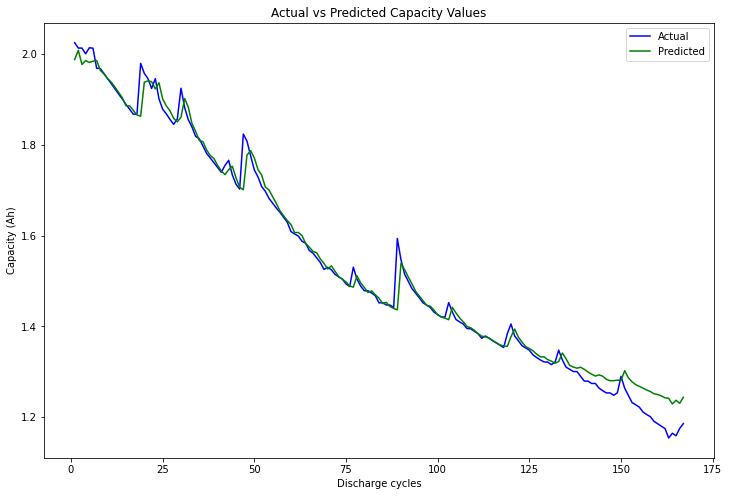

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy 
import scipy.io 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from collections import Counter


class InferenceProcessing():
    def __init__(self, 
                 path, 
                 test_name, 
                 max_voltage,
                 min_voltage,
                 max_current,
                 min_current,
                 max_temp,
                 min_temp,
                 max_cap,
                 min_cap):
        self.path = path
        self.name = test_name
        self.vmax, self.vmin = max_voltage, min_voltage
        self.cmax, self.cmin = max_current, min_current
        self.tmax, self.tmin = max_temp, min_temp
        self.capmax, self.capmin = max_cap, min_cap

    def MultiChannelIP(self):
        test_name = self.name
        path = self.path

        battery_val = {}
        charge_data = {}
        file_path = path + test_name + '.mat'
        data = self.loadMat_to_Dict(file_path)
        battery_val[test_name] = self.getDischargeCapacity(data)
        charge_data[test_name] = self.getChargeData(data)

        # Normalizing Charge Profiles
        Charge_Profile = self.NormalizeData(Charge_Data=charge_data,
                                            battery_name=test_name)
        
        # Sampling Charge Profiles
        Voltage_Measured = self.ChargeDataSampling(Charge_Data=Charge_Profile,
                                                   battery_name=test_name,
                                                   param_type='Voltage_measured',
                                                   sample_size=10)
        Current_Measured = self.ChargeDataSampling(Charge_Data=Charge_Profile,
                                                   battery_name=test_name,
                                                   param_type='Current_measured',
                                                   sample_size=10)
        Temperature_Measured = self.ChargeDataSampling(Charge_Data=Charge_Profile,
                                                   battery_name=test_name,
                                                   param_type='Temperature_measured',
                                                   sample_size=10)

        # Normalizing Capacity Deg Data
        Capacity = self.NormalizeCapacityData(battery_val=battery_val, 
                                              battery_name=test_name)
        
        # Producing 31-Dimension Input...
        Input_Data = self.concatCPandCap(Voltage_Measured=Voltage_Measured,
                                         Current_Measured=Current_Measured,
                                         Temperature_Measured=Temperature_Measured,
                                         Capacity=Capacity,
                                         battery_name=test_name)
        return Input_Data, Capacity, battery_val

    # function to load the .mat data and transform to dict
    def loadMat_to_Dict(self, matfile):
        raw_data = scipy.io.loadmat(matfile)

        # get filename 
        filename = matfile.split("/")[-1].split(".")[0]
         
        col = raw_data[filename]
        # getting 'data'
        col = col[0][0][0][0]
        col_size = col.shape[0]

        data = []
        for i in range(col_size):
            labels = list(col[i][3][0].dtype.fields.keys())
            dict1, dict2 = {}, {}
            if str(col[i][0][0]) != 'impedance':
                for j in range(len(labels)):
                    arr_val = col[i][3][0][0][j][0]
                    val = [arr_val[m] for m in range(len(arr_val))]
                    dict2[labels[j]] = val

            dict1['type'], dict1['temp'], dict1['time'], dict1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(self.datestring_to_time(col[i][2][0])), dict2
            data.append(dict1)

        return data

    # convert time_string to datatime
    def datestring_to_time(self, dates):
        year, month, day, hour, minute, second = int(dates[0]), int(dates[1]), int(dates[2]), int(dates[3]), int(dates[4]), int(dates[5])
        return datetime(year=year,
                        month=month,
                        day=day,
                        hour=hour,
                        minute=minute,
                        second=second)
    
    # function to get capacity data
    def getDischargeCapacity(self, battery):
        cycle, capacity = [], []
        i = 1
        for bat in battery:
            if bat['type'] == 'discharge':
                capacity.append(bat['data']['Capacity'][0])
                cycle.append(i)
                i += 1
        return [cycle, capacity]
    
    # function to get the charge data of the battery
    def getChargeData(self, battery, type='charge'):
        data = []
        for bat in battery:
            if bat['type'] == type:
                data.append(bat['data'])
        return data

    # Normalization function of charging profile parameters
    def NormalizeData(self, Charge_Data, battery_name):
        charge_profile = {}
        parameters = ['Voltage_measured', 'Current_measured', 'Temperature_measured']
        # call function to clean charge profile 
        df = self.CleanCharge_Profile(Charge_Data, battery_name, parameters)

        # normalize voltage values
        for i in range(len(df[battery_name])):
            for j in range(len(df[battery_name][i][parameters[0]])):
                df[battery_name][i][parameters[0]][j] = (df[battery_name][i][parameters[0]][j] - self.vmin) / (self.vmax - self.vmin)
            
            for k in range(len(df[battery_name][i][parameters[1]])):
                df[battery_name][i][parameters[1]][k] = (df[battery_name][i][parameters[1]][k] - self.cmin) / (self.cmax - self.cmin)

            for l in range(len(df[battery_name][i][parameters[2]])):
                df[battery_name][i][parameters[2]][l] = (df[battery_name][i][parameters[2]][l] - self.tmin) / (self.tmax - self.tmin)
        
        return df

    # function to clean charge_profile
    def CleanCharge_Profile(self, Charge_Data, battery_name, parameters):
        df = copy.deepcopy(Charge_Data)
        df[battery_name].pop(32) # drop index 32 measurement exhibit unusual behavior
        df[battery_name].pop(-1) # drop last index; few datapoints

        for params in parameters:
            for i in range(len(df[battery_name])):
                # drop nan values
                df[battery_name][i][params] = [val for val in df[battery_name][i][params] if not(math.isnan(val)) == True]
        
        return df
    
    def ChargeDataSampling(self, Charge_Data, battery_name, param_type, sample_size):
        sampled_dict = {}
        df = copy.deepcopy(Charge_Data[battery_name])
            # remove first and last charging cycle due to few data points
            #df.pop(0) # first list element
            #df.pop(-1) # second list element

        samples = []
        for i in range(len(df)):
            raw_list = list(df[i][param_type])
            sampled_list = self.SystematicSampling(raw_list, sample_size)
            samples.append(sampled_list)
        
            sampled_dict[battery_name] = samples
        return sampled_dict
    
    # function to get charging profile samples using systemating sampling
    def SystematicSampling(self, a_list, sample_size):
        population = len(a_list)
        step = math.ceil(population/sample_size)
        selected_index = np.arange(1, population, step)
        samples = []
        for i in range(len(selected_index)):
            selected_sample = a_list[selected_index[i]]
            samples.append(selected_sample)
        return samples

    def NormalizeCapacityData(self, battery_val, battery_name):
        capacity = {}
        cap_max = self.capmax
        cap_min = self.capmin

        df = copy.deepcopy(battery_val[battery_name][1])
        for i in range(len(df)):
            df[i] = (df[i] - cap_min) / (cap_max - cap_min)
        
        capacity[battery_name] = df
        return capacity
    
    # Function to produce Inputs for testing
    def concatCPandCap(self, Voltage_Measured, Current_Measured, Temperature_Measured, Capacity, battery_name):
        Input31Dim = {}
        V = Voltage_Measured[battery_name]
        V.pop(-1)
        C = Current_Measured[battery_name]
        C.pop(-1)
        T = Temperature_Measured[battery_name]
        T.pop(-1)
        Cap = Capacity[battery_name]
        Cap.pop(-1)
        
        inputs = []
        for i in range(len(V)):
            onediminput = [*V[i], *C[i], *T[i], Cap[i]]
            inputs.append(onediminput)

        Input31Dim[battery_name] = inputs
        return Input31Dim
    
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Metrics
# Compute for accuracy
def accuracy(y_test, y_pred):
  error = np.abs(y_pred-y_test)/y_test
  acc = np.ones_like(error) - error
  acc = np.sum(acc)/len(y_pred)
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
  """
  Prints difference between start and end time
  """

  total_time = end - start
  print(f"Inference time on {device}: {total_time:.3f} seconds")

  return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  usage_stat = snapshot.statistics(key_type)

  total = sum(stat.size for stat in usage_stat)

  print("Allocated memory: %.1f KiB" % (total / 1024))

# function for making predictions
def test(loadedmodel, input_data, y_battery, test_name):
    loss_fn = nn.HuberLoss()
    loadedmodel.eval()
    with torch.inference_mode():
        x_test = torch.tensor(input_data[test_name], dtype=torch.float32)
        y_test = torch.tensor(y_battery[test_name], dtype=torch.float32).unsqueeze(1)
        X_test = x_test.to(device)
        Y_test = y_test.to(device)
        hidden = loadedmodel.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loadedmodel(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # device agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # fixed data processing parameters
    max_voltage, min_voltage = 4.2995855570950186, 2.8889259226774757
    max_current, min_current = 1.536047031556956, -4.50882765791034
    max_temp, min_temp = 36.186651345077465, 21.810169604006642
    max_cap, min_cap = 2.035337591005598, 1.15381833159625 

    #model state_dicts()
    
    #test_name = 'B0005'
    test_name = 'B0006'
    #test_name = 'B0007'
    #test_name = 'B0018']
    path = 'data/nasa/'
    #model_save_path = 'models/RNN_NASAvB5.pth'
    model_save_path = 'models/RNN_NASAvB6.pth'
    #model_save_path = 'models/RNN_NASAvB7.pth'
    #model_save_path = 'models/RNN_NASAvB18.pth'

    #model_save_path

    dataprocessing = InferenceProcessing(path=path,
                                         test_name=test_name,
                                         max_voltage=max_voltage,
                                         min_voltage=min_voltage,
                                         max_current=max_current,
                                         min_current=min_current,
                                         max_temp=max_temp,
                                         min_temp=min_temp,
                                         max_cap=max_cap,
                                         min_cap=min_cap)
    # get input_data for testing
    input_data, capacity, battery_val = dataprocessing.MultiChannelIP()

    # prepare y_test
    y_battery = {}
    df = copy.deepcopy(battery_val[test_name][1])
    df.pop(0)                                 # remove first element
    y_battery[test_name] = df

    # model hyperparameters
    input_size = 31
    hidden_size = 10
    output_size = 1
    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path))
    loadedmodel.to(device)

    test_loss, Y_test, y_pred = test(loadedmodel=loadedmodel,
                                     input_data=input_data,
                                     y_battery=y_battery,
                                     test_name=test_name)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, y_battery[test_name], 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
    plt.legend()

### Inference on B7 Dataset

Test Loss: 0.0003 | MAE: 0.0213 | MSE: 0.0231 | Accuracy: 0.99
Inference time on cpu: 84.360 seconds
Allocated memory: 48608.8 KiB


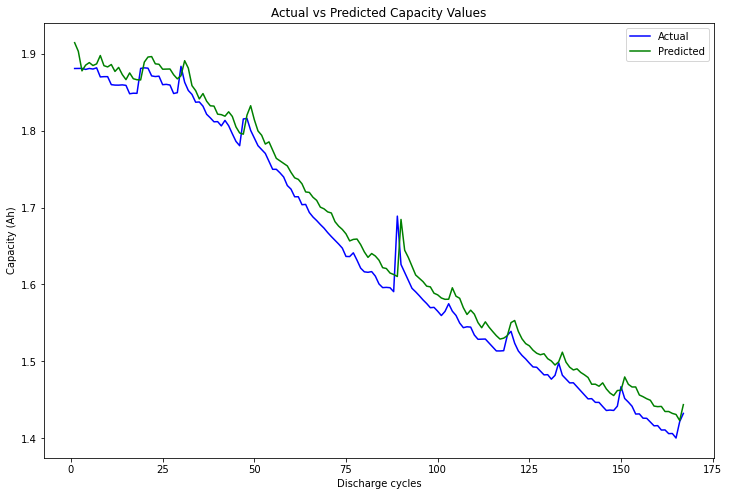

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy 
import scipy.io 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from collections import Counter


class InferenceProcessing():
    def __init__(self, 
                 path, 
                 test_name, 
                 max_voltage,
                 min_voltage,
                 max_current,
                 min_current,
                 max_temp,
                 min_temp,
                 max_cap,
                 min_cap):
        self.path = path
        self.name = test_name
        self.vmax, self.vmin = max_voltage, min_voltage
        self.cmax, self.cmin = max_current, min_current
        self.tmax, self.tmin = max_temp, min_temp
        self.capmax, self.capmin = max_cap, min_cap

    def MultiChannelIP(self):
        test_name = self.name
        path = self.path

        battery_val = {}
        charge_data = {}
        file_path = path + test_name + '.mat'
        data = self.loadMat_to_Dict(file_path)
        battery_val[test_name] = self.getDischargeCapacity(data)
        charge_data[test_name] = self.getChargeData(data)

        # Normalizing Charge Profiles
        Charge_Profile = self.NormalizeData(Charge_Data=charge_data,
                                            battery_name=test_name)
        
        # Sampling Charge Profiles
        Voltage_Measured = self.ChargeDataSampling(Charge_Data=Charge_Profile,
                                                   battery_name=test_name,
                                                   param_type='Voltage_measured',
                                                   sample_size=10)
        Current_Measured = self.ChargeDataSampling(Charge_Data=Charge_Profile,
                                                   battery_name=test_name,
                                                   param_type='Current_measured',
                                                   sample_size=10)
        Temperature_Measured = self.ChargeDataSampling(Charge_Data=Charge_Profile,
                                                   battery_name=test_name,
                                                   param_type='Temperature_measured',
                                                   sample_size=10)

        # Normalizing Capacity Deg Data
        Capacity = self.NormalizeCapacityData(battery_val=battery_val, 
                                              battery_name=test_name)
        
        # Producing 31-Dimension Input...
        Input_Data = self.concatCPandCap(Voltage_Measured=Voltage_Measured,
                                         Current_Measured=Current_Measured,
                                         Temperature_Measured=Temperature_Measured,
                                         Capacity=Capacity,
                                         battery_name=test_name)
        return Input_Data, Capacity, battery_val

    # function to load the .mat data and transform to dict
    def loadMat_to_Dict(self, matfile):
        raw_data = scipy.io.loadmat(matfile)

        # get filename 
        filename = matfile.split("/")[-1].split(".")[0]
         
        col = raw_data[filename]
        # getting 'data'
        col = col[0][0][0][0]
        col_size = col.shape[0]

        data = []
        for i in range(col_size):
            labels = list(col[i][3][0].dtype.fields.keys())
            dict1, dict2 = {}, {}
            if str(col[i][0][0]) != 'impedance':
                for j in range(len(labels)):
                    arr_val = col[i][3][0][0][j][0]
                    val = [arr_val[m] for m in range(len(arr_val))]
                    dict2[labels[j]] = val

            dict1['type'], dict1['temp'], dict1['time'], dict1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(self.datestring_to_time(col[i][2][0])), dict2
            data.append(dict1)

        return data

    # convert time_string to datatime
    def datestring_to_time(self, dates):
        year, month, day, hour, minute, second = int(dates[0]), int(dates[1]), int(dates[2]), int(dates[3]), int(dates[4]), int(dates[5])
        return datetime(year=year,
                        month=month,
                        day=day,
                        hour=hour,
                        minute=minute,
                        second=second)
    
    # function to get capacity data
    def getDischargeCapacity(self, battery):
        cycle, capacity = [], []
        i = 1
        for bat in battery:
            if bat['type'] == 'discharge':
                capacity.append(bat['data']['Capacity'][0])
                cycle.append(i)
                i += 1
        return [cycle, capacity]
    
    # function to get the charge data of the battery
    def getChargeData(self, battery, type='charge'):
        data = []
        for bat in battery:
            if bat['type'] == type:
                data.append(bat['data'])
        return data

    # Normalization function of charging profile parameters
    def NormalizeData(self, Charge_Data, battery_name):
        charge_profile = {}
        parameters = ['Voltage_measured', 'Current_measured', 'Temperature_measured']
        # call function to clean charge profile 
        df = self.CleanCharge_Profile(Charge_Data, battery_name, parameters)

        # normalize voltage values
        for i in range(len(df[battery_name])):
            for j in range(len(df[battery_name][i][parameters[0]])):
                df[battery_name][i][parameters[0]][j] = (df[battery_name][i][parameters[0]][j] - self.vmin) / (self.vmax - self.vmin)
            
            for k in range(len(df[battery_name][i][parameters[1]])):
                df[battery_name][i][parameters[1]][k] = (df[battery_name][i][parameters[1]][k] - self.cmin) / (self.cmax - self.cmin)

            for l in range(len(df[battery_name][i][parameters[2]])):
                df[battery_name][i][parameters[2]][l] = (df[battery_name][i][parameters[2]][l] - self.tmin) / (self.tmax - self.tmin)
        
        return df

    # function to clean charge_profile
    def CleanCharge_Profile(self, Charge_Data, battery_name, parameters):
        df = copy.deepcopy(Charge_Data)
        df[battery_name].pop(32) # drop index 32 measurement exhibit unusual behavior
        df[battery_name].pop(-1) # drop last index; few datapoints

        for params in parameters:
            for i in range(len(df[battery_name])):
                # drop nan values
                df[battery_name][i][params] = [val for val in df[battery_name][i][params] if not(math.isnan(val)) == True]
        
        return df
    
    def ChargeDataSampling(self, Charge_Data, battery_name, param_type, sample_size):
        sampled_dict = {}
        df = copy.deepcopy(Charge_Data[battery_name])
            # remove first and last charging cycle due to few data points
            #df.pop(0) # first list element
            #df.pop(-1) # second list element

        samples = []
        for i in range(len(df)):
            raw_list = list(df[i][param_type])
            sampled_list = self.SystematicSampling(raw_list, sample_size)
            samples.append(sampled_list)
        
            sampled_dict[battery_name] = samples
        return sampled_dict
    
    # function to get charging profile samples using systemating sampling
    def SystematicSampling(self, a_list, sample_size):
        population = len(a_list)
        step = math.ceil(population/sample_size)
        selected_index = np.arange(1, population, step)
        samples = []
        for i in range(len(selected_index)):
            selected_sample = a_list[selected_index[i]]
            samples.append(selected_sample)
        return samples

    def NormalizeCapacityData(self, battery_val, battery_name):
        capacity = {}
        cap_max = self.capmax
        cap_min = self.capmin

        df = copy.deepcopy(battery_val[battery_name][1])
        for i in range(len(df)):
            df[i] = (df[i] - cap_min) / (cap_max - cap_min)
        
        capacity[battery_name] = df
        return capacity
    
    # Function to produce Inputs for testing
    def concatCPandCap(self, Voltage_Measured, Current_Measured, Temperature_Measured, Capacity, battery_name):
        Input31Dim = {}
        V = Voltage_Measured[battery_name]
        V.pop(-1)
        C = Current_Measured[battery_name]
        C.pop(-1)
        T = Temperature_Measured[battery_name]
        T.pop(-1)
        Cap = Capacity[battery_name]
        Cap.pop(-1)
        
        inputs = []
        for i in range(len(V)):
            onediminput = [*V[i], *C[i], *T[i], Cap[i]]
            inputs.append(onediminput)

        Input31Dim[battery_name] = inputs
        return Input31Dim
    
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Metrics
# Compute for accuracy
def accuracy(y_test, y_pred):
  error = np.abs(y_pred-y_test)/y_test
  acc = np.ones_like(error) - error
  acc = np.sum(acc)/len(y_pred)
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
  """
  Prints difference between start and end time
  """

  total_time = end - start
  print(f"Inference time on {device}: {total_time:.3f} seconds")

  return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  usage_stat = snapshot.statistics(key_type)

  total = sum(stat.size for stat in usage_stat)

  print("Allocated memory: %.1f KiB" % (total / 1024))

# function for making predictions
def test(loadedmodel, input_data, y_battery, test_name):
    loss_fn = nn.HuberLoss()
    loadedmodel.eval()
    with torch.inference_mode():
        x_test = torch.tensor(input_data[test_name], dtype=torch.float32)
        y_test = torch.tensor(y_battery[test_name], dtype=torch.float32).unsqueeze(1)
        X_test = x_test.to(device)
        Y_test = y_test.to(device)
        hidden = loadedmodel.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loadedmodel(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # device agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # fixed data processing parameters
    max_voltage, min_voltage = 4.2995855570950186, 2.8889259226774757
    max_current, min_current = 1.536047031556956, -4.50882765791034
    max_temp, min_temp = 36.186651345077465, 21.810169604006642
    max_cap, min_cap = 2.035337591005598, 1.15381833159625 

    #model state_dicts()
    
    #test_name = 'B0005'
    #test_name = 'B0006'
    test_name = 'B0007'
    #test_name = 'B0018']
    path = 'data/nasa/'
    #model_save_path = 'models/RNN_NASAvB5.pth'
    #model_save_path = 'models/RNN_NASAvB6.pth'
    model_save_path = 'models/RNN_NASAvB7.pth'
    #model_save_path = 'models/RNN_NASAvB18.pth'

    #model_save_path

    dataprocessing = InferenceProcessing(path=path,
                                         test_name=test_name,
                                         max_voltage=max_voltage,
                                         min_voltage=min_voltage,
                                         max_current=max_current,
                                         min_current=min_current,
                                         max_temp=max_temp,
                                         min_temp=min_temp,
                                         max_cap=max_cap,
                                         min_cap=min_cap)
    # get input_data for testing
    input_data, capacity, battery_val = dataprocessing.MultiChannelIP()

    # prepare y_test
    y_battery = {}
    df = copy.deepcopy(battery_val[test_name][1])
    df.pop(0)                                 # remove first element
    y_battery[test_name] = df

    # model hyperparameters
    input_size = 31
    hidden_size = 10
    output_size = 1
    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path))
    loadedmodel.to(device)

    test_loss, Y_test, y_pred = test(loadedmodel=loadedmodel,
                                     input_data=input_data,
                                     y_battery=y_battery,
                                     test_name=test_name)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, y_battery[test_name], 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
    plt.legend()

### Inference on B18 Dataset

Test Loss: 0.0010 | MAE: 0.0360 | MSE: 0.0447 | Accuracy: 0.98
Inference time on cpu: 60.869 seconds
Allocated memory: 48617.9 KiB


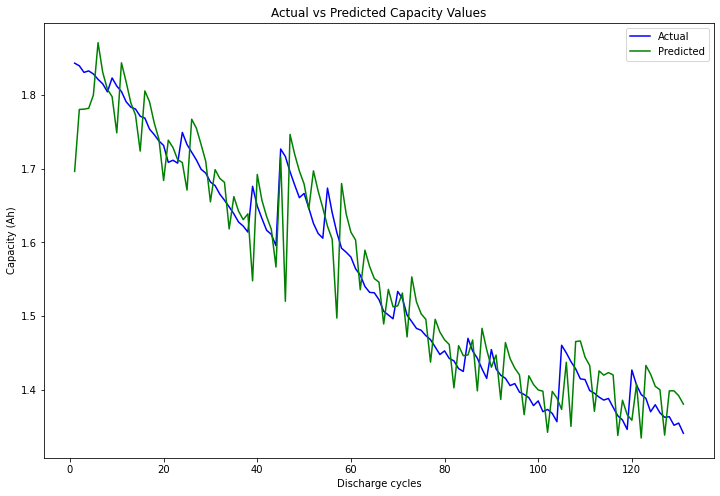

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy 
import scipy.io 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from collections import Counter


class InferenceProcessing():
    def __init__(self, 
                 path, 
                 test_name, 
                 max_voltage,
                 min_voltage,
                 max_current,
                 min_current,
                 max_temp,
                 min_temp,
                 max_cap,
                 min_cap):
        self.path = path
        self.name = test_name
        self.vmax, self.vmin = max_voltage, min_voltage
        self.cmax, self.cmin = max_current, min_current
        self.tmax, self.tmin = max_temp, min_temp
        self.capmax, self.capmin = max_cap, min_cap

    def MultiChannelIP(self):
        test_name = self.name
        path = self.path

        battery_val = {}
        charge_data = {}
        file_path = path + test_name + '.mat'
        data = self.loadMat_to_Dict(file_path)
        battery_val[test_name] = self.getDischargeCapacity(data)
        charge_data[test_name] = self.getChargeData(data)

        # Normalizing Charge Profiles
        Charge_Profile = self.NormalizeData(Charge_Data=charge_data,
                                            battery_name=test_name)
        
        # Sampling Charge Profiles
        Voltage_Measured = self.ChargeDataSampling(Charge_Data=Charge_Profile,
                                                   battery_name=test_name,
                                                   param_type='Voltage_measured',
                                                   sample_size=10)
        Current_Measured = self.ChargeDataSampling(Charge_Data=Charge_Profile,
                                                   battery_name=test_name,
                                                   param_type='Current_measured',
                                                   sample_size=10)
        Temperature_Measured = self.ChargeDataSampling(Charge_Data=Charge_Profile,
                                                   battery_name=test_name,
                                                   param_type='Temperature_measured',
                                                   sample_size=10)

        # Normalizing Capacity Deg Data
        Capacity = self.NormalizeCapacityData(battery_val=battery_val, 
                                              battery_name=test_name)
        
        # Producing 31-Dimension Input...
        Input_Data = self.concatCPandCap(Voltage_Measured=Voltage_Measured,
                                         Current_Measured=Current_Measured,
                                         Temperature_Measured=Temperature_Measured,
                                         Capacity=Capacity,
                                         battery_name=test_name)
        return Input_Data, Capacity, battery_val

    # function to load the .mat data and transform to dict
    def loadMat_to_Dict(self, matfile):
        raw_data = scipy.io.loadmat(matfile)

        # get filename 
        filename = matfile.split("/")[-1].split(".")[0]
         
        col = raw_data[filename]
        # getting 'data'
        col = col[0][0][0][0]
        col_size = col.shape[0]

        data = []
        for i in range(col_size):
            labels = list(col[i][3][0].dtype.fields.keys())
            dict1, dict2 = {}, {}
            if str(col[i][0][0]) != 'impedance':
                for j in range(len(labels)):
                    arr_val = col[i][3][0][0][j][0]
                    val = [arr_val[m] for m in range(len(arr_val))]
                    dict2[labels[j]] = val

            dict1['type'], dict1['temp'], dict1['time'], dict1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(self.datestring_to_time(col[i][2][0])), dict2
            data.append(dict1)

        return data

    # convert time_string to datatime
    def datestring_to_time(self, dates):
        year, month, day, hour, minute, second = int(dates[0]), int(dates[1]), int(dates[2]), int(dates[3]), int(dates[4]), int(dates[5])
        return datetime(year=year,
                        month=month,
                        day=day,
                        hour=hour,
                        minute=minute,
                        second=second)
    
    # function to get capacity data
    def getDischargeCapacity(self, battery):
        cycle, capacity = [], []
        i = 1
        for bat in battery:
            if bat['type'] == 'discharge':
                capacity.append(bat['data']['Capacity'][0])
                cycle.append(i)
                i += 1
        return [cycle, capacity]
    
    # function to get the charge data of the battery
    def getChargeData(self, battery, type='charge'):
        data = []
        for bat in battery:
            if bat['type'] == type:
                data.append(bat['data'])
        return data

    # Normalization function of charging profile parameters
    def NormalizeData(self, Charge_Data, battery_name):
        charge_profile = {}
        parameters = ['Voltage_measured', 'Current_measured', 'Temperature_measured']
        # call function to clean charge profile 
        df = self.CleanCharge_Profile(Charge_Data, battery_name, parameters)

        # normalize voltage values
        for i in range(len(df[battery_name])):
            for j in range(len(df[battery_name][i][parameters[0]])):
                df[battery_name][i][parameters[0]][j] = (df[battery_name][i][parameters[0]][j] - self.vmin) / (self.vmax - self.vmin)
            
            for k in range(len(df[battery_name][i][parameters[1]])):
                df[battery_name][i][parameters[1]][k] = (df[battery_name][i][parameters[1]][k] - self.cmin) / (self.cmax - self.cmin)

            for l in range(len(df[battery_name][i][parameters[2]])):
                df[battery_name][i][parameters[2]][l] = (df[battery_name][i][parameters[2]][l] - self.tmin) / (self.tmax - self.tmin)
        
        return df

    # function to clean charge_profile
    def CleanCharge_Profile(self, Charge_Data, battery_name, parameters):
        df = copy.deepcopy(Charge_Data)
        df[battery_name].pop(32) # drop index 32 measurement exhibit unusual behavior
        df[battery_name].pop(-1) # drop last index; few datapoints

        for params in parameters:
            for i in range(len(df[battery_name])):
                # drop nan values
                df[battery_name][i][params] = [val for val in df[battery_name][i][params] if not(math.isnan(val)) == True]
        
        return df
    
    def ChargeDataSampling(self, Charge_Data, battery_name, param_type, sample_size):
        sampled_dict = {}
        df = copy.deepcopy(Charge_Data[battery_name])
            # remove first and last charging cycle due to few data points
            #df.pop(0) # first list element
            #df.pop(-1) # second list element

        samples = []
        for i in range(len(df)):
            raw_list = list(df[i][param_type])
            sampled_list = self.SystematicSampling(raw_list, sample_size)
            samples.append(sampled_list)
        
            sampled_dict[battery_name] = samples
        return sampled_dict
    
    # function to get charging profile samples using systemating sampling
    def SystematicSampling(self, a_list, sample_size):
        population = len(a_list)
        step = math.ceil(population/sample_size)
        selected_index = np.arange(1, population, step)
        samples = []
        for i in range(len(selected_index)):
            selected_sample = a_list[selected_index[i]]
            samples.append(selected_sample)
        return samples

    def NormalizeCapacityData(self, battery_val, battery_name):
        capacity = {}
        cap_max = self.capmax
        cap_min = self.capmin

        df = copy.deepcopy(battery_val[battery_name][1])
        for i in range(len(df)):
            df[i] = (df[i] - cap_min) / (cap_max - cap_min)
        
        capacity[battery_name] = df
        return capacity
    
    # Function to produce Inputs for testing
    def concatCPandCap(self, Voltage_Measured, Current_Measured, Temperature_Measured, Capacity, battery_name):
        Input31Dim = {}
        V = Voltage_Measured[battery_name]
        V.pop(-1)
        C = Current_Measured[battery_name]
        C.pop(-1)
        T = Temperature_Measured[battery_name]
        T.pop(-1)
        Cap = Capacity[battery_name]
        Cap.pop(-1)
        
        inputs = []
        for i in range(len(V)):
            onediminput = [*V[i], *C[i], *T[i], Cap[i]]
            inputs.append(onediminput)

        Input31Dim[battery_name] = inputs
        return Input31Dim
    
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Metrics
# Compute for accuracy
def accuracy(y_test, y_pred):
  error = np.abs(y_pred-y_test)/y_test
  acc = np.ones_like(error) - error
  acc = np.sum(acc)/len(y_pred)
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
  """
  Prints difference between start and end time
  """

  total_time = end - start
  print(f"Inference time on {device}: {total_time:.3f} seconds")

  return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  usage_stat = snapshot.statistics(key_type)

  total = sum(stat.size for stat in usage_stat)

  print("Allocated memory: %.1f KiB" % (total / 1024))

# function for making predictions
def test(loadedmodel, input_data, y_battery, test_name):
    loss_fn = nn.HuberLoss()
    loadedmodel.eval()
    with torch.inference_mode():
        x_test = torch.tensor(input_data[test_name], dtype=torch.float32)
        y_test = torch.tensor(y_battery[test_name], dtype=torch.float32).unsqueeze(1)
        X_test = x_test.to(device)
        Y_test = y_test.to(device)
        hidden = loadedmodel.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loadedmodel(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # device agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # fixed data processing parameters
    max_voltage, min_voltage = 4.2995855570950186, 2.8889259226774757
    max_current, min_current = 1.536047031556956, -4.50882765791034
    max_temp, min_temp = 36.186651345077465, 21.810169604006642
    max_cap, min_cap = 2.035337591005598, 1.15381833159625 

    #model state_dicts()
    
    #test_name = 'B0005'
    #test_name = 'B0006'
    #test_name = 'B0007'
    test_name = 'B0018'
    path = 'data/nasa/'
    #model_save_path = 'models/RNN_NASAvB5.pth'
    #model_save_path = 'models/RNN_NASAvB6.pth'
    #model_save_path = 'models/RNN_NASAvB7.pth'
    model_save_path = 'models/RNN_NASAvB18.pth'

    #model_save_path

    dataprocessing = InferenceProcessing(path=path,
                                         test_name=test_name,
                                         max_voltage=max_voltage,
                                         min_voltage=min_voltage,
                                         max_current=max_current,
                                         min_current=min_current,
                                         max_temp=max_temp,
                                         min_temp=min_temp,
                                         max_cap=max_cap,
                                         min_cap=min_cap)
    # get input_data for testing
    input_data, capacity, battery_val = dataprocessing.MultiChannelIP()

    # prepare y_test
    y_battery = {}
    df = copy.deepcopy(battery_val[test_name][1])
    df.pop(0)                                 # remove first element
    y_battery[test_name] = df

    # model hyperparameters
    input_size = 31
    hidden_size = 10
    output_size = 1
    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path))
    loadedmodel.to(device)

    test_loss, Y_test, y_pred = test(loadedmodel=loadedmodel,
                                     input_data=input_data,
                                     y_battery=y_battery,
                                     test_name=test_name)

    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, y_battery[test_name], 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
    plt.legend()

In [ ]:
import shutil
import os
from pathlib import Path

Battery_names = ['B0005', 'B0006', 'B0007', 'B0018']
# Setup path to date folder
data_path = Path("tensors/")
for name in Battery_names:
    destination_folder = data_path / name

    # If the dataset folder doesn't exist download it and prepare it...
    if destination_folder.is_dir():
        print(f"{destination_folder} directory exists.")
    else:
        print(f"Did not find {destination_folder} directory, creating one...")
        destination_folder.mkdir(parents=True, exist_ok=True)

    # move zip file to data_path
    print("Moving .pt files to directory...")
    source_folder = "drive/MyDrive/tensors/"+name+"/"
    for file_name in os.listdir(source_folder):
        source = source_folder + file_name
        destination = destination_folder / file_name
        # move only files
        if os.path.isfile(source):
            shutil.move(source, destination)
            print('Moved:', file_name)

tensors/B0005 directory exists.
Moving .pt files to directory...
Moved: B0005_input.pt
Moved: B0005_target.pt
Did not find tensors/B0006 directory, creating one...
Moving .pt files to directory...
Moved: B0006_input.pt
Moved: B0006_target.pt
Did not find tensors/B0007 directory, creating one...
Moving .pt files to directory...
Moved: B0007_input.pt
Moved: B0007_target.pt
Did not find tensors/B0018 directory, creating one...
Moving .pt files to directory...
Moved: B0018_input.pt
Moved: B0018_target.pt


['.config', 'drive', 'sample_data']

## Updated Inference scripts

In [ ]:
class InferenceProcessing():
    def __init__(self, 
                 path, 
                 test_name, 
                 max_voltage,
                 min_voltage,
                 max_current,
                 min_current,
                 max_temp,
                 min_temp,
                 max_cap,
                 min_cap):
        self.path = path
        self.name = test_name
        self.vmax, self.vmin = max_voltage, min_voltage
        self.cmax, self.cmin = max_current, min_current
        self.tmax, self.tmin = max_temp, min_temp
        self.capmax, self.capmin = max_cap, min_cap

    def MultiChannelIP(self):
        test_name = self.name
        path = self.path

        battery_val = {}
        charge_data = {}
        file_path = path + test_name + '.mat'
        data = self.loadMat_to_Dict(file_path)
        battery_val[test_name] = self.getDischargeCapacity(data)
        charge_data[test_name] = self.getChargeData(data)

        # Normalizing Charge Profiles
        Charge_Profile = self.NormalizeData(Charge_Data=charge_data,
                                            battery_name=test_name)
        
        # Sampling Charge Profiles
        Voltage_Measured = self.ChargeDataSampling(Charge_Data=Charge_Profile,
                                                   battery_name=test_name,
                                                   param_type='Voltage_measured',
                                                   sample_size=10)
        Current_Measured = self.ChargeDataSampling(Charge_Data=Charge_Profile,
                                                   battery_name=test_name,
                                                   param_type='Current_measured',
                                                   sample_size=10)
        Temperature_Measured = self.ChargeDataSampling(Charge_Data=Charge_Profile,
                                                   battery_name=test_name,
                                                   param_type='Temperature_measured',
                                                   sample_size=10)

        # Normalizing Capacity Deg Data
        Capacity = self.NormalizeCapacityData(battery_val=battery_val, 
                                              battery_name=test_name)
        
        # Producing 31-Dimension Input...
        Input_Data = self.concatCPandCap(Voltage_Measured=Voltage_Measured,
                                         Current_Measured=Current_Measured,
                                         Temperature_Measured=Temperature_Measured,
                                         Capacity=Capacity,
                                         battery_name=test_name)
        return Input_Data, Capacity, battery_val

    # function to load the .mat data and transform to dict
    def loadMat_to_Dict(self, matfile):
        raw_data = scipy.io.loadmat(matfile)

        # get filename 
        filename = matfile.split("/")[-1].split(".")[0]
         
        col = raw_data[filename]
        # getting 'data'
        col = col[0][0][0][0]
        col_size = col.shape[0]

        data = []
        for i in range(col_size):
            labels = list(col[i][3][0].dtype.fields.keys())
            dict1, dict2 = {}, {}
            if str(col[i][0][0]) != 'impedance':
                for j in range(len(labels)):
                    arr_val = col[i][3][0][0][j][0]
                    val = [arr_val[m] for m in range(len(arr_val))]
                    dict2[labels[j]] = val

            dict1['type'], dict1['temp'], dict1['time'], dict1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(self.datestring_to_time(col[i][2][0])), dict2
            data.append(dict1)

        return data

    # convert time_string to datatime
    def datestring_to_time(self, dates):
        year, month, day, hour, minute, second = int(dates[0]), int(dates[1]), int(dates[2]), int(dates[3]), int(dates[4]), int(dates[5])
        return datetime(year=year,
                        month=month,
                        day=day,
                        hour=hour,
                        minute=minute,
                        second=second)
    
    # function to get capacity data
    def getDischargeCapacity(self, battery):
        cycle, capacity = [], []
        i = 1
        for bat in battery:
            if bat['type'] == 'discharge':
                capacity.append(bat['data']['Capacity'][0])
                cycle.append(i)
                i += 1
        return [cycle, capacity]
    
    # function to get the charge data of the battery
    def getChargeData(self, battery, type='charge'):
        data = []
        for bat in battery:
            if bat['type'] == type:
                data.append(bat['data'])
        return data

    # Normalization function of charging profile parameters
    def NormalizeData(self, Charge_Data, battery_name):
        charge_profile = {}
        parameters = ['Voltage_measured', 'Current_measured', 'Temperature_measured']
        # call function to clean charge profile 
        df = self.CleanCharge_Profile(Charge_Data, battery_name, parameters)

        # normalize voltage values
        for i in range(len(df[battery_name])):
            for j in range(len(df[battery_name][i][parameters[0]])):
                df[battery_name][i][parameters[0]][j] = (df[battery_name][i][parameters[0]][j] - self.vmin) / (self.vmax - self.vmin)
            
            for k in range(len(df[battery_name][i][parameters[1]])):
                df[battery_name][i][parameters[1]][k] = (df[battery_name][i][parameters[1]][k] - self.cmin) / (self.cmax - self.cmin)

            for l in range(len(df[battery_name][i][parameters[2]])):
                df[battery_name][i][parameters[2]][l] = (df[battery_name][i][parameters[2]][l] - self.tmin) / (self.tmax - self.tmin)
        
        return df

    # function to clean charge_profile
    def CleanCharge_Profile(self, Charge_Data, battery_name, parameters):
        df = copy.deepcopy(Charge_Data)
        df[battery_name].pop(32) # drop index 32 measurement exhibit unusual behavior
        df[battery_name].pop(-1) # drop last index; few datapoints

        for params in parameters:
            for i in range(len(df[battery_name])):
                # drop nan values
                df[battery_name][i][params] = [val for val in df[battery_name][i][params] if not(math.isnan(val)) == True]
        
        return df
    
    def ChargeDataSampling(self, Charge_Data, battery_name, param_type, sample_size):
        sampled_dict = {}
        df = copy.deepcopy(Charge_Data[battery_name])
            # remove first and last charging cycle due to few data points
            #df.pop(0) # first list element
            #df.pop(-1) # second list element

        samples = []
        for i in range(len(df)):
            raw_list = list(df[i][param_type])
            sampled_list = self.SystematicSampling(raw_list, sample_size)
            samples.append(sampled_list)
        
            sampled_dict[battery_name] = samples
        return sampled_dict
    
    # function to get charging profile samples using systemating sampling
    def SystematicSampling(self, a_list, sample_size):
        population = len(a_list)
        step = math.ceil(population/sample_size)
        selected_index = np.arange(1, population, step)
        samples = []
        for i in range(len(selected_index)):
            selected_sample = a_list[selected_index[i]]
            samples.append(selected_sample)
        return samples

    def NormalizeCapacityData(self, battery_val, battery_name):
        capacity = {}
        cap_max = self.capmax
        cap_min = self.capmin

        df = copy.deepcopy(battery_val[battery_name][1])
        for i in range(len(df)):
            df[i] = (df[i] - cap_min) / (cap_max - cap_min)
        
        capacity[battery_name] = df
        return capacity
    
    # Function to produce Inputs for testing
    def concatCPandCap(self, Voltage_Measured, Current_Measured, Temperature_Measured, Capacity, battery_name):
        Input31Dim = {}
        V = Voltage_Measured[battery_name]
        V.pop(-1)
        C = Current_Measured[battery_name]
        C.pop(-1)
        T = Temperature_Measured[battery_name]
        T.pop(-1)
        Cap = Capacity[battery_name]
        Cap.pop(-1)
        
        inputs = []
        for i in range(len(V)):
            onediminput = [*V[i], *C[i], *T[i], Cap[i]]
            inputs.append(onediminput)

        Input31Dim[battery_name] = inputs
        return Input31Dim


In [ ]:
battery_names = ['B0005', 'B0006', 'B0007', 'B0018']
path = 'data/nasa/'
# fixed data processing parameters
max_voltage, min_voltage = 4.2995855570950186, 2.8889259226774757
max_current, min_current = 1.536047031556956, -4.50882765791034
max_temp, min_temp = 36.186651345077465, 21.810169604006642
max_cap, min_cap = 2.035337591005598, 1.15381833159625 
for name in battery_names:
    dataprocessing = InferenceProcessing(path=path, 
                                         test_name=name, 
                                         max_voltage=max_voltage, 
                                         min_voltage=min_voltage, 
                                         max_current=max_current, 
                                         min_current=min_current, 
                                         max_temp=max_temp, 
                                         min_temp=min_temp, 
                                         max_cap=max_cap, 
                                         min_cap=min_cap)
    # get input_data for testing
    input_data, capacity, battery_val = dataprocessing.MultiChannelIP()

    # prepare y_test
    y_battery = {}
    df = copy.deepcopy(battery_val[name][1])
    df.pop(0)                                 # remove first element
    y_battery[name] = df

    x_test = torch.tensor(input_data[name], dtype=torch.float32)
    y_test = torch.tensor(y_battery[name], dtype=torch.float32).unsqueeze(1)
    X_test = x_test.to(device)
    Y_test = y_test.to(device)
    tensor_input = name + "_input.pt"
    tensor_target = name + "_target.pt"
    tensor_path = "tensors/" + name + "/"
    Path(tensor_path).mkdir(parents=True, exist_ok=True)
    torch.save(X_test, tensor_path + tensor_input)
    torch.save(Y_test, tensor_path + tensor_target)

In [ ]:
load_path = "tensors/B0005/B0005_input.pt"
X_test = torch.load(load_path)
X_test.shape

torch.Size([167, 31])

### B0005 Inference script

Test Loss: 0.0001 | MAE: 0.0076 | MSE: 0.0131 | Accuracy: 1.00
True RUL: 123 | Prediction RUL: 122 | RUL Error: 1
Inference time on cpu: 0.062 seconds
Allocated memory: 2769.3 KiB


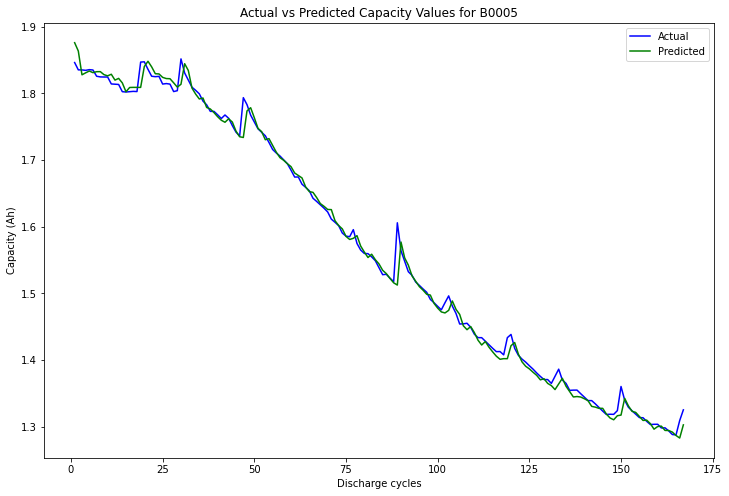

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy 
import scipy.io 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Metrics
# Compute for accuracy
def accuracy(y_test, y_pred):
  error = np.abs(y_pred-y_test)/y_test
  acc = np.ones_like(error) - error
  acc = np.sum(acc)/len(y_pred)
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
  """
  Prints difference between start and end time
  """

  total_time = end - start
  print(f"Inference time on {device}: {total_time:.3f} seconds")

  return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  usage_stat = snapshot.statistics(key_type)

  total = sum(stat.size for stat in usage_stat)

  print("Allocated memory: %.1f KiB" % (total / 1024))

  # function for making predictions
def test(loadedmodel, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loadedmodel.eval()
    with torch.inference_mode():
        hidden = loadedmodel.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loadedmodel(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 2.0

    model_save_path = 'models/RNN_NASAvB5.pth'
    #model_save_path = 'models/RNN_NASAvB6.pth'
    #model_save_path = 'models/RNN_NASAvB7.pth'
    #model_save_path = 'models/RNN_NASAvB18.pth'

    #test input tensor path
    input_path = "tensors/B0005/B0005_input.pt"
    #input_path = "tensors/B0006/B0006_input.pt"
    #input_path = "tensors/B0007/B0007_input.pt"
    #input_path = "tensors/B0018/B0018_input.pt"

    #target tensor path
    target_path = "tensors/B0005/B0005_target.pt"
    #target_path = "tensors/B0006/B0006_target.pt"
    #target_path = "tensors/B0007/B0007_target.pt"
    #target_path = "tensors/B0018/B0018_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    # model hyperparameters
    input_size = 31
    hidden_size = 10
    output_size = 1
    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path))
    loadedmodel.to(device)

    test_loss, Y_test, y_pred = test(loadedmodel=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)
    
    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for B0005')
    plt.legend()
    


Test Loss: 0.0001 | MAE: 0.0096 | MSE: 0.0146 | Accuracy: 0.99
True RUL: 123 | Prediction RUL: 122 | RUL Error: 1
Inference time on cpu: 0.140 seconds
Allocated memory: 938.3 KiB


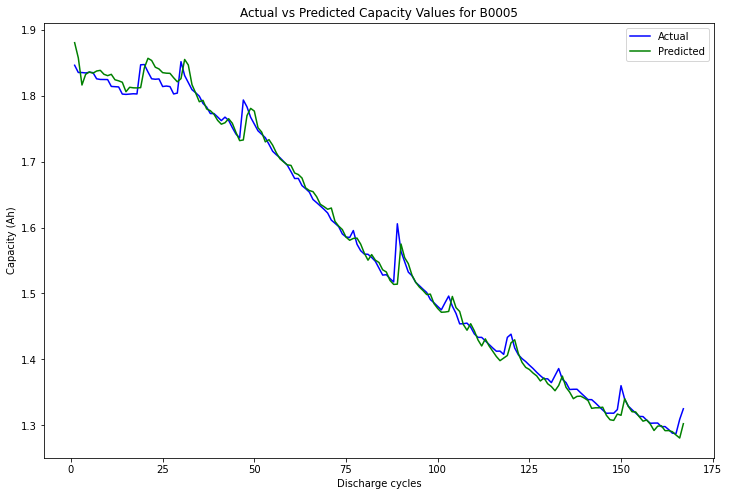

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy 
import scipy.io 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Metrics
# Compute for accuracy
def accuracy(y_test, y_pred):
  error = np.abs(y_pred-y_test)/y_test
  acc = np.ones_like(error) - error
  acc = np.sum(acc)/len(y_pred)
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
  """
  Prints difference between start and end time
  """

  total_time = end - start
  print(f"Inference time on {device}: {total_time:.3f} seconds")

  return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  usage_stat = snapshot.statistics(key_type)

  total = sum(stat.size for stat in usage_stat)

  print("Allocated memory: %.1f KiB" % (total / 1024))

  # function for making predictions
def test(loadedmodel, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loadedmodel.eval()
    with torch.inference_mode():
        hidden = loadedmodel.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loadedmodel(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 2.0

    model_save_path = 'models/RNN_NASAvB5.pth'
    #model_save_path = 'models/RNN_NASAvB6.pth'
    #model_save_path = 'models/RNN_NASAvB7.pth'
    #model_save_path = 'models/RNN_NASAvB18.pth'

    #test input tensor path
    input_path = "tensors/B0005/B0005_input.pt"
    #input_path = "tensors/B0006/B0006_input.pt"
    #input_path = "tensors/B0007/B0007_input.pt"
    #input_path = "tensors/B0018/B0018_input.pt"

    #target tensor path
    target_path = "tensors/B0005/B0005_target.pt"
    #target_path = "tensors/B0006/B0006_target.pt"
    #target_path = "tensors/B0007/B0007_target.pt"
    #target_path = "tensors/B0018/B0018_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    # model hyperparameters
    input_size = 31
    hidden_size = 10
    output_size = 1
    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))
    loadedmodel.to(device)

    test_loss, Y_test, y_pred = test(loadedmodel=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)
    
    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]
    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    if(torch.Tensor(Y_test[int(RUL_pred + 1)])>Threshold):
        RUL_pred = idx_pred[1][0]
    
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for B0005')
    plt.legend()
    


### B0006

Test Loss: 0.0004 | MAE: 0.0184 | MSE: 0.0299 | Accuracy: 0.99
True RUL: 107 | Prediction RUL: 107 | RUL Error: 0
Inference time on cpu: 0.044 seconds
Allocated memory: 3535.1 KiB


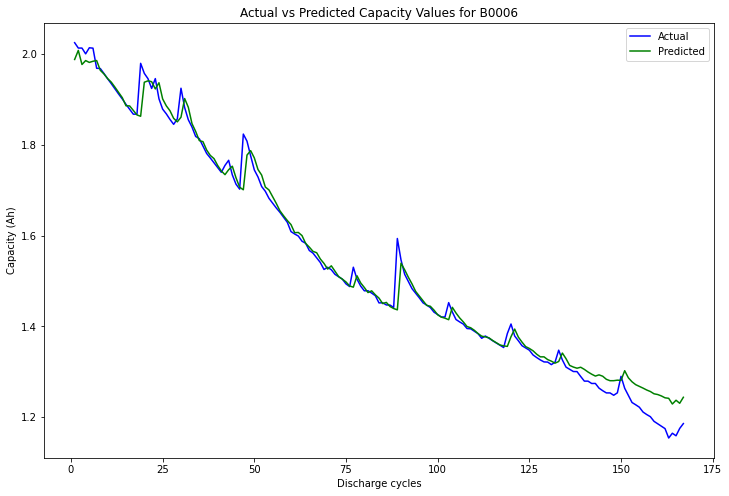

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy 
import scipy.io 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Metrics
# Compute for accuracy
def accuracy(y_test, y_pred):
  error = np.abs(y_pred-y_test)/y_test
  acc = np.ones_like(error) - error
  acc = np.sum(acc)/len(y_pred)
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
  """
  Prints difference between start and end time
  """

  total_time = end - start
  print(f"Inference time on {device}: {total_time:.3f} seconds")

  return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  usage_stat = snapshot.statistics(key_type)

  total = sum(stat.size for stat in usage_stat)

  print("Allocated memory: %.1f KiB" % (total / 1024))

  # function for making predictions
def test(loadedmodel, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loadedmodel.eval()
    with torch.inference_mode():
        hidden = loadedmodel.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loadedmodel(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 2.0

    #model_save_path = 'models/RNN_NASAvB5.pth'
    model_save_path = 'models/RNN_NASAvB6.pth'
    #model_save_path = 'models/RNN_NASAvB7.pth'
    #model_save_path = 'models/RNN_NASAvB18.pth'

    #test input tensor path
    #input_path = "tensors/B0005/B0005_input.pt"
    input_path = "tensors/B0006/B0006_input.pt"
    #input_path = "tensors/B0007/B0007_input.pt"
    #input_path = "tensors/B0018/B0018_input.pt"

    #target tensor path
    #target_path = "tensors/B0005/B0005_target.pt"
    target_path = "tensors/B0006/B0006_target.pt"
    #target_path = "tensors/B0007/B0007_target.pt"
    #target_path = "tensors/B0018/B0018_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    # model hyperparameters
    input_size = 31
    hidden_size = 10
    output_size = 1
    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path))
    loadedmodel.to(device)

    test_loss, Y_test, y_pred = test(loadedmodel=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)
    
    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for B0006')
    plt.legend()
    


Test Loss: 0.0005 | MAE: 0.0196 | MSE: 0.0308 | Accuracy: 0.99
True RUL: 107 | Prediction RUL: 107 | RUL Error: 0
Inference time on cpu: 0.028 seconds
Allocated memory: 2323.4 KiB


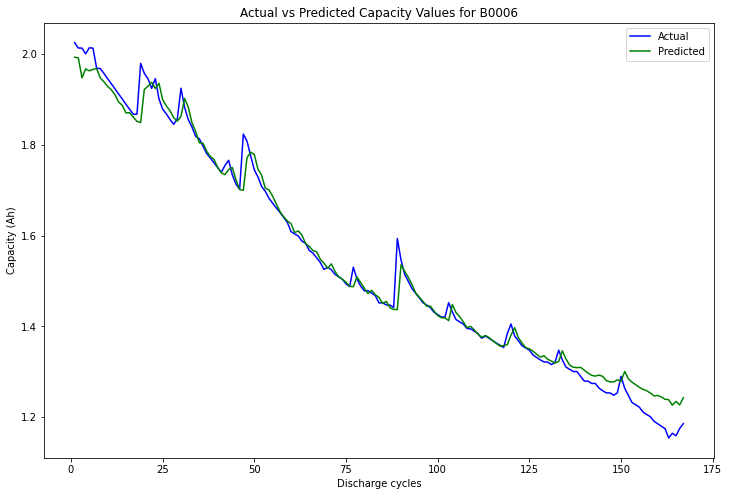

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy 
import scipy.io 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Metrics
# Compute for accuracy
def accuracy(y_test, y_pred):
  error = np.abs(y_pred-y_test)/y_test
  acc = np.ones_like(error) - error
  acc = np.sum(acc)/len(y_pred)
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
  """
  Prints difference between start and end time
  """

  total_time = end - start
  print(f"Inference time on {device}: {total_time:.3f} seconds")

  return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  usage_stat = snapshot.statistics(key_type)

  total = sum(stat.size for stat in usage_stat)

  print("Allocated memory: %.1f KiB" % (total / 1024))

  # function for making predictions
def test(loadedmodel, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loadedmodel.eval()
    with torch.inference_mode():
        hidden = loadedmodel.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loadedmodel(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 2.0

    #model_save_path = 'models/RNN_NASAvB5.pth'
    model_save_path = 'models/RNN_NASAvB6.pth'
    #model_save_path = 'models/RNN_NASAvB7.pth'
    #model_save_path = 'models/RNN_NASAvB18.pth'

    #test input tensor path
    #input_path = "tensors/B0005/B0005_input.pt"
    input_path = "tensors/B0006/B0006_input.pt"
    #input_path = "tensors/B0007/B0007_input.pt"
    #input_path = "tensors/B0018/B0018_input.pt"

    #target tensor path
    #target_path = "tensors/B0005/B0005_target.pt"
    target_path = "tensors/B0006/B0006_target.pt"
    #target_path = "tensors/B0007/B0007_target.pt"
    #target_path = "tensors/B0018/B0018_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    # model hyperparameters
    input_size = 31
    hidden_size = 10
    output_size = 1
    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))
    loadedmodel.to(device)

    test_loss, Y_test, y_pred = test(loadedmodel=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)
    
    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for B0006')
    plt.legend()
    


### B0007

Test Loss: 0.0003 | MAE: 0.0213 | MSE: 0.0231 | Accuracy: 0.99
True RUL: 84 | Prediction RUL: 96 | RUL Error: -12
Inference time on cpu: 0.033 seconds
Allocated memory: 4308.9 KiB


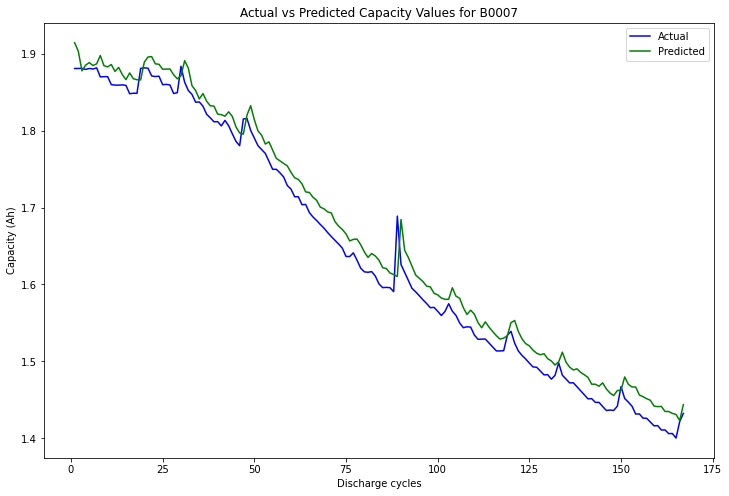

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy 
import scipy.io 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Metrics
# Compute for accuracy
def accuracy(y_test, y_pred):
  error = np.abs(y_pred-y_test)/y_test
  acc = np.ones_like(error) - error
  acc = np.sum(acc)/len(y_pred)
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
  """
  Prints difference between start and end time
  """

  total_time = end - start
  print(f"Inference time on {device}: {total_time:.3f} seconds")

  return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  usage_stat = snapshot.statistics(key_type)

  total = sum(stat.size for stat in usage_stat)

  print("Allocated memory: %.1f KiB" % (total / 1024))

  # function for making predictions
def test(loadedmodel, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loadedmodel.eval()
    with torch.inference_mode():
        hidden = loadedmodel.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loadedmodel(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 2.0

    #model_save_path = 'models/RNN_NASAvB5.pth'
    #model_save_path = 'models/RNN_NASAvB6.pth'
    model_save_path = 'models/RNN_NASAvB7.pth'
    #model_save_path = 'models/RNN_NASAvB18.pth'

    #test input tensor path
    #input_path = "tensors/B0005/B0005_input.pt"
    #input_path = "tensors/B0006/B0006_input.pt"
    input_path = "tensors/B0007/B0007_input.pt"
    #input_path = "tensors/B0018/B0018_input.pt"

    #target tensor path
    #target_path = "tensors/B0005/B0005_target.pt"
    #target_path = "tensors/B0006/B0006_target.pt"
    target_path = "tensors/B0007/B0007_target.pt"
    #target_path = "tensors/B0018/B0018_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    # model hyperparameters
    input_size = 31
    hidden_size = 10
    output_size = 1
    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path))
    loadedmodel.to(device)

    test_loss, Y_test, y_pred = test(loadedmodel=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)
    
    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.8 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for B0007')
    plt.legend()
    


Test Loss: 0.0004 | MAE: 0.0249 | MSE: 0.0267 | Accuracy: 0.98
True RUL: 84 | Prediction RUL: 98 | RUL Error: -14
Inference time on cpu: 0.045 seconds
Allocated memory: 3077.5 KiB


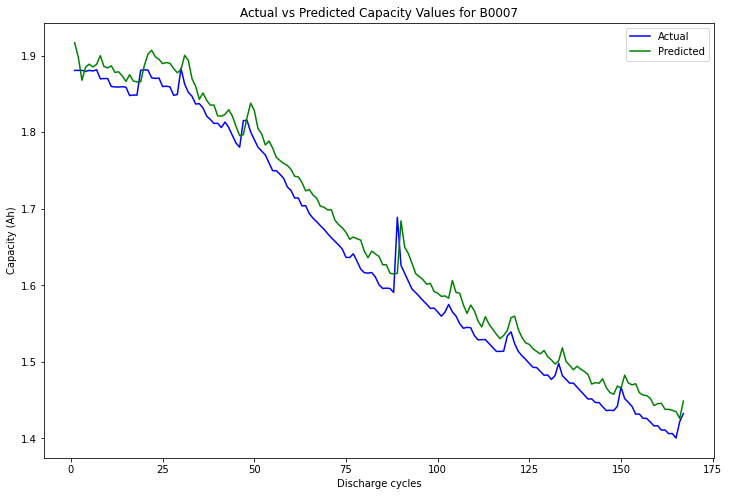

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy 
import scipy.io 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Metrics
# Compute for accuracy
def accuracy(y_test, y_pred):
  error = np.abs(y_pred-y_test)/y_test
  acc = np.ones_like(error) - error
  acc = np.sum(acc)/len(y_pred)
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
  """
  Prints difference between start and end time
  """

  total_time = end - start
  print(f"Inference time on {device}: {total_time:.3f} seconds")

  return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  usage_stat = snapshot.statistics(key_type)

  total = sum(stat.size for stat in usage_stat)

  print("Allocated memory: %.1f KiB" % (total / 1024))

  # function for making predictions
def test(loadedmodel, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loadedmodel.eval()
    with torch.inference_mode():
        hidden = loadedmodel.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loadedmodel(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 2.0

    #model_save_path = 'models/RNN_NASAvB5.pth'
    #model_save_path = 'models/RNN_NASAvB6.pth'
    model_save_path = 'models/RNN_NASAvB7.pth'
    #model_save_path = 'models/RNN_NASAvB18.pth'

    #test input tensor path
    #input_path = "tensors/B0005/B0005_input.pt"
    #input_path = "tensors/B0006/B0006_input.pt"
    input_path = "tensors/B0007/B0007_input.pt"
    #input_path = "tensors/B0018/B0018_input.pt"

    #target tensor path
    #target_path = "tensors/B0005/B0005_target.pt"
    #target_path = "tensors/B0006/B0006_target.pt"
    target_path = "tensors/B0007/B0007_target.pt"
    #target_path = "tensors/B0018/B0018_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    # model hyperparameters
    input_size = 31
    hidden_size = 10
    output_size = 1
    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))
    loadedmodel.to(device)

    test_loss, Y_test, y_pred = test(loadedmodel=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)
    
    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.8 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for B0007')
    plt.legend()
    


### B0018

Test Loss: 0.0010 | MAE: 0.0360 | MSE: 0.0447 | Accuracy: 0.98
True RUL: 95 | Prediction RUL: 86 | RUL Error: 9
Inference time on cpu: 0.058 seconds
Allocated memory: 5021.7 KiB


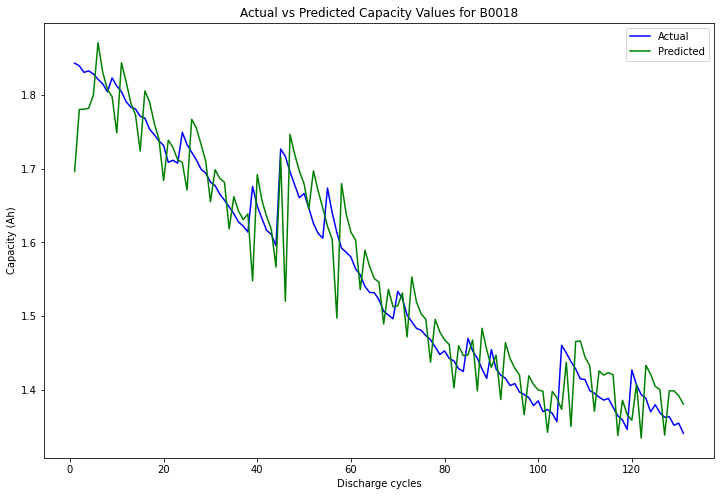

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy 
import scipy.io 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Metrics
# Compute for accuracy
def accuracy(y_test, y_pred):
  error = np.abs(y_pred-y_test)/y_test
  acc = np.ones_like(error) - error
  acc = np.sum(acc)/len(y_pred)
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
  """
  Prints difference between start and end time
  """

  total_time = end - start
  print(f"Inference time on {device}: {total_time:.3f} seconds")

  return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  usage_stat = snapshot.statistics(key_type)

  total = sum(stat.size for stat in usage_stat)

  print("Allocated memory: %.1f KiB" % (total / 1024))

  # function for making predictions
def test(loadedmodel, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loadedmodel.eval()
    with torch.inference_mode():
        hidden = loadedmodel.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loadedmodel(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 2.0

    #model_save_path = 'models/RNN_NASAvB5.pth'
    #model_save_path = 'models/RNN_NASAvB6.pth'
    #model_save_path = 'models/RNN_NASAvB7.pth'
    model_save_path = 'models/RNN_NASAvB18.pth'

    #test input tensor path
    #input_path = "tensors/B0005/B0005_input.pt"
    #input_path = "tensors/B0006/B0006_input.pt"
    #input_path = "tensors/B0007/B0007_input.pt"
    input_path = "tensors/B0018/B0018_input.pt"

    #target tensor path
    #target_path = "tensors/B0005/B0005_target.pt"
    #target_path = "tensors/B0006/B0006_target.pt"
    #target_path = "tensors/B0007/B0007_target.pt"
    target_path = "tensors/B0018/B0018_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    # model hyperparameters
    input_size = 31
    hidden_size = 10
    output_size = 1
    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))
    loadedmodel.to(device)

    test_loss, Y_test, y_pred = test(loadedmodel=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)
    
    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for B0018')
    plt.legend()
    


Test Loss: 0.0014 | MAE: 0.0480 | MSE: 0.0536 | Accuracy: 0.97
True RUL: 95 | Prediction RUL: 101 | RUL Error: -6
Inference time on cpu: 0.026 seconds
Allocated memory: 4160.9 KiB


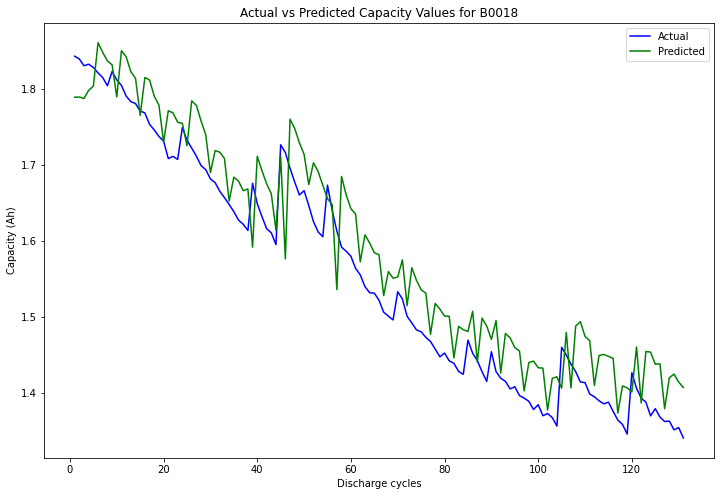

In [ ]:
# Import modules
import numpy as np
import random
import math
import os
import sys
import copy 
import scipy.io 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import linecache
import os
import tracemalloc
%matplotlib inline

from math import sqrt
from datetime import datetime
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from collections import Counter

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Metrics
# Compute for accuracy
def accuracy(y_test, y_pred):
  error = np.abs(y_pred-y_test)/y_test
  acc = np.ones_like(error) - error
  acc = np.sum(acc)/len(y_pred)
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
  """
  Prints difference between start and end time
  """

  total_time = end - start
  print(f"Inference time on {device}: {total_time:.3f} seconds")

  return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  usage_stat = snapshot.statistics(key_type)

  total = sum(stat.size for stat in usage_stat)

  print("Allocated memory: %.1f KiB" % (total / 1024))

  # function for making predictions
def test(loadedmodel, X_test, Y_test):
    loss_fn = nn.HuberLoss()
    loadedmodel.eval()
    with torch.inference_mode():
        hidden = loadedmodel.init_zero_hidden()
        hidden = hidden.to(device)
        test_out = []
        for i in range(X_test.size()[0]):
            # 1. Forward Pass
            test_output, hidden = loadedmodel(X_test[i], hidden)
            test_out.append(test_output)
                
        y_pred = torch.stack(test_out).to(device)
        # 2. Calculate Loss
        test_loss = loss_fn(y_pred.squeeze(-1), Y_test)
    return test_loss, Y_test, y_pred

if __name__ == "__main__":
    # timer
    start_time = timer()
    tracemalloc.start()
    torch.manual_seed(42)

    # Setting up device-agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Rated Capacity
    Rated_Capacity = 2.0

    #model_save_path = 'models/RNN_NASAvB5.pth'
    #model_save_path = 'models/RNN_NASAvB6.pth'
    #model_save_path = 'models/RNN_NASAvB7.pth'
    model_save_path = 'models/RNN_NASAvB18.pth'

    #test input tensor path
    #input_path = "tensors/B0005/B0005_input.pt"
    #input_path = "tensors/B0006/B0006_input.pt"
    #input_path = "tensors/B0007/B0007_input.pt"
    input_path = "tensors/B0018/B0018_input.pt"

    #target tensor path
    #target_path = "tensors/B0005/B0005_target.pt"
    #target_path = "tensors/B0006/B0006_target.pt"
    #target_path = "tensors/B0007/B0007_target.pt"
    target_path = "tensors/B0018/B0018_target.pt"

    X_test = torch.load(input_path)
    Y_test = torch.load(target_path)

    # model hyperparameters
    input_size = 31
    hidden_size = 10
    output_size = 1
    # load saved model
    # Instantiate a new instance of our model (this will be instantiated with random weights
    loadedmodel = RNNModel(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size)

    # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
    loadedmodel.load_state_dict(torch.load(f=model_save_path,
                                           map_location=torch.device('cpu')))
    loadedmodel.to(device)

    test_loss, Y_test, y_pred = test(loadedmodel=loadedmodel,
                                     X_test=X_test,
                                     Y_test=Y_test)
    
    acc = accuracy(Y_test.cpu().detach().numpy(), y_pred.squeeze(-1).cpu().detach().numpy())
    mae = mean_absolute_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy())
    mse = sqrt(mean_squared_error(y_pred.squeeze(-1).cpu().detach().numpy(), Y_test.cpu().detach().numpy()))

    # Computing RUL Error
    Threshold = 0.7 * Rated_Capacity
    idx_true = (Y_test<Threshold).nonzero().squeeze()
    RUL_true = idx_true[0][0]

    if(torch.Tensor(Y_test[int(RUL_true + 1)])>Threshold):
        RUL_true = idx_true[1][0]

    idx_pred = (y_pred<Threshold).nonzero().squeeze()  # search idx less than threshold
    RUL_pred = idx_pred[0][0]                        # first entry is pred RUL
    if(torch.Tensor(Y_test[int(RUL_pred + 1)])>Threshold):
        RUL_pred = idx_pred[1][0]
    RUL_error = RUL_true - RUL_pred
    # if positive value, earlier than true RUL; 
    # negative value, later than true RUL    
    print(f"Test Loss: {test_loss:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | Accuracy: {acc:.2f}")
    print(f"True RUL: {int(RUL_true)} | Prediction RUL: {int(RUL_pred)} | RUL Error: {int(RUL_error)}")
    

    end_time = timer()
    snapshot = tracemalloc.take_snapshot()

    print_inference_time(start_time, end_time, device)
    memory_stats(snapshot)
    y_pred = y_pred.cpu().detach().numpy().squeeze()
    Y_test = Y_test.cpu().detach().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    color_list = ['b:', 'g--', 'r-.', 'c.']
    y = list(range(1, len(y_pred)+1))
    ax.plot(y, Y_test, 'b', label='Actual')
    ax.plot(y, y_pred, 'g', label='Predicted')
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values for B0018')
    plt.legend()
    


## Scratch

In [ ]:
class RNNClassification(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassification, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.rnn(x.view(len(x),1,-1))[0]
        x = self.linear(h.view(len(x), -1))
        return x

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        '''
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        '''
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        '''
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = F.relu(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state
        '''
        hidden = self.lstm(x.unsqueeze(0))[0]
        output = self.linear(hidden)
        return output

    #def init_zero_hidden(self):
        #return torch.zeros(1, self.hidden_size)